# shap_testing7.ipynb
3.28.24

The point of this file is to go through and get a list of variances to find the indices, these indicies will be used to submit a job that calculates ISM (which we will also test in this file)

We will also compare it to gradients

In [45]:
#first let's test to see how fast getting variances for any cCRE is
#the next method is to actually speed it up using batching...
#can test regression at least by checking it with my old function and comparing the results later
#now that we use tensors, we can go ahead and find some ways to use larger batches

#let's fix the code
import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm
import time
class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, classification = False):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        self.classification = classification
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
                 

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter, classification=self.classification)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False, stop=False):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        device = "cuda:0" if cuda else "cpu"
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            class_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if self.classification:
                    # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                    class_list.append(b[0].item())
                    b = b[1] #just ignore the classification stuff?
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list)
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)
            class_list = self.dataset[ccre][1][0] #the classification stuff
        # print(class_list)
        temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
        out = decoder(temp)
        seqlen = ccre_list.shape[1] #because it's batch x seq
        dim_out = out.shape[1]//2

        if self.classification:
            out_class = out[:,:dim_out]
            out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
            #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
            #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
            #and let's keep the class out
            out_class_gt = out_class.detach().reshape(1,1,161)
            ISM_class = torch.ones((4,seqlen,161)).to(device)*out_class_gt
            out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
            
        out_gt = out.detach().reshape(1,1,161)
        ISM_results = torch.ones((4,seqlen,161)).to(device)*out_gt
        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        # if self.classification:
        #     mask_idx = np.array(class_list) == 1 #if it's open
        #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
        #     mask = np.zeros((1,1,161))
        #     mask[:,:,mask_idx] = 1
        # print(mask)
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze() #get rid f the embedding dimension
        token_list = [7,8,9,10] #tokenize this list first
        mutations = {
            7: np.array([8,9,10]),
            8: np.array([7,9,10]),
            9: np.array([7,8,10]),
            10: np.array([7,8,9])
        }
        ccre_list_gpu = ccre_list.to(device)

        if progress_bar:
            iterator = tqdm(enumerate(seq), total = len(seq))
        else:
            iterator = enumerate(seq)
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                # temp_token_list = token_list.copy() #we make a copy
                # print(nucleotide)
                if nucleotide not in token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list = mutations[nucleotide.item()]
                temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                batch_seq = torch.zeros(ccre_list_gpu.shape[0]*3,ccre_list_gpu.shape[1], dtype=torch.long).to(device)
                #make batch_seq a long tensor
                for idx2,j in enumerate(temp_token_list):
                    temp_seq = ccre_list_gpu.clone() #already put on the gpu
                    if self.mtype in ['DNase', 'DNase_ctst']:
                        temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                    else:
                        temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                    #now we need to stach them together
                    batch_seq[idx2*ccre_list_gpu.shape[0]:(idx2+1)*ccre_list_gpu.shape[0]] = temp_seq
                a,_ = backbone(batch_seq)
                out = decoder(a)
                # print(out.shape) #is 483 x 2 or 3 x 161*2...
                # we shoudl split into reg and class, but likely need a way to reshape it properly too
                if self.classification:
                    reg_results = out[:,dim_out:].view(3,1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                    class_results = out[:,:dim_out].view(3,1,161)
                else:
                    reg_results = out.view(3,1,161) 
                
                ISM_results[temp_token_list_gpu-7,idx,:] = reg_results.squeeze()
                if self.classification:
                    ISM_class[temp_token_list_gpu-7,idx,:] = class_results.squeeze()
        return 0 #just say we done for now
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class - out_class_gt_np
            # ISM_results_normalized *= mask
        if self.classification and return_out:
            return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
        elif self.classification:
            return ISM_results_normalized, ISM_class_normalized 
        elif return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized

    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx, print_out = False):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            if print_out:
                print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]

#let's test the speed of our ISM
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/10-val_loss=0.38773.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=True)
# out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 20)
#by editing it to batch, almost doubled the speed... wait could it just be that it's an A100??

In [3]:
var_list = []
for i in range(len(util.dataset)):
    a = util.var(i)
    var_list.append(a)
print(a) #did all 1000 quite quickly

IndexError: index 856076 is out of bounds for axis 0 with size 856076

In [6]:
len(util.dataset)/161 #took 1 minute for the train set?

856076.0

<Axes: ylabel='Count'>

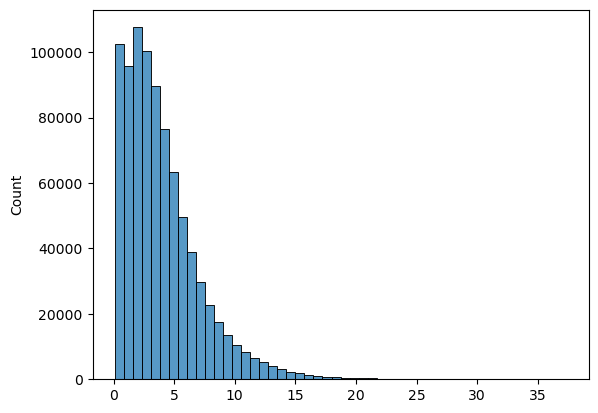

In [7]:
#let's do a histogram of it
sns.histplot(var_list, bins = 50)

In [8]:
#let's try preallocating an array instead of appending
#the other option is to just vectorize the whole thing, requires a tiny bit more work
# var_list = np.zeros(len(util.dataset))
# for i in range(len(util.dataset)):
#     a = util.var(i)
#     var_list[i] = a
# print(a) #

#it's fast enough to where we don't care
var_list = np.array(var_list)
#now we should find the top 800 variances
top_idx = np.argsort(var_list)[-800:]
print(top_idx)

[757776 616550 757564 115827 824614 757514 616864 273257 740436 367431
 616718 856009 824637 757687 686456 406553 757674 856029 616875 856014
 824624 616947  59451 757785 644000 616907 752761 616950 757705 676796
 616656 824607 546019 856056 855978 757494 757561 644312 855994 611847
 757528 343654 625515 184114 625433 616681  40999 656337 770152 856062
 616892 757482 757630 616964 700151 574204  98430 578187 757541 660295
 461768 616631 757569 757486 736386 746899 757579 663782 824667 655887
 365050 757750 725181 855990 228242 747521 856045 619499 757485 757744
 856010 757808 616773 675501 554394 616804 757577 702806 616585 616906
 117442 333210 687903 757507 274007 616925 552638 147841 824677 757717
 824662 177838 428507 570015 153484 824730 616862 616852 688542 227722
 616800 757527 616904 757521  61085 757483 437061 740304 616833 754855
 381139 616984 757738 506182 616620 376894 616683 757766 625434 757735
 521979 757805 627636 616732 467465 611849 116200 824642 757708 562337
 75759

In [9]:
#this is the top idx of variances, we can verify this makes sense
#0 idx is lowest, -1 idx is highest, let's print them to see if it makes sense
print(var_list[top_idx[0]])
print(var_list[top_idx[-1]])
print(np.max(var_list))

21.97047326794178
37.3295163225902
37.3295163225902


In [14]:
#let's get the output for the top_idx
idx = top_idx[-1]
idx = 161*idx
out_list = []
target_list = []
for i in range(161):
    a,b = util.dataset[idx+i]
    temp,_ = util.backbone(a.unsqueeze(0))
    out = util.decoder(temp)
    out_list.append(out[0,1].item())
    target_list.append(b[1].item())
print(out_list)

[1.96999192237854, 1.8382842540740967, 3.092090606689453, 3.3291566371917725, 3.1063358783721924, 3.0512406826019287, 3.2146494388580322, 3.334730863571167, 2.4374845027923584, 2.7568743228912354, 2.7754642963409424, 2.316953182220459, 2.2804460525512695, 2.838026762008667, 2.753607988357544, 3.0812642574310303, 2.7424964904785156, 2.5019071102142334, 2.648059606552124, 2.96549916267395, 3.4042694568634033, 1.6005873680114746, 2.908557891845703, 3.167809247970581, 3.022590398788452, 2.875159502029419, 2.9145219326019287, 2.067584991455078, 2.7382237911224365, 1.916175365447998, 3.079648733139038, 2.2228031158447266, 3.529783010482788, 1.7062971591949463, 3.6110970973968506, 3.0794291496276855, 3.2628538608551025, 4.8217549324035645, 3.6904473304748535, 4.014173984527588, 3.5620930194854736, 3.7181613445281982, 3.7487499713897705, 3.754755735397339, 3.0803730487823486, 3.808440685272217, 3.374964952468872, 3.3942487239837646, 3.764517068862915, 3.416642427444458, 3.2250876426696777, 4.2

<Axes: ylabel='Count'>

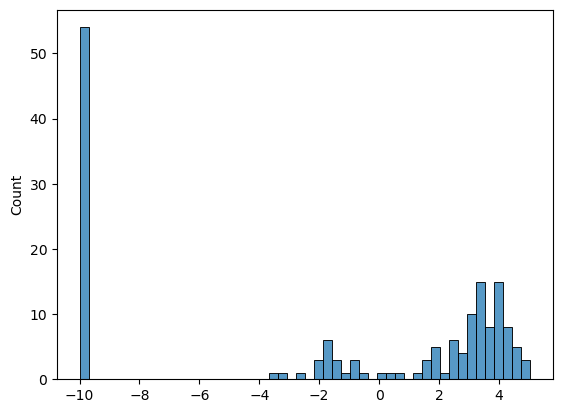

In [17]:
#sns histogram of target_list
sns.histplot(target_list, bins = 50)
#indeed that is highly variable...

In [20]:
idx = top_idx[0]
idx = 161*idx
target_list = []
for i in range(161):
    a,b = util.dataset[idx+i]
    target_list.append(b[1].item())

<Axes: ylabel='Count'>

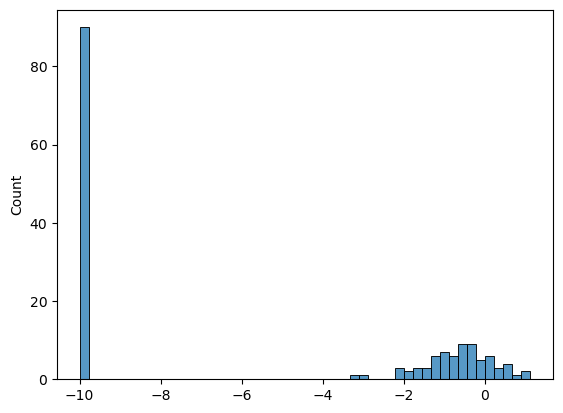

In [21]:
sns.histplot(target_list, bins = 50)
#I think this is a good mixture, what if we also get a list of the 

In [22]:
#save out the top_idx list
np.save('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs/most_variable_train.npy', top_idx)

In [23]:
util = ISMUtils('DNase_ctst', ckpt_path, classification=True, split = 'val')

In [25]:
var_list = []
for i in range(int(len(util.dataset)/161)):
    a = util.var(i)
    var_list.append(a)
print(a) #did all 1000 quite quickly

#get the top 100
var_list = np.array(var_list)
top_idx = np.argsort(var_list)[-100:]

3.4798981593815297


In [26]:
print(var_list[top_idx[0]])
print(var_list[top_idx[-1]])
#similar values! because similar ratio so makes sense

19.3763573713277
26.76852364601814


In [27]:
#now save it out
np.save('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs/most_variable_val.npy', top_idx)

In [28]:
#finally for test
util = ISMUtils('DNase_ctst', ckpt_path, classification=True, split = 'test')
var_list = []
for i in range(int(len(util.dataset)/161)):
    a = util.var(i)
    var_list.append(a)
print(a) #did all 1000 quite quickly

#get the top 100
var_list = np.array(var_list)
top_idx = np.argsort(var_list)[-100:]
print(var_list[top_idx[0]])
print(var_list[top_idx[-1]])

3.997605204595969
18.963990608596635
26.212336163246196


In [29]:
np.save('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs/most_variable_test.npy', top_idx)

In [30]:
#we will now do a job that calculates ISM, first let's test our classification models with the new ISM procedure to make sure it is actually identical
#we won't run it here, but can use a rejection sampling approach!
import random
train_idx = np.load('/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/most_variable_cCREs/most_variable_train.npy')
# train_idx = set(train_idx) #this will technically speed things up because sets are implemented with hash tables but we're doing 800 things
other_idx = set()
while len(other_idx) < len(train_idx):
    sample = random.randint(0,len(util.dataset)-1)
    if sample not in train_idx:
        other_idx.add(sample)
print(len(other_idx))
print(other_idx)

800
{6780929, 12576779, 14030863, 10657808, 8603666, 6709272, 6699032, 15935515, 2977821, 16066590, 6744099, 12142627, 5910565, 15110184, 8497195, 9637935, 5693491, 11538487, 2777143, 7792697, 11638841, 6461497, 10680379, 11907133, 6901822, 15073339, 5675072, 5894211, 4087877, 5210182, 14768197, 10055752, 14585928, 15304778, 1814605, 3833935, 9543760, 788565, 6250582, 7303256, 11927641, 15947866, 10342489, 4053082, 9005149, 12558435, 71780, 5310564, 825446, 10389610, 1871984, 4997235, 12234872, 5529721, 6410365, 12779652, 13510793, 14772361, 12136592, 7022737, 4692116, 10309780, 11370647, 2736280, 5136536, 5660825, 1931419, 3965086, 8890526, 12800160, 16861345, 3578017, 16693412, 227500, 3094701, 15282350, 7798958, 6500531, 8339637, 16564407, 9750712, 14948540, 8214717, 7286973, 11034818, 6291652, 4905161, 16838859, 10508492, 5279947, 13037772, 413903, 5062866, 6744276, 16877782, 10338518, 2392283, 1583323, 11909342, 782562, 8714470, 8921320, 15673577, 4268267, 6312172, 13045997, 90687

In [31]:
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True)

setup: 4.033229827880859


  0%|          | 0/1024 [00:00<?, ?it/s]

altering: 0.002004384994506836
model: 0.25556039810180664
storing: 0.00014901161193847656


  0%|          | 2/1024 [00:00<04:58,  3.42it/s]

storing in big matrix: 0.2713608741760254
altering: 0.0015299320220947266
model: 0.007149934768676758
storing: 7.081031799316406e-05


  0%|          | 3/1024 [00:00<04:49,  3.53it/s]

storing in big matrix: 0.2582743167877197
altering: 0.0016450881958007812
model: 0.007145881652832031
storing: 6.818771362304688e-05


  0%|          | 4/1024 [00:01<04:46,  3.56it/s]

storing in big matrix: 0.26425719261169434
altering: 0.0016143321990966797
model: 0.007064104080200195
storing: 7.081031799316406e-05


  0%|          | 5/1024 [00:01<04:44,  3.59it/s]

storing in big matrix: 0.2622082233428955
altering: 0.0016508102416992188
model: 0.007158756256103516
storing: 6.866455078125e-05


  1%|          | 6/1024 [00:01<04:42,  3.60it/s]

storing in big matrix: 0.26294469833374023
altering: 0.0017473697662353516
model: 0.007098197937011719
storing: 6.556510925292969e-05


  1%|          | 7/1024 [00:01<04:41,  3.61it/s]

storing in big matrix: 0.26262545585632324
altering: 0.0016150474548339844
model: 0.00719451904296875
storing: 6.985664367675781e-05


  1%|          | 8/1024 [00:02<04:40,  3.62it/s]

storing in big matrix: 0.26144886016845703
altering: 0.001604318618774414
model: 0.007266044616699219
storing: 6.628036499023438e-05


  1%|          | 9/1024 [00:02<04:40,  3.62it/s]

storing in big matrix: 0.2650725841522217
altering: 0.0015752315521240234
model: 0.007012367248535156
storing: 8.368492126464844e-05


  1%|          | 10/1024 [00:02<04:40,  3.62it/s]

storing in big matrix: 0.2635207176208496
altering: 0.0016026496887207031
model: 0.007063388824462891
storing: 6.961822509765625e-05


  1%|          | 11/1024 [00:03<04:39,  3.62it/s]

storing in big matrix: 0.26361703872680664
altering: 0.0016033649444580078
model: 0.007082223892211914
storing: 7.152557373046875e-05


  1%|          | 12/1024 [00:03<04:40,  3.61it/s]

storing in big matrix: 0.2667267322540283
altering: 0.0016100406646728516
model: 0.007091522216796875
storing: 8.058547973632812e-05


  1%|▏         | 13/1024 [00:03<04:39,  3.61it/s]

storing in big matrix: 0.26342320442199707
altering: 0.0016238689422607422
model: 0.007038593292236328
storing: 6.985664367675781e-05


  1%|▏         | 14/1024 [00:03<04:39,  3.62it/s]

storing in big matrix: 0.2628645896911621
altering: 0.0015957355499267578
model: 0.007064342498779297
storing: 6.961822509765625e-05


  1%|▏         | 15/1024 [00:04<04:39,  3.61it/s]

storing in big matrix: 0.267012357711792
altering: 0.001626729965209961
model: 0.007082939147949219
storing: 7.581710815429688e-05


  2%|▏         | 16/1024 [00:04<04:39,  3.60it/s]

storing in big matrix: 0.2664813995361328
altering: 0.001627206802368164
model: 0.007065534591674805
storing: 6.723403930664062e-05


  2%|▏         | 17/1024 [00:04<04:40,  3.59it/s]

storing in big matrix: 0.26755380630493164
altering: 0.0015795230865478516
model: 0.0070378780364990234
storing: 7.009506225585938e-05


  2%|▏         | 18/1024 [00:05<04:41,  3.58it/s]

storing in big matrix: 0.2694096565246582
altering: 0.0015881061553955078
model: 0.007005929946899414
storing: 6.794929504394531e-05


  2%|▏         | 19/1024 [00:05<04:39,  3.60it/s]

storing in big matrix: 0.26266026496887207
altering: 0.00157928466796875
model: 0.0070803165435791016
storing: 6.937980651855469e-05


  2%|▏         | 20/1024 [00:05<04:39,  3.60it/s]

storing in big matrix: 0.26611995697021484
altering: 0.001621246337890625
model: 0.006998300552368164
storing: 6.651878356933594e-05


  2%|▏         | 21/1024 [00:05<04:39,  3.59it/s]

storing in big matrix: 0.26624035835266113
altering: 0.0016274452209472656
model: 0.007186174392700195
storing: 6.914138793945312e-05


  2%|▏         | 22/1024 [00:06<04:39,  3.59it/s]

storing in big matrix: 0.26650166511535645
altering: 0.0016160011291503906
model: 0.006958961486816406
storing: 6.818771362304688e-05


  2%|▏         | 23/1024 [00:06<04:38,  3.59it/s]

storing in big matrix: 0.2658815383911133
altering: 0.001604318618774414
model: 0.007180929183959961
storing: 6.842613220214844e-05


  2%|▏         | 24/1024 [00:06<04:37,  3.60it/s]

storing in big matrix: 0.2640504837036133
altering: 0.001596689224243164
model: 0.00703883171081543
storing: 6.699562072753906e-05


  2%|▏         | 25/1024 [00:06<04:37,  3.60it/s]

storing in big matrix: 0.2651181221008301
altering: 0.0017211437225341797
model: 0.00706171989440918
storing: 0.00012421607971191406


  2%|▏         | 25/1024 [00:07<04:49,  3.46it/s]


KeyboardInterrupt: 

In [46]:
1/0

ZeroDivisionError: division by zero

In [44]:
#let's see what happens when we remove the print statements? everything seems fast except for the storing in big matrix
#actually just kept print statements but added the synchronize to test the real speed
#get gc
import gc
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 10)

setup: 0.3585214614868164


  0%|          | 0/1024 [00:00<?, ?it/s]

altering: 0.0017354488372802734


  0%|          | 2/1024 [00:00<03:16,  5.21it/s]

model: 0.3810770511627197
storing: 0.00019025802612304688
storing in big matrix: 0.0003521442413330078
altering: 0.0017750263214111328


  0%|          | 3/1024 [00:00<03:51,  4.41it/s]

model: 0.26898860931396484
storing: 0.00021028518676757812
storing in big matrix: 0.00038623809814453125
altering: 0.0018854141235351562


  0%|          | 4/1024 [00:00<04:08,  4.11it/s]

model: 0.26589512825012207
storing: 0.00021505355834960938
storing in big matrix: 0.0003592967987060547
altering: 0.0018358230590820312


  0%|          | 5/1024 [00:01<04:18,  3.94it/s]

model: 0.2686784267425537
storing: 0.00021457672119140625
storing in big matrix: 0.0003407001495361328
altering: 0.0018486976623535156


  1%|          | 6/1024 [00:01<04:24,  3.85it/s]

model: 0.2656867504119873
storing: 0.0002040863037109375
storing in big matrix: 0.00035452842712402344
altering: 0.0017981529235839844


  1%|          | 7/1024 [00:01<04:28,  3.79it/s]

model: 0.2673969268798828
storing: 0.0002033710479736328
storing in big matrix: 0.0003497600555419922
altering: 0.0017986297607421875


  1%|          | 8/1024 [00:02<04:31,  3.75it/s]

model: 0.26809048652648926
storing: 0.0001983642578125
storing in big matrix: 0.00036454200744628906
altering: 0.0017452239990234375


  1%|          | 9/1024 [00:02<04:33,  3.71it/s]

model: 0.2700541019439697
storing: 0.0002884864807128906
storing in big matrix: 0.0003514289855957031
altering: 0.001806020736694336


  1%|          | 10/1024 [00:02<04:35,  3.68it/s]

model: 0.2703723907470703
storing: 0.00020623207092285156
storing in big matrix: 0.0003762245178222656
altering: 0.0017745494842529297


  1%|          | 10/1024 [00:02<04:48,  3.51it/s]

model: 0.2669665813446045
storing: 0.00023055076599121094
storing in big matrix: 0.0003821849822998047


In [47]:
#good thing we checked by synchronizing, it is indeed the model running that is the slow part!
#have to synchronize before and after the model runs to really time it, and we found it's indeed the model that's the slowdown now!
#wait no, now it's the storing that is slow, not even the storing in the big matrix? let's place some more strategic synchronize statements
#when we fixed the synchronize statements, we see indeed it is the model that is slow. 
#in order to better batch things we need to fundamentally change the way we do ISM, we need to do it in a batched way

#ooooooh, what if we find all the As that we are supposed to change, then take like 4 of them (make this a parameter of the function itself).
#then it's the same indexing mechanism and the same fundamental change, but we only do it once, so bigger batches... that's it!!
#so we have 4 sections, A list, C list, G list, T list, and then we just do it all at once, and then we can just reshape it and assign it like we do now...
#that's it, that's the solution, we just have to do it all at once, and then we can just reshape it and assign it like we do now...

#an annoying to code solution for sure, but before then, first remove all the torch.synchronize and end and start timers and just test the speed
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True)
#1080ti is much slower!
#we are actually close to the full memory usage, this means that we can't increase the batch size, also may be artifically slower, like 4x than the A100
#we'll actually retest this on the A100 where we can increase batch size

100%|██████████| 1024/1024 [04:49<00:00,  3.54it/s]


In [52]:
util.dataset.tokenizer._vocab_int_to_str

{0: '[CLS]',
 1: '[SEP]',
 2: '[BOS]',
 3: '[MASK]',
 4: '[PAD]',
 5: '[RESERVED]',
 6: '[UNK]',
 7: 'A',
 8: 'C',
 9: 'G',
 10: 'T',
 11: 'N'}

In [53]:
a,b = util.dataset[0]
print(a)

tensor([12,  9,  9,  ...,  8, 10,  8])


In [57]:
A_loc = np.where(a == 7)[0]
A_loc.shape #338 of them are like this

(338,)

In [58]:
#now we batch them into sections of length 8
batch_size = 8
# A_loc = A_loc
A_loc_split = np.array_split(A_loc, len(A_loc)//batch_size)
A_loc_split

[array([ 5,  6, 10, 12, 14, 15, 26, 27, 30]),
 array([31, 34, 35, 36, 42, 45, 47, 51, 61]),
 array([62, 64, 66, 70, 74, 76, 81, 83]),
 array([ 84,  85,  86,  93,  94,  96,  98, 104]),
 array([112, 115, 117, 120, 121, 123, 125, 127]),
 array([128, 132, 139, 140, 143, 146, 148, 149]),
 array([150, 153, 155, 161, 173, 175, 177, 181]),
 array([182, 183, 185, 187, 193, 198, 204, 205]),
 array([207, 210, 211, 213, 218, 220, 222, 224]),
 array([225, 228, 229, 230, 234, 236, 241, 243]),
 array([244, 247, 249, 255, 257, 258, 259, 263]),
 array([270, 275, 276, 279, 283, 284, 285, 286]),
 array([287, 291, 303, 305, 306, 307, 309, 310]),
 array([312, 316, 319, 320, 322, 324, 325, 328]),
 array([331, 332, 335, 337, 338, 345, 347, 352]),
 array([359, 361, 363, 366, 368, 370, 372, 374]),
 array([376, 377, 379, 381, 390, 391, 392, 397]),
 array([398, 402, 408, 410, 412, 413, 414, 416]),
 array([417, 419, 423, 427, 428, 429, 434, 435]),
 array([437, 442, 444, 450, 452, 453, 456, 460]),
 array([463, 467

In [59]:
#alternative approach
num_batches = -(-len(A_loc) // batch_size)
A_loc_split = np.array_split(A_loc, num_batches)
print(A_loc_split)
#makes the last remainder into length of 7, also it's in ascending order

[array([ 5,  6, 10, 12, 14, 15, 26, 27]), array([30, 31, 34, 35, 36, 42, 45, 47]), array([51, 61, 62, 64, 66, 70, 74, 76]), array([81, 83, 84, 85, 86, 93, 94, 96]), array([ 98, 104, 112, 115, 117, 120, 121, 123]), array([125, 127, 128, 132, 139, 140, 143, 146]), array([148, 149, 150, 153, 155, 161, 173, 175]), array([177, 181, 182, 183, 185, 187, 193, 198]), array([204, 205, 207, 210, 211, 213, 218, 220]), array([222, 224, 225, 228, 229, 230, 234, 236]), array([241, 243, 244, 247, 249, 255, 257, 258]), array([259, 263, 270, 275, 276, 279, 283, 284]), array([285, 286, 287, 291, 303, 305, 306, 307]), array([309, 310, 312, 316, 319, 320, 322, 324]), array([325, 328, 331, 332, 335, 337, 338, 345]), array([347, 352, 359, 361, 363, 366, 368, 370]), array([372, 374, 376, 377, 379, 381, 390, 391]), array([392, 397, 398, 402, 408, 410, 412, 413]), array([414, 416, 417, 419, 423, 427, 428, 429]), array([434, 435, 437, 442, 444, 450, 452, 453]), array([456, 460, 463, 467, 468, 469, 473, 478]), ar

In [99]:
#so we will rewrite many sections of the code
#first let's test to see how fast getting variances for any cCRE is
#the next method is to actually speed it up using batching...
#can test regression at least by checking it with my old function and comparing the results later
#now that we use tensors, we can go ahead and find some ways to use larger batches

#let's fix the code
import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm
import time
class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, classification = False):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        self.classification = classification
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
                 

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter, classification=self.classification)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False, stop=False):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        device = "cuda:0" if cuda else "cpu"
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            class_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if self.classification:
                    # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                    class_list.append(b[0].item())
                    b = b[1] #just ignore the classification stuff?
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list) #note these should all be identical other than the unique tokens at the beginning
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)
            class_list = self.dataset[ccre][1][0] #the classification stuff
        # print(class_list)
        temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
        out = decoder(temp)
        seqlen = ccre_list.shape[1] #because it's batch x seq
        dim_out = out.shape[1]//2

        if self.classification:
            out_class = out[:,:dim_out]
            out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
            #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
            #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
            #and let's keep the class out
            out_class_gt = out_class.detach().reshape(1,1,161)
            ISM_class = torch.ones((4,seqlen,161)).to(device)
            out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
            
        out_gt = out.detach().reshape(1,1,161)
        ISM_results = torch.ones((4,seqlen,161)).to(device).detach().cpu().numpy()
        print(ISM_results.shape)
        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        # if self.classification:
        #     mask_idx = np.array(class_list) == 1 #if it's open
        #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
        #     mask = np.zeros((1,1,161))
        #     mask[:,:,mask_idx] = 1
        # print(mask)
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze() #get rid f the embedding dimension
        token_list = [7,8,9,10] #tokenize this list first
        mutations = {
            7: np.array([8,9,10]),
            8: np.array([7,9,10]),
            9: np.array([7,8,10]),
            10: np.array([7,8,9])
        }
        ccre_list_gpu = ccre_list.to(device)
        #the whole above section takes only like .3 seconds, not a huge time use or sink, can ignore it

        # if progress_bar:
        #     iterator = tqdm(enumerate(seq), total = len(seq))
        # else:
        #     iterator = enumerate(seq)

        #let's actually preallocate things, here we can use the explicit 7,8,9,10 tokens, so we don't need to bother continuing
        # A_loc = np.where(seq.detach().cpu().numpy() == 7)[0]
        # C_loc = np.where(seq.detach().cpu().numpy() == 8)[0]
        # G_loc = np.where(seq.detach().cpu().numpy() == 9)[0]
        # T_loc = np.where(seq.detach().cpu().numpy() == 10)[0]
        #we can just use seq because ACGT will be same locations across the sequence
        #don't actually use the above, we can instead, just use a for loop to define the splits
        ccre_len = ccre_list_gpu.shape[0]
        nuc_pos = {}
        for i in range(7,11):
            loc = np.where(seq.detach().cpu().numpy() == i)[0]
            num_batches = -(-len(loc) // batch_size)
            loc_split = np.array_split(loc, num_batches)
            nuc_pos[i] = loc_split #with this we can do 2 internal for loops, one over each nucleotide, one over each batch

        with torch.no_grad():
            #now we loop over the nucleotides first
            for nuc_idx, nucleotide in enumerate(nuc_pos.keys()):
                #nuc_idx goes from 0 to 3, while nucleotide is 7-10 corresponds to ACGT in that order
                temp_token_list = mutations[nucleotide]
                        # temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                for batch_idx, batch in enumerate(nuc_pos[nucleotide]):
                    #now we have the batch, we can do the same thing as before
                    #actually we need to do a third and fourth for loop even
                    #here batch_idx is the index of the batch, likely not too useful except for storing our data
                    #batch is the actual batch of indices, like array([ 5,  6, 10, 12, 14, 15, 26, 27]) from above
                    batch_seq = torch.zeros(ccre_list_gpu.shape[0]*len(batch)*3,ccre_list_gpu.shape[1], dtype=torch.long).to(device)
                    # print(batch_seq.shape)
                    #batch seq is size 161*3*batch_size x 1024 for the DNase model, only 1*3*batch_size x 1023 for the multitasking mdoel
                    #idea is we calculate it with these large batches
                    for counter, seq_idx in enumerate(batch):
                        #counter tells us how far into the batch we are, seq_idx is the actual index of the sequence, like 5, 6, 10, 12, 14, 15, 26, 27
                        for idx2,k in enumerate(temp_token_list):
                            #idx2 is just another counter, k is the mutated nucleotide we are replacing it with
                            temp_seq = ccre_list_gpu.clone() #have to clone it because we will be changing it
                            temp_seq[:,seq_idx] = k
                            #so we assigned the temp_seq by replacing that idx with the other 3 possibilities
                            #but this assignment below seems a bit sus, might be correct tho
                            #only goes as far back as the batch
                            #very first element should be 0 to 161, second from 161 to 161*2, then next counter we go from 161*3 to 161*4 etc.
                            batch_seq[counter*3*ccre_len+idx2*ccre_len:counter*3*ccre_len+(idx2+1)*ccre_len,:] = temp_seq
                    # return batch_seq #might somehow be correct?? Then we run iti throught the model
                    # a,_ = backbone(batch_seq)
                    # out = decoder(a)
                    # return(out)
                    #temporarily just assign out to a matrix of random values
                    out = torch.rand((3*len(batch)*161,2)).to(device)
                    #now need to assign it in the larger tensor
                    if self.classification:
                        reg_results = out[:,dim_out:].view(3,-1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                        class_results = out[:,:dim_out].view(3,-1,161)
                    else:
                        reg_results = out.view(3,-1,161)
                    # reshaped_out = out.view(-1, 3, 161)
                    # print(reg_results.shape)
                    # print(batch, batch.shape)
                    # print(temp_token_list, len(temp_token_list))
                    # print(ISM_results[temp_token_list-7,batch,:].shape)
                    ISM_results[temp_token_list-7,batch,:] = reg_results.detach().cpu().numpy()
                    return 0
                        # temp_seq[:,seq_idx] = temp_token_list[counter] #should be 161x1024 or 1023.
                    # temp_seq = ccre_list_gpu.clone()

            for i in range(len(nuc_pos[7])):
                batch_seq = torch.zeros(ccre_list_gpu.shape[0]*3,ccre_list_gpu.shape[1], dtype=torch.long).to(device)
                for j in range(7,11):
                    loc = nuc_pos[j][i]
                    temp_token_list = mutations[j]
                    temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                    for idx2,k in enumerate(temp_token_list):
                        temp_seq = ccre_list_gpu.clone()
            
        
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                if nucleotide not in token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list = mutations[nucleotide.item()]
                temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                batch_seq = torch.zeros(ccre_list_gpu.shape[0]*3,ccre_list_gpu.shape[1], dtype=torch.long).to(device)
                #make batch_seq a long tensor
                for idx2,j in enumerate(temp_token_list):
                    temp_seq = ccre_list_gpu.clone() #already put on the gpu
                    if self.mtype in ['DNase', 'DNase_ctst']:
                        temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                    else:
                        temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                    #now we need to stach them together
                    batch_seq[idx2*ccre_list_gpu.shape[0]:(idx2+1)*ccre_list_gpu.shape[0]] = temp_seq
                a,_ = backbone(batch_seq)
                out = decoder(a)
                # print(out.shape) #is 483 x 2 or 3 x 161*2...
                # we shoudl split into reg and class, but likely need a way to reshape it properly too
                if self.classification:
                    reg_results = out[:,dim_out:].view(3,1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                    class_results = out[:,:dim_out].view(3,1,161)
                else:
                    reg_results = out.view(3,1,161) 
                
                ISM_results[temp_token_list_gpu-7,idx,:] = reg_results.squeeze()
                if self.classification:
                    ISM_class[temp_token_list_gpu-7,idx,:] = class_results.squeeze()
        return 0 #just say we done for now
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class - out_class_gt_np
            # ISM_results_normalized *= mask
        if self.classification and return_out:
            return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
        elif self.classification:
            return ISM_results_normalized, ISM_class_normalized 
        elif return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized

    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx, print_out = False):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            if print_out:
                print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]

#let's test the speed of our ISM
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/10-val_loss=0.38773.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=True)
# out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 20)
#by editing it to batch, almost doubled the speed... wait could it just be that it's an A100??

In [61]:
1/0 #clears cuda memory since now %debug is this

ZeroDivisionError: division by zero

In [62]:
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True)
#the assignment worked??

torch.Size([3864, 1024])


In [63]:
#let's see if the shape is correct, we're doing batches of 8
8*161*3 #yupperoo dude, ok maybe?

3864

In [65]:
1/0

ZeroDivisionError: division by zero

In [66]:
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True)
print(out.shape)

torch.Size([3864, 1024])
torch.Size([3864, 1024])


In [67]:
#let's check to see how many elements of out are 0
print(torch.sum(out==0))

tensor(0, device='cuda:0')


In [69]:
print(out[0,:10]) #first element of the first batch is 5, so we should see idx 6 (cuz extra element for cell type) which is normally 7 be 8 and 9
print(out[1,:10])

tensor([12,  9,  9, 10,  9,  8,  7,  9,  9, 10], device='cuda:0')
tensor([13,  9,  9, 10,  9,  8,  7,  9,  9, 10], device='cuda:0')


In [70]:
#are they equal
torch.allclose(out[0,1:], out[1,1:])
#yeah something is wrong here, they shouldn't be like this?

True

In [72]:
#have to duplicate temp seq every single time, lots of duplications son...
1/0

ZeroDivisionError: division by zero

In [73]:
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True)
print(out.shape)

torch.Size([3864, 1024])
torch.Size([3864, 1024])


In [75]:
#1 second for the batch, for all the batches not even that long
print(out[0,:10]) #first element of the first batch is 5, so we should see idx 6 (cuz extra element for cell type) which is normally 7 be 8 and 9
print(out[1,:10])
#wait, I just realized they're different celltypes too... this is not good at all, should be the same celltype??
#maybe the indexing is off somehow, or it's something fundamentally wrong with what I'm doing, gotta check the logic
#waittttt, it's actually correct, the way I'm doing it is all 161 cell types, so let's check the outp161
print(out[161,:10]) #so that was a 7, was first changed to 8, then 9!

tensor([12,  9,  9, 10,  9,  8,  7,  9,  9, 10], device='cuda:0')
tensor([13,  9,  9, 10,  9,  8,  7,  9,  9, 10], device='cuda:0')
tensor([12,  9,  9, 10,  9,  9,  7,  9,  9, 10], device='cuda:0')


In [77]:
print(out[161*2,:10]) #shoudl now be 10
print(out[161*3,:10]) #should now be the next 7 that's different and that original one should be 7 again
#yessssirrrrr!!! I think it might actually ybe correct somehow, there's no way we actually did it???

tensor([12,  9,  9, 10,  9, 10,  7,  9,  9, 10], device='cuda:0')
tensor([12,  9,  9, 10,  9,  7,  8,  9,  9, 10], device='cuda:0')


In [79]:
1/0

ZeroDivisionError: division by zero

In [81]:
#now the quetion is how do we properly assign it to a matrix?
#let's see the shape of out, will be annoying, but again just gotta reshape it and split to classification and reg, should just be output_len x 2
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=False, progress_bar = True, return_out=True) #not using cuda is slow as shit, but I guess that's how it is if we dont' get a big gpu?
print(out.shape) #it took 4 minutes for one batch lmfao!

torch.Size([3864, 2])


In [83]:
#now let's see how we could possibly split this, unironically we could probably do .view?
#let's just see what chatgpt thinks
output_tensor = out[:,0] #should be 3864, no other dimension
reshaped_output = output_tensor.view(-1, 3, 161)
reshaped_output.shape #hmm, this seems quite promising

torch.Size([8, 3, 161])

In [85]:
1/0

ZeroDivisionError: division by zero

In [100]:
#now the quetion is how do we properly assign it to a matrix?
#let's see the shape of out, will be annoying, but again just gotta reshape it and split to classification and reg, should just be output_len x 2
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=False, progress_bar = True, return_out=True) #not using cuda is slow as shit, but I guess that's how it is if we dont' get a big gpu?
print(out.shape) #it took 4 minutes for one batch lmfao!
#let's see if indexing works, if it does, have to ensure that it indexes the way we think it does

(4, 1024, 161)


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (3,) (8,) 

In [ ]:
#let's try doing this with numpy maybe?
#that doesn't work either, but I have a much better idea, just stack several of these together, use a custom dataset class to do this!
#so we will rewrite many sections of the code
#first let's test to see how fast getting variances for any cCRE is
#the next method is to actually speed it up using batching...
#can test regression at least by checking it with my old function and comparing the results later
#now that we use tensors, we can go ahead and find some ways to use larger batches

#let's fix the code
import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm
import time
class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, classification = False):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        self.classification = classification
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
                 

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter, classification=self.classification)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False, stop=False, b_size = 8):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        device = "cuda:0" if cuda else "cpu"
        self.device = device
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            class_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if self.classification:
                    # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                    class_list.append(b[0].item())
                    b = b[1] #just ignore the classification stuff?
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list) #note these should all be identical other than the unique tokens at the beginning
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)
            class_list = self.dataset[ccre][1][0] #the classification stuff
        # print(class_list)
        temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
        out = decoder(temp)
        seqlen = ccre_list.shape[1] #because it's batch x seq
        self.seqlen = seqlen
        dim_out = out.shape[1]//2
        self.dim_out = dim_out

        if self.classification:
            out_class = out[:,:dim_out]
            out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
            #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
            #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
            #and let's keep the class out
            out_class_gt = out_class.detach().reshape(1,1,161)
            ISM_class = torch.ones((4,seqlen,161)).to(device)
            out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
            
        out_gt = out.detach().reshape(1,1,161)
        ISM_results = torch.ones((4,seqlen,161)).to(device)
        print(ISM_results.shape)
        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        # if self.classification:
        #     mask_idx = np.array(class_list) == 1 #if it's open
        #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
        #     mask = np.zeros((1,1,161))
        #     mask[:,:,mask_idx] = 1
        # print(mask)
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze() #get rid f the embedding dimension
        token_list = [7,8,9,10] #tokenize this list first
        mutations = {
            7: np.array([8,9,10]),
            8: np.array([7,9,10]),
            9: np.array([7,8,10]),
            10: np.array([7,8,9])
        }
        self.mutations = mutations
        ccre_list_gpu = ccre_list.to(device)
        #the whole above section takes only like .3 seconds, not a huge time use or sink, can ignore it

        # if progress_bar:
        #     iterator = tqdm(enumerate(seq), total = len(seq))
        # else:
        #     iterator = enumerate(seq)

        #let's actually preallocate things, here we can use the explicit 7,8,9,10 tokens, so we don't need to bother continuing
        # A_loc = np.where(seq.detach().cpu().numpy() == 7)[0]
        # C_loc = np.where(seq.detach().cpu().numpy() == 8)[0]
        # G_loc = np.where(seq.detach().cpu().numpy() == 9)[0]
        # T_loc = np.where(seq.detach().cpu().numpy() == 10)[0]
        #we can just use seq because ACGT will be same locations across the sequence
        #don't actually use the above, we can instead, just use a for loop to define the splits
        ccre_len = ccre_list_gpu.shape[0]
        self.ccre_len = ccre_len

        # filtered_elements = [x.item() for x in seq if x.item() in mutations]
        batches = [range(i, min(i + b_size, seqlen)) for i in range(0, seqlen, b_size)]

        if progress_bar:
            iterator = tqdm(enumerate(batches), total = len(batches))
        else:
            iterator = enumerate(batches)
        # nuc_pos = {}
        # for i in range(7,11):
        #     loc = np.where(seq.detach().cpu().numpy() == i)[0]
        #     num_batches = -(-len(loc) // batch_size)
        #     loc_split = np.array_split(loc, num_batches)
        #     nuc_pos[i] = loc_split #with this we can do 2 internal for loops, one over each nucleotide, one over each batch

        with torch.no_grad():
            #first we use ism_dataset to get the data back
            for counter, batch in iterator: #batches is a list of ranges, batch is a range that has up to b_size elements
                batch_seq, nucleotide_list = self.ism_dataset(batch, ccre_list_gpu) #batch_seq should be 3*161*b_size x 1024 for DNase and 3**b_size x 1024 for the multitasking
                a,_ = backbone(batch_seq)
                out = decoder(a)
                if self.classification:
                    class_results = out[:,:dim_out].view(3,-1,161)
                    reg_results = out[:,dim_out:].view(3,-1,161)
                else:
                    reg_results = out.view(3,-1,161)
                for batch_counter, batch_idx in enumerate(batch):
                    temp_token_list = mutations[nucleotide_list[batch_counter]]
                    ISM_results[temp_token_list-7,batch_idx,:] = reg_results[:,batch_counter,:]
                    if self.classification:
                        ISM_class[temp_token_list-7,batch_idx,:] = class_results[:,batch_counter,:]
        #now we subtract the out_gt from it
        ISM_results_normalized = ISM_results.detach().cpu().numpy() - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class.detach().cpu().numpy() - out_class_gt_np

        out = torch.rand((3*len(batch)*161,2)).to(device)
        return 0
                        # temp_seq[:,seq_idx] = temp_token_list[counter] #should be 161x1024 or 1023.
                    # temp_seq = ccre_list_gpu.clone()
        
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                if nucleotide not in token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list = mutations[nucleotide.item()]
                temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                batch_seq = torch.zeros(ccre_list_gpu.shape[0]*3,ccre_list_gpu.shape[1], dtype=torch.long).to(device)
                #make batch_seq a long tensor
                for idx2,j in enumerate(temp_token_list):
                    temp_seq = ccre_list_gpu.clone() #already put on the gpu
                    if self.mtype in ['DNase', 'DNase_ctst']:
                        temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                    else:
                        temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                    #now we need to stach them together
                    batch_seq[idx2*ccre_list_gpu.shape[0]:(idx2+1)*ccre_list_gpu.shape[0]] = temp_seq
                a,_ = backbone(batch_seq)
                out = decoder(a)
                # print(out.shape) #is 483 x 2 or 3 x 161*2...
                # we shoudl split into reg and class, but likely need a way to reshape it properly too
                if self.classification:
                    reg_results = out[:,dim_out:].view(3,1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                    class_results = out[:,:dim_out].view(3,1,161)
                else:
                    reg_results = out.view(3,1,161) 
                
                ISM_results[temp_token_list_gpu-7,idx,:] = reg_results.squeeze()
                if self.classification:
                    ISM_class[temp_token_list_gpu-7,idx,:] = class_results.squeeze()
        return 0 #just say we done for now
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class - out_class_gt_np
            # ISM_results_normalized *= mask
        if self.classification and return_out:
            return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
        elif self.classification:
            return ISM_results_normalized, ISM_class_normalized 
        elif return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized
    def ism_dataset(self,idx_list, seq, ccre=None):
        #this function takes in the idx which now instead of just 161 for each CRE is now 1024 or 1023 for each cRE, does it for all celltypes simultaneously tho
        #idx is equal to the cCRE we are interested in, NOT the index of the dataset
        #but then cre 1 for example starts at 0 and goes to 1023, this way we can use the dataloader to batch the data
        #or we can just load it directly too... actually we probably should, this is why it's not a separate class but rather is a function, called ism_dataset, but really it's just a function
        #this way we can load it for anything, let's then just do two indices, one for the ccre and one for the index
        #if this is the slow part, we just make it a class, use dataloader to use multiple cores, and then idx is the actual input, ccre can be defined elsewhere
        #so given the ccre and index, it returns the data batched for model evaluation, and also the corresponding indices
        #smarter not to repeat getting the sequence each time, we can just call it once and then pass it in
        # temp_seq = seq.clone()
        #preallocate the tensor
        nucleotide_list = []
        batched_input = torch.zeros(3*seq.shape[0]*len(idx_list),seq.shape[1], dtype=torch.long).to(self.device)
        for counter, idx in enumerate(idx_list):
            nucleotide = seq[0,idx]
            temp_token_list = self.mutations[nucleotide]
            nucleotide_list.append(nucleotide)
            for idx2,k in enumerate(temp_token_list):
                temp_seq = seq.clone()
                temp_seq[:,idx] = k
                batched_input[counter*3+idx2,:] = temp_seq
        return batched_input, nucleotide_list
            
        
    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx, print_out = False):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            if print_out:
                print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]

#let's test the speed of our ISM
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/10-val_loss=0.38773.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=True)
# out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 20)
#by editing it to batch, almost doubled the speed... wait could it just be that it's an A100??

In [36]:
#i realized the best method is just what I started with but batch it for n terms... so let's just do that, verifies accuracy too, won't be as elegant or efficient, but probably more useful lol
#first let's test to see how fast getting variances for any cCRE is
#the next method is to actually speed it up using batching...
#can test regression at least by checking it with my old function and comparing the results later
#now that we use tensors, we can go ahead and find some ways to use larger batches

#let's fix the code
import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm
import time
class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, classification = False):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        self.classification = classification
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
                 

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter, classification=self.classification)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False, stop=False, b_size = 8):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        # start = time.time()
        device = "cuda:0" if cuda else "cpu"
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            class_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if self.classification:
                    # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                    class_list.append(b[0].item())
                    b = b[1] #just ignore the classification stuff?
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list)
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)
            class_list = self.dataset[ccre][1][0] #the classification stuff
        # print(class_list)
        temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
        out = decoder(temp)
        seqlen = ccre_list.shape[1] #because it's batch x seq
        dim_out = out.shape[1]//2
        #also a dimension for ccre_list.shape[0]
        dim_celltypes = ccre_list.shape[0]

        if self.classification:
            out_class = out[:,:dim_out]
            out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
            #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
            #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
            #and let's keep the class out
            out_class_gt = out_class.detach().reshape(1,1,161)
            ISM_class = torch.ones((4,seqlen,161)).to(device)*out_class_gt
            out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
            
        out_gt = out.detach().reshape(1,1,161)
        ISM_results = torch.ones((4,seqlen,161)).to(device)*out_gt
        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        # if self.classification:
        #     mask_idx = np.array(class_list) == 1 #if it's open
        #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
        #     mask = np.zeros((1,1,161))
        #     mask[:,:,mask_idx] = 1
        # print(mask)
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze() #get rid f the embedding dimension
        token_list = [7,8,9,10] #tokenize this list first
        mutations = {
            7: np.array([8,9,10]),
            8: np.array([7,9,10]),
            9: np.array([7,8,10]),
            10: np.array([7,8,9])
        }
        ccre_list_gpu = ccre_list.to(device)

        if progress_bar:
            iterator = tqdm(enumerate(seq), total = len(seq))
        else:
            iterator = enumerate(seq)
        batch_seq = torch.zeros(dim_celltypes*3*b_size,ccre_list_gpu.shape[1], dtype=torch.long).to(device)

        # end = time.time()
        # print(f'setup: {end-start}')
        
        counter = 0 #counter is equal to len(idx_list), but it's for convenience
        idx_list = []
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                # start = time.time()
                # temp_token_list = token_list.copy() #we make a copy
                # print(nucleotide)
                if nucleotide not in token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list = mutations[nucleotide.item()]
                temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                #make batch_seq a long tensor
                for idx2,j in enumerate(temp_token_list):
                    temp_seq = ccre_list_gpu.clone() #already put on the gpu
                    if self.mtype in ['DNase', 'DNase_ctst']:
                        temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                    else:
                        temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                    #now we need to stach them together
                    batch_seq[counter*3*dim_celltypes+idx2*dim_celltypes:counter*3*dim_celltypes+(idx2+1)*dim_celltypes] = temp_seq
                counter += 1
                idx_list.append(idx)
                torch.cuda.synchronize()
                # end = time.time()
                # print(f'loop: {end-start}')
                if counter == b_size:
                    # start = time.time()
                    a,_ = backbone(batch_seq)
                    out = decoder(a)
                    # torch.cuda.synchronize()
                    # end = time.time()
                    # print(f'forward: {end-start}')
                    # print(out.shape) #is 483 x 2 or 3 x 161*2...
                    # we shoudl split into reg and class, but likely need a way to reshape it properly too
                    # start = time.time()
                    if self.classification:
                        reg_results = out[:,dim_out:].view(3,-1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                        class_results = out[:,:dim_out].view(3,-1,161)
                    else:
                        reg_results = out.view(3,-1,161) 
                    for batch_idx,batch in enumerate(idx_list):                        
                        ISM_results[temp_token_list_gpu-7,batch,:] = reg_results[:,batch_idx,:]
                        if self.classification:
                            ISM_class[temp_token_list_gpu-7,batch,:] = class_results[:,batch_idx,:] 
                    counter = 0
                    idx_list = []
                    # torch.cuda.synchronize()
                    # end = time.time()
                    # print(f'storing: {end-start}')
        # return 0 #just say we done for now
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results.detach().cpu().numpy() - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class.detach().cpu().numpy() - out_class_gt_np
            # ISM_results_normalized *= mask
        if self.classification and return_out:
            return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
        elif self.classification:
            return ISM_results_normalized, ISM_class_normalized 
        elif return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized

    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx, print_out = False):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            if print_out:
                print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]

#let's test the speed of our ISM
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/10-val_loss=0.38773.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=True)
# out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 20)
#by editing it to batch, almost doubled the speed... wait could it just be that it's an A100??

In [4]:
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, b_size = 8)

100%|██████████| 1024/1024 [01:03<00:00, 16.12it/s]


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [3]:
1/0

ZeroDivisionError: division by zero

In [15]:
#that's a good amount faster! we'll check accuracy later, but what if we just increased b_size?
import gc
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, b_size = 8) #takes about 60 GB of memory...

100%|██████████| 1024/1024 [01:04<00:00, 15.95it/s]


In [5]:
#that's a good amount faster! we'll check accuracy later, but what if we just increased b_size?
import gc
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, b_size = 8) #takes about 60 GB of memory...

  0%|          | 0/1024 [00:00<?, ?it/s]

setup: 0.23724031448364258
loop: 0.000301361083984375
loop: 0.00017833709716796875
loop: 0.00016880035400390625
loop: 0.00015163421630859375
loop: 0.00014543533325195312
loop: 0.00014352798461914062
loop: 0.0001480579376220703
loop: 0.0001544952392578125


  1%|          | 9/1024 [00:01<02:14,  7.57it/s]

forward: 1.1642043590545654
storing: 0.0015053749084472656
loop: 0.0002918243408203125
loop: 0.00015807151794433594
loop: 0.0001533031463623047
loop: 0.00014328956604003906
loop: 0.00015616416931152344
loop: 0.00014519691467285156
loop: 0.0001404285430908203
loop: 0.00015115737915039062


  2%|▏         | 17/1024 [00:01<01:33, 10.74it/s]

forward: 0.49452853202819824
storing: 0.0015268325805664062
loop: 0.0002930164337158203
loop: 0.0001697540283203125
loop: 0.00015354156494140625
loop: 0.0005245208740234375
loop: 0.00017023086547851562
loop: 0.00015163421630859375
loop: 0.0001461505889892578
loop: 0.006103515625


  2%|▏         | 25/1024 [00:02<01:19, 12.54it/s]

forward: 0.4942626953125
storing: 0.0006582736968994141
loop: 0.0008249282836914062
loop: 0.0001862049102783203
loop: 0.006507396697998047
loop: 0.00018215179443359375
loop: 0.00015497207641601562
loop: 0.0001430511474609375
loop: 0.00015163421630859375
loop: 0.00014925003051757812


  3%|▎         | 33/1024 [00:02<01:12, 13.65it/s]

forward: 0.49451231956481934
storing: 0.0006604194641113281
loop: 0.00030040740966796875
loop: 0.0001621246337890625
loop: 0.00014781951904296875
loop: 0.00014400482177734375
loop: 0.0001537799835205078
loop: 0.00014925003051757812
loop: 0.00015091896057128906
loop: 0.00014543533325195312


  4%|▍         | 41/1024 [00:03<01:08, 14.39it/s]

forward: 0.49846363067626953
storing: 0.0006601810455322266
loop: 0.0002849102020263672
loop: 0.0001614093780517578
loop: 0.00015687942504882812
loop: 0.0003783702850341797
loop: 0.0001709461212158203
loop: 0.0001480579376220703
loop: 0.00014781951904296875
loop: 0.00015115737915039062


  5%|▍         | 49/1024 [00:03<01:05, 14.90it/s]

forward: 0.49555516242980957
storing: 0.0009627342224121094
loop: 0.0002837181091308594
loop: 0.0001621246337890625
loop: 0.00014448165893554688
loop: 0.0001468658447265625
loop: 0.00015878677368164062
loop: 0.0001537799835205078
loop: 0.0001513957977294922
loop: 0.00014257431030273438


  6%|▌         | 57/1024 [00:04<01:03, 15.26it/s]

forward: 0.4940297603607178
storing: 0.0006594657897949219
loop: 0.00028705596923828125
loop: 0.0001690387725830078
loop: 0.00015592575073242188
loop: 0.00014710426330566406
loop: 0.00014138221740722656
loop: 0.00013971328735351562
loop: 0.00014400482177734375
loop: 0.0001430511474609375


  6%|▋         | 65/1024 [00:04<01:01, 15.51it/s]

forward: 0.49475979804992676
storing: 0.0006613731384277344
loop: 0.0002932548522949219
loop: 0.00015616416931152344
loop: 0.0001633167266845703
loop: 0.00014829635620117188
loop: 0.000148773193359375
loop: 0.00013947486877441406
loop: 0.00014448165893554688
loop: 0.00016951560974121094


  7%|▋         | 73/1024 [00:05<01:00, 15.66it/s]

forward: 0.49625134468078613
storing: 0.00064849853515625
loop: 0.00028133392333984375
loop: 0.00033926963806152344
loop: 0.00016427040100097656
loop: 0.0001506805419921875
loop: 0.0001537799835205078
loop: 0.00014734268188476562
loop: 0.0001418590545654297
loop: 0.00014853477478027344


  8%|▊         | 81/1024 [00:05<00:59, 15.78it/s]

forward: 0.49537158012390137
storing: 0.0006802082061767578
loop: 0.0002818107604980469
loop: 0.0001690387725830078
loop: 0.00014638900756835938
loop: 0.00014472007751464844
loop: 0.0001418590545654297
loop: 0.00014734268188476562
loop: 0.00014591217041015625
loop: 0.0001518726348876953


  9%|▊         | 89/1024 [00:06<00:58, 15.86it/s]

forward: 0.4945194721221924
storing: 0.0006492137908935547
loop: 0.0003008842468261719
loop: 0.0001652240753173828
loop: 0.00014710426330566406
loop: 0.00015401840209960938
loop: 0.00014066696166992188
loop: 0.0001385211944580078
loop: 0.00015091896057128906
loop: 0.00013971328735351562


  9%|▉         | 97/1024 [00:06<00:58, 15.92it/s]

forward: 0.49486398696899414
storing: 0.000652313232421875
loop: 0.0002865791320800781
loop: 0.0001575946807861328
loop: 0.00015282630920410156
loop: 0.00015592575073242188
loop: 0.00015354156494140625
loop: 0.00015735626220703125
loop: 0.0001461505889892578
loop: 0.00013947486877441406


 10%|█         | 105/1024 [00:07<00:57, 15.97it/s]

forward: 0.4941732883453369
storing: 0.0006604194641113281
loop: 0.00028967857360839844
loop: 0.0001685619354248047
loop: 0.00015306472778320312
loop: 0.000152587890625
loop: 0.0001437664031982422
loop: 0.00015115737915039062
loop: 0.0001456737518310547
loop: 0.00013899803161621094


 11%|█         | 113/1024 [00:07<00:56, 15.99it/s]

forward: 0.4950571060180664
storing: 0.0009016990661621094
loop: 0.00028824806213378906
loop: 0.0001614093780517578
loop: 0.00014591217041015625
loop: 0.0001461505889892578
loop: 0.0001506805419921875
loop: 0.0001494884490966797
loop: 0.0001518726348876953
loop: 0.0001380443572998047


 12%|█▏        | 121/1024 [00:08<00:56, 16.02it/s]

forward: 0.4943726062774658
storing: 0.0006458759307861328
loop: 0.0002994537353515625
loop: 0.00016021728515625
loop: 0.00014328956604003906
loop: 0.0001690387725830078
loop: 0.00014352798461914062
loop: 0.00014448165893554688
loop: 0.0001456737518310547
loop: 0.0001392364501953125


 13%|█▎        | 129/1024 [00:08<00:55, 16.03it/s]

forward: 0.49482131004333496
storing: 0.0006525516510009766
loop: 0.0003116130828857422
loop: 0.00016188621520996094
loop: 0.00015020370483398438
loop: 0.0001430511474609375
loop: 0.0001571178436279297
loop: 0.0001506805419921875
loop: 0.00015115737915039062
loop: 0.00015091896057128906


 13%|█▎        | 137/1024 [00:09<00:55, 16.01it/s]

forward: 0.4981060028076172
storing: 0.0006577968597412109
loop: 0.0002918243408203125
loop: 0.00016832351684570312
loop: 0.00014829635620117188
loop: 0.00014138221740722656
loop: 0.00015234947204589844
loop: 0.0001430511474609375
loop: 0.000152587890625
loop: 0.00015497207641601562


 14%|█▍        | 145/1024 [00:09<00:54, 16.02it/s]

forward: 0.4947354793548584
storing: 0.0006580352783203125
loop: 0.00028514862060546875
loop: 0.00018310546875
loop: 0.00016021728515625
loop: 0.00014448165893554688
loop: 0.00014281272888183594
loop: 0.00013971328735351562
loop: 0.0005211830139160156
loop: 0.00016427040100097656


 15%|█▍        | 153/1024 [00:10<00:54, 16.03it/s]

forward: 0.4944882392883301
storing: 0.0009903907775878906
loop: 0.0002999305725097656
loop: 0.00016236305236816406
loop: 0.00014662742614746094
loop: 0.00015044212341308594
loop: 0.0001647472381591797
loop: 0.00015473365783691406
loop: 0.0001456737518310547
loop: 0.00015163421630859375


 16%|█▌        | 161/1024 [00:10<00:54, 15.98it/s]

forward: 0.4946575164794922
storing: 0.000982046127319336
loop: 0.0002791881561279297
loop: 0.00016880035400390625
loop: 0.0001652240753173828
loop: 0.000152587890625
loop: 0.0001533031463623047
loop: 0.00014448165893554688
loop: 0.0001506805419921875
loop: 0.00015115737915039062


 17%|█▋        | 169/1024 [00:11<00:53, 15.99it/s]

forward: 0.4961667060852051
storing: 0.0006504058837890625
loop: 0.0002918243408203125
loop: 0.00016808509826660156
loop: 0.0001556873321533203
loop: 0.0001468658447265625
loop: 0.00014090538024902344
loop: 0.0001728534698486328
loop: 0.00014638900756835938
loop: 0.00014853477478027344


 17%|█▋        | 177/1024 [00:11<00:52, 16.01it/s]

forward: 0.495147705078125
storing: 0.0006623268127441406
loop: 0.00028514862060546875
loop: 0.00016260147094726562
loop: 0.00016045570373535156
loop: 0.00014901161193847656
loop: 0.0001418590545654297
loop: 0.0001423358917236328
loop: 0.00014019012451171875
loop: 0.00014495849609375


 18%|█▊        | 185/1024 [00:12<00:52, 16.02it/s]

forward: 0.494767427444458
storing: 0.0006556510925292969
loop: 0.0002853870391845703
loop: 0.0001685619354248047
loop: 0.00014519691467285156
loop: 0.0001461505889892578
loop: 0.00015211105346679688
loop: 0.00015211105346679688
loop: 0.00014495849609375
loop: 0.00014591217041015625


 19%|█▉        | 193/1024 [00:12<00:51, 16.02it/s]

forward: 0.49604225158691406
storing: 0.0006518363952636719
loop: 0.00028586387634277344
loop: 0.00016427040100097656
loop: 0.000152587890625
loop: 0.00015544891357421875
loop: 0.00014591217041015625
loop: 0.00014710426330566406
loop: 0.00015401840209960938
loop: 0.00014710426330566406


 20%|█▉        | 201/1024 [00:13<00:51, 16.01it/s]

forward: 0.49660658836364746
storing: 0.0006685256958007812
loop: 0.0002949237823486328
loop: 0.00017786026000976562
loop: 0.0001518726348876953
loop: 0.00014257431030273438
loop: 0.00014257431030273438
loop: 0.00015234947204589844
loop: 0.00014066696166992188
loop: 0.0001595020294189453


 20%|██        | 209/1024 [00:13<00:50, 16.01it/s]

forward: 0.4958486557006836
storing: 0.0006499290466308594
loop: 0.0003058910369873047
loop: 0.000156402587890625
loop: 0.00014591217041015625
loop: 0.00015425682067871094
loop: 0.0001399517059326172
loop: 0.00014352798461914062
loop: 0.00015115737915039062
loop: 0.0001518726348876953


 21%|██        | 217/1024 [00:14<00:50, 16.02it/s]

forward: 0.4951949119567871
storing: 0.00066375732421875
loop: 0.00029158592224121094
loop: 0.00015878677368164062
loop: 0.00015616416931152344
loop: 0.00014448165893554688
loop: 0.00015020370483398438
loop: 0.00014138221740722656
loop: 0.0001468658447265625
loop: 0.0001392364501953125


 22%|██▏       | 225/1024 [00:14<00:49, 16.03it/s]

forward: 0.4956684112548828
storing: 0.0006544589996337891
loop: 0.0002837181091308594
loop: 0.00016570091247558594
loop: 0.000152587890625
loop: 0.00015211105346679688
loop: 0.00014281272888183594
loop: 0.0001399517059326172
loop: 0.00015020370483398438
loop: 0.0001506805419921875


 23%|██▎       | 233/1024 [00:15<00:49, 16.02it/s]

forward: 0.4966590404510498
storing: 0.0006608963012695312
loop: 0.00029778480529785156
loop: 0.00015473365783691406
loop: 0.00014853477478027344
loop: 0.00015282630920410156
loop: 0.00014519691467285156
loop: 0.00014853477478027344
loop: 0.0001437664031982422
loop: 0.0001456737518310547


 24%|██▎       | 241/1024 [00:15<00:48, 16.02it/s]

forward: 0.4960041046142578
storing: 0.0006656646728515625
loop: 0.00028443336486816406
loop: 0.00017714500427246094
loop: 0.0001461505889892578
loop: 0.00015687942504882812
loop: 0.0001552104949951172
loop: 0.00015234947204589844
loop: 0.0001404285430908203
loop: 0.00015354156494140625


 24%|██▍       | 249/1024 [00:16<00:48, 16.02it/s]

forward: 0.4962897300720215
storing: 0.0006647109985351562
loop: 0.00028896331787109375
loop: 0.00016951560974121094
loop: 0.00015091896057128906
loop: 0.0001628398895263672
loop: 0.0001499652862548828
loop: 0.0001442432403564453
loop: 0.00013899803161621094
loop: 0.0010232925415039062


 25%|██▌       | 257/1024 [00:16<00:47, 16.01it/s]

forward: 0.49594807624816895
storing: 0.0006549358367919922
loop: 0.00028586387634277344
loop: 0.0001583099365234375
loop: 0.0001537799835205078
loop: 0.0001533031463623047
loop: 0.00014710426330566406
loop: 0.0001723766326904297
loop: 0.00014472007751464844
loop: 0.0001494884490966797


 26%|██▌       | 265/1024 [00:17<00:47, 16.01it/s]

forward: 0.4962160587310791
storing: 0.0006487369537353516
loop: 0.0002892017364501953
loop: 0.00016808509826660156
loop: 0.00015282630920410156
loop: 0.00015997886657714844
loop: 0.00014519691467285156
loop: 0.00014781951904296875
loop: 0.0004227161407470703
loop: 0.0002071857452392578


 27%|██▋       | 273/1024 [00:17<00:46, 16.01it/s]

forward: 0.49573802947998047
storing: 0.0006554126739501953
loop: 0.0002956390380859375
loop: 0.00016117095947265625
loop: 0.00015354156494140625
loop: 0.00014495849609375
loop: 0.00014638900756835938
loop: 0.00014400482177734375
loop: 0.0001392364501953125
loop: 0.0001506805419921875


 27%|██▋       | 281/1024 [00:18<00:46, 16.01it/s]

forward: 0.49640393257141113
storing: 0.0006556510925292969
loop: 0.0002925395965576172
loop: 0.00016021728515625
loop: 0.00014472007751464844
loop: 0.00014209747314453125
loop: 0.00015163421630859375
loop: 0.00014090538024902344
loop: 0.0001418590545654297
loop: 0.00014519691467285156


 28%|██▊       | 289/1024 [00:18<00:45, 16.02it/s]

forward: 0.49600934982299805
storing: 0.0006573200225830078
loop: 0.00031304359436035156
loop: 0.0001621246337890625
loop: 0.000156402587890625
loop: 0.0001552104949951172
loop: 0.0001506805419921875
loop: 0.0001480579376220703
loop: 0.0001499652862548828
loop: 0.0001475811004638672


 29%|██▉       | 297/1024 [00:19<00:45, 15.98it/s]

forward: 0.4994385242462158
storing: 0.0006616115570068359
loop: 0.00029349327087402344
loop: 0.00016808509826660156
loop: 0.0001499652862548828
loop: 0.00016188621520996094
loop: 0.0001494884490966797
loop: 0.00014781951904296875
loop: 0.00014019012451171875
loop: 0.00015091896057128906


 30%|██▉       | 305/1024 [00:19<00:45, 15.97it/s]

forward: 0.4983236789703369
storing: 0.0006668567657470703
loop: 0.0002894401550292969
loop: 0.00016021728515625
loop: 0.005896329879760742
loop: 0.0002276897430419922
loop: 0.00014972686767578125
loop: 0.00015234947204589844
loop: 0.0001499652862548828
loop: 0.0001399517059326172


 31%|███       | 313/1024 [00:20<00:44, 15.92it/s]

forward: 0.497042179107666
storing: 0.0007226467132568359
loop: 0.0003159046173095703
loop: 0.00017881393432617188
loop: 0.00015044212341308594
loop: 0.00014257431030273438
loop: 0.00015211105346679688
loop: 0.0001475811004638672
loop: 0.00013899803161621094
loop: 0.00014543533325195312


 31%|███▏      | 321/1024 [00:20<00:44, 15.94it/s]

forward: 0.49677348136901855
storing: 0.0006554126739501953
loop: 0.0003001689910888672
loop: 0.0001583099365234375
loop: 0.00015115737915039062
loop: 0.0001423358917236328
loop: 0.00014257431030273438
loop: 0.00015020370483398438
loop: 0.00016069412231445312
loop: 0.00014829635620117188


 32%|███▏      | 329/1024 [00:21<00:43, 15.96it/s]

forward: 0.49701452255249023
storing: 0.0006513595581054688
loop: 0.0002970695495605469
loop: 0.00016450881958007812
loop: 0.00014781951904296875
loop: 0.00014495849609375
loop: 0.0001575946807861328
loop: 0.000148773193359375
loop: 0.0001423358917236328
loop: 0.00015306472778320312


 33%|███▎      | 337/1024 [00:21<00:43, 15.97it/s]

forward: 0.496685266494751
storing: 0.0006494522094726562
loop: 0.00028324127197265625
loop: 0.00015807151794433594
loop: 0.00015735626220703125
loop: 0.00014638900756835938
loop: 0.00016188621520996094
loop: 0.000148773193359375
loop: 0.0001506805419921875
loop: 0.0001461505889892578


 34%|███▎      | 345/1024 [00:22<00:42, 15.98it/s]

forward: 0.4962882995605469
storing: 0.0006620883941650391
loop: 0.0002994537353515625
loop: 0.00016498565673828125
loop: 0.00014591217041015625
loop: 0.00015735626220703125
loop: 0.0001537799835205078
loop: 0.0001461505889892578
loop: 0.00015974044799804688
loop: 0.00014352798461914062


 34%|███▍      | 353/1024 [00:22<00:41, 15.98it/s]

forward: 0.49765872955322266
storing: 0.0006656646728515625
loop: 0.0003063678741455078
loop: 0.00016689300537109375
loop: 0.00015020370483398438
loop: 0.00015163421630859375
loop: 0.0004513263702392578
loop: 0.00016570091247558594
loop: 0.00014209747314453125
loop: 0.00014710426330566406


 35%|███▌      | 361/1024 [00:23<00:41, 15.98it/s]

forward: 0.4969298839569092
storing: 0.0006577968597412109
loop: 0.0003108978271484375
loop: 0.00016498565673828125
loop: 0.00014495849609375
loop: 0.00015306472778320312
loop: 0.0001609325408935547
loop: 0.00014138221740722656
loop: 0.000148773193359375
loop: 0.0001380443572998047


 36%|███▌      | 369/1024 [00:23<00:41, 15.88it/s]

forward: 0.5006749629974365
storing: 0.0006525516510009766
loop: 0.0003039836883544922
loop: 0.00015854835510253906
loop: 0.0001499652862548828
loop: 0.0001423358917236328
loop: 0.0001621246337890625
loop: 0.00014400482177734375
loop: 0.00014543533325195312
loop: 0.00014066696166992188


 37%|███▋      | 377/1024 [00:24<00:40, 15.92it/s]

forward: 0.4961543083190918
storing: 0.0006639957427978516
loop: 0.00030303001403808594
loop: 0.00017571449279785156
loop: 0.0001468658447265625
loop: 0.00015091896057128906
loop: 0.000141143798828125
loop: 0.00014972686767578125
loop: 0.0001513957977294922
loop: 0.0009875297546386719


 38%|███▊      | 385/1024 [00:24<00:40, 15.94it/s]

forward: 0.4967508316040039
storing: 0.0006606578826904297
loop: 0.0005078315734863281
loop: 0.00018095970153808594
loop: 0.0001583099365234375
loop: 0.00015044212341308594
loop: 0.00014853477478027344
loop: 0.00013971328735351562
loop: 0.00013828277587890625
loop: 0.00014472007751464844


 38%|███▊      | 393/1024 [00:25<00:39, 15.95it/s]

forward: 0.4967968463897705
storing: 0.000652313232421875
loop: 0.0003008842468261719
loop: 0.00016164779663085938
loop: 0.00015115737915039062
loop: 0.00015091896057128906
loop: 0.00014328956604003906
loop: 0.00013875961303710938
loop: 0.0001595020294189453
loop: 0.00015044212341308594


 39%|███▉      | 401/1024 [00:25<00:39, 15.90it/s]

forward: 0.5036563873291016
storing: 0.0006554126739501953
loop: 0.0003006458282470703
loop: 0.0001556873321533203
loop: 0.0001575946807861328
loop: 0.00014448165893554688
loop: 0.0001583099365234375
loop: 0.00015115737915039062
loop: 0.00014901161193847656
loop: 0.00014066696166992188


 40%|███▉      | 409/1024 [00:26<00:38, 15.92it/s]

forward: 0.4973487854003906
storing: 0.0006587505340576172
loop: 0.0002951622009277344
loop: 0.00016307830810546875
loop: 0.00015878677368164062
loop: 0.0001418590545654297
loop: 0.00014090538024902344
loop: 0.00014066696166992188
loop: 0.00014328956604003906
loop: 0.00013875961303710938


 41%|████      | 417/1024 [00:26<00:38, 15.90it/s]

forward: 0.5020513534545898
storing: 0.0006492137908935547
loop: 0.00028443336486816406
loop: 0.00016117095947265625
loop: 0.00033926963806152344
loop: 0.000164031982421875
loop: 0.00016379356384277344
loop: 0.00014901161193847656
loop: 0.0001399517059326172
loop: 0.0001475811004638672


 42%|████▏     | 425/1024 [00:27<00:37, 15.91it/s]

forward: 0.497438907623291
storing: 0.0009970664978027344
loop: 0.00030684471130371094
loop: 0.00016832351684570312
loop: 0.0001442432403564453
loop: 0.00015163421630859375
loop: 0.0001442432403564453
loop: 0.0001518726348876953
loop: 0.00014281272888183594
loop: 0.00014925003051757812


 42%|████▏     | 433/1024 [00:27<00:37, 15.88it/s]

forward: 0.4969441890716553
storing: 0.0006668567657470703
loop: 0.00028824806213378906
loop: 0.00015735626220703125
loop: 0.000152587890625
loop: 0.0001556873321533203
loop: 0.0001404285430908203
loop: 0.00015234947204589844
loop: 0.00015282630920410156
loop: 0.00015211105346679688


 43%|████▎     | 441/1024 [00:28<00:36, 15.91it/s]

forward: 0.49684691429138184
storing: 0.0006556510925292969
loop: 0.00028705596923828125
loop: 0.0001652240753173828
loop: 0.00015592575073242188
loop: 0.00014591217041015625
loop: 0.00015473365783691406
loop: 0.00014400482177734375
loop: 0.001028299331665039
loop: 0.0001544952392578125


 44%|████▍     | 449/1024 [00:28<00:36, 15.91it/s]

forward: 0.4983813762664795
storing: 0.0015106201171875
loop: 0.0002872943878173828
loop: 0.00015878677368164062
loop: 0.0001544952392578125
loop: 0.0001442432403564453
loop: 0.00048232078552246094
loop: 0.0001621246337890625
loop: 0.0001571178436279297
loop: 0.0001404285430908203


 45%|████▍     | 457/1024 [00:29<00:35, 15.93it/s]

forward: 0.497180700302124
storing: 0.0006544589996337891
loop: 0.00029969215393066406
loop: 0.00015878677368164062
loop: 0.0001468658447265625
loop: 0.000141143798828125
loop: 0.0001533031463623047
loop: 0.00014829635620117188
loop: 0.00013947486877441406
loop: 0.00014710426330566406


 45%|████▌     | 465/1024 [00:29<00:35, 15.94it/s]

forward: 0.49723172187805176
storing: 0.0006587505340576172
loop: 0.0002987384796142578
loop: 0.00036144256591796875
loop: 0.0001506805419921875
loop: 0.0001430511474609375
loop: 0.00014162063598632812
loop: 0.00015115737915039062
loop: 0.0001468658447265625
loop: 0.0001556873321533203


 46%|████▌     | 473/1024 [00:30<00:34, 15.94it/s]

forward: 0.498366117477417
storing: 0.0006575584411621094
loop: 0.0002911090850830078
loop: 0.00016832351684570312
loop: 0.0001647472381591797
loop: 0.00015091896057128906
loop: 0.00014710426330566406
loop: 0.00013947486877441406
loop: 0.0001385211944580078
loop: 0.00014019012451171875


 47%|████▋     | 481/1024 [00:30<00:34, 15.95it/s]

forward: 0.4976935386657715
storing: 0.0006668567657470703
loop: 0.00029754638671875
loop: 0.0001590251922607422
loop: 0.0001571178436279297
loop: 0.00014257431030273438
loop: 0.00014090538024902344
loop: 0.0001418590545654297
loop: 0.00014662742614746094
loop: 0.00014019012451171875


 48%|████▊     | 489/1024 [00:31<00:33, 15.89it/s]

forward: 0.504425048828125
storing: 0.0006623268127441406
loop: 0.0004191398620605469
loop: 0.00016880035400390625
loop: 0.00014472007751464844
loop: 0.00015497207641601562
loop: 0.000156402587890625
loop: 0.0001399517059326172
loop: 0.00014352798461914062
loop: 0.00014448165893554688


 49%|████▊     | 497/1024 [00:31<00:33, 15.91it/s]

forward: 0.4984452724456787
storing: 0.0006532669067382812
loop: 0.0002868175506591797
loop: 0.00016689300537109375
loop: 0.00015115737915039062
loop: 0.00015401840209960938
loop: 0.000156402587890625
loop: 0.00014209747314453125
loop: 0.00014543533325195312
loop: 0.00015282630920410156


 49%|████▉     | 505/1024 [00:32<00:32, 15.88it/s]

forward: 0.5023057460784912
storing: 0.0006501674652099609
loop: 0.0003037452697753906
loop: 0.00015664100646972656
loop: 0.00015401840209960938
loop: 0.00015234947204589844
loop: 0.00014019012451171875
loop: 0.000141143798828125
loop: 0.00015807151794433594
loop: 0.000141143798828125


 50%|█████     | 513/1024 [00:32<00:32, 15.85it/s]

forward: 0.5040292739868164
storing: 0.0006575584411621094
loop: 0.0002923011779785156
loop: 0.00015544891357421875
loop: 0.00014495849609375
loop: 0.0001552104949951172
loop: 0.0001544952392578125
loop: 0.00014352798461914062
loop: 0.00015211105346679688
loop: 0.0001468658447265625


 51%|█████     | 521/1024 [00:33<00:31, 15.87it/s]

forward: 0.49755191802978516
storing: 0.0006635189056396484
loop: 0.0003001689910888672
loop: 0.007322549819946289
loop: 0.000171661376953125
loop: 0.0001518726348876953
loop: 0.00014066696166992188
loop: 0.0001571178436279297
loop: 0.00014710426330566406
loop: 0.00014209747314453125


 52%|█████▏    | 529/1024 [00:33<00:31, 15.82it/s]

forward: 0.49804091453552246
storing: 0.0006673336029052734
loop: 0.00029778480529785156
loop: 0.00016760826110839844
loop: 0.000985860824584961
loop: 0.000186920166015625
loop: 0.00014352798461914062
loop: 0.00014543533325195312
loop: 0.0001442432403564453
loop: 0.00015163421630859375


 52%|█████▏    | 537/1024 [00:34<00:30, 15.83it/s]

forward: 0.5005240440368652
storing: 0.0006558895111083984
loop: 0.0002918243408203125
loop: 0.00016045570373535156
loop: 0.0001575946807861328
loop: 0.0001494884490966797
loop: 0.00015997886657714844
loop: 0.0001513957977294922
loop: 0.0001461505889892578
loop: 0.00014591217041015625


 53%|█████▎    | 545/1024 [00:34<00:30, 15.86it/s]

forward: 0.4985635280609131
storing: 0.0006539821624755859
loop: 0.0002961158752441406
loop: 0.00016260147094726562
loop: 0.00015211105346679688
loop: 0.00014734268188476562
loop: 0.00014352798461914062
loop: 0.00014781951904296875
loop: 0.00014448165893554688
loop: 0.0001506805419921875


 54%|█████▍    | 553/1024 [00:35<00:29, 15.88it/s]

forward: 0.4992997646331787
storing: 0.0006563663482666016
loop: 0.00029778480529785156
loop: 0.0001614093780517578
loop: 0.0001533031463623047
loop: 0.0001533031463623047
loop: 0.00014209747314453125
loop: 0.00048804283142089844
loop: 0.0002002716064453125
loop: 0.0001418590545654297


 55%|█████▍    | 561/1024 [00:35<00:29, 15.88it/s]

forward: 0.4996027946472168
storing: 0.0006577968597412109
loop: 0.0002856254577636719
loop: 0.0001590251922607422
loop: 0.00015854835510253906
loop: 0.00015401840209960938
loop: 0.0001442432403564453
loop: 0.0001437664031982422
loop: 0.00013947486877441406
loop: 0.0001552104949951172


 56%|█████▌    | 569/1024 [00:36<00:28, 15.89it/s]

forward: 0.49877238273620605
storing: 0.0006511211395263672
loop: 0.0002849102020263672
loop: 0.0001590251922607422
loop: 0.00015020370483398438
loop: 0.00014328956604003906
loop: 0.0001442432403564453
loop: 0.00015115737915039062
loop: 0.00015234947204589844
loop: 0.00014710426330566406


 56%|█████▋    | 577/1024 [00:36<00:28, 15.89it/s]

forward: 0.49979734420776367
storing: 0.0009927749633789062
loop: 0.00028133392333984375
loop: 0.0001709461212158203
loop: 0.00015807151794433594
loop: 0.00015854835510253906
loop: 0.0001506805419921875
loop: 0.00014090538024902344
loop: 0.00014710426330566406
loop: 0.00014138221740722656


 57%|█████▋    | 585/1024 [00:37<00:27, 15.90it/s]

forward: 0.4991881847381592
storing: 0.0006573200225830078
loop: 0.00029754638671875
loop: 0.0001609325408935547
loop: 0.0001442432403564453
loop: 0.00014638900756835938
loop: 0.0001456737518310547
loop: 0.0001499652862548828
loop: 0.0001494884490966797
loop: 0.0001392364501953125


 58%|█████▊    | 593/1024 [00:37<00:27, 15.86it/s]

forward: 0.5040655136108398
storing: 0.0008542537689208984
loop: 0.0002815723419189453
loop: 0.00016808509826660156
loop: 0.000164031982421875
loop: 0.0001537799835205078
loop: 0.00014281272888183594
loop: 0.00014352798461914062
loop: 0.0001499652862548828
loop: 0.00015115737915039062


 59%|█████▊    | 601/1024 [00:38<00:26, 15.88it/s]

forward: 0.49870896339416504
storing: 0.0006580352783203125
loop: 0.0002849102020263672
loop: 0.00016736984252929688
loop: 0.00014829635620117188
loop: 0.0001513957977294922
loop: 0.0001468658447265625
loop: 0.00015401840209960938
loop: 0.00014400482177734375
loop: 0.00015044212341308594


 59%|█████▉    | 609/1024 [00:38<00:26, 15.90it/s]

forward: 0.498837947845459
storing: 0.0006563663482666016
loop: 0.0002987384796142578
loop: 0.0001614093780517578
loop: 0.00015282630920410156
loop: 0.0001552104949951172
loop: 0.00015282630920410156
loop: 0.00015163421630859375
loop: 0.00014281272888183594
loop: 0.00015878677368164062


 60%|██████    | 617/1024 [00:39<00:25, 15.90it/s]

forward: 0.49895644187927246
storing: 0.0006530284881591797
loop: 0.0002994537353515625
loop: 0.00015854835510253906
loop: 0.0001506805419921875
loop: 0.00016069412231445312
loop: 0.00015234947204589844
loop: 0.00014019012451171875
loop: 0.0001480579376220703
loop: 0.00014972686767578125


 61%|██████    | 625/1024 [00:39<00:25, 15.90it/s]

forward: 0.4996328353881836
storing: 0.0006532669067382812
loop: 0.00030231475830078125
loop: 0.0001575946807861328
loop: 0.0001494884490966797
loop: 0.000148773193359375
loop: 0.00015974044799804688
loop: 0.00015497207641601562
loop: 0.00013947486877441406
loop: 0.00015091896057128906


 62%|██████▏   | 633/1024 [00:40<00:24, 15.89it/s]

forward: 0.5011658668518066
storing: 0.0006501674652099609
loop: 0.0002944469451904297
loop: 0.0001652240753173828
loop: 0.0001475811004638672
loop: 0.00014710426330566406
loop: 0.0001544952392578125
loop: 0.0001399517059326172
loop: 0.00014328956604003906
loop: 0.00014519691467285156


 63%|██████▎   | 641/1024 [00:40<00:24, 15.87it/s]

forward: 0.5018594264984131
storing: 0.0006635189056396484
loop: 0.0002987384796142578
loop: 0.000171661376953125
loop: 0.0001456737518310547
loop: 0.00015616416931152344
loop: 0.00014090538024902344
loop: 0.0001456737518310547
loop: 0.0001392364501953125
loop: 0.00015473365783691406


 63%|██████▎   | 649/1024 [00:41<00:23, 15.85it/s]

forward: 0.5029442310333252
storing: 0.0006556510925292969
loop: 0.0002849102020263672
loop: 0.00015687942504882812
loop: 0.0001437664031982422
loop: 0.000148773193359375
loop: 0.0001404285430908203
loop: 0.00015306472778320312
loop: 0.00014543533325195312
loop: 0.00014519691467285156


 64%|██████▍   | 657/1024 [00:41<00:23, 15.87it/s]

forward: 0.49907660484313965
storing: 0.0006518363952636719
loop: 0.0010542869567871094
loop: 0.0001614093780517578
loop: 0.00015687942504882812
loop: 0.00015163421630859375
loop: 0.0001513957977294922
loop: 0.00014591217041015625
loop: 0.00013828277587890625
loop: 0.00014495849609375


 65%|██████▍   | 665/1024 [00:42<00:22, 15.87it/s]

forward: 0.5001862049102783
storing: 0.0006554126739501953
loop: 0.00029659271240234375
loop: 0.00016164779663085938
loop: 0.00047516822814941406
loop: 0.00018215179443359375
loop: 0.00015854835510253906
loop: 0.0001418590545654297
loop: 0.0001423358917236328
loop: 0.00014925003051757812


 66%|██████▌   | 673/1024 [00:42<00:22, 15.88it/s]

forward: 0.49947071075439453
storing: 0.0006639957427978516
loop: 0.0002942085266113281
loop: 0.00016736984252929688
loop: 0.00015664100646972656
loop: 0.00014829635620117188
loop: 0.00015282630920410156
loop: 0.00015592575073242188
loop: 0.000148773193359375
loop: 0.00014138221740722656


 67%|██████▋   | 681/1024 [00:43<00:21, 15.90it/s]

forward: 0.49887800216674805
storing: 0.0005507469177246094
loop: 0.0002493858337402344
loop: 0.0001556873321533203
loop: 0.0001494884490966797
loop: 0.00015425682067871094
loop: 0.00014090538024902344
loop: 0.00014734268188476562
loop: 0.00015473365783691406
loop: 0.0006020069122314453


 67%|██████▋   | 689/1024 [00:43<00:21, 15.90it/s]

forward: 0.49962520599365234
storing: 0.0006754398345947266
loop: 0.00029015541076660156
loop: 0.0001609325408935547
loop: 0.0001475811004638672
loop: 0.00016260147094726562
loop: 0.00015211105346679688
loop: 0.0001480579376220703
loop: 0.00014066696166992188
loop: 0.00014853477478027344


 68%|██████▊   | 697/1024 [00:44<00:20, 15.89it/s]

forward: 0.5000889301300049
storing: 0.0006570816040039062
loop: 0.00028395652770996094
loop: 0.00017189979553222656
loop: 0.0001456737518310547
loop: 0.00015234947204589844
loop: 0.000148773193359375
loop: 0.00014710426330566406
loop: 0.00013971328735351562
loop: 0.00015592575073242188


 69%|██████▉   | 705/1024 [00:44<00:20, 15.87it/s]

forward: 0.5013256072998047
storing: 0.0014286041259765625
loop: 0.00029921531677246094
loop: 0.00015974044799804688
loop: 0.00014591217041015625
loop: 0.0001430511474609375
loop: 0.00016260147094726562
loop: 0.00021982192993164062
loop: 0.000148773193359375
loop: 0.00015234947204589844


 70%|██████▉   | 713/1024 [00:45<00:19, 15.88it/s]

forward: 0.49952244758605957
storing: 0.0006551742553710938
loop: 0.000293731689453125
loop: 0.0001575946807861328
loop: 0.00014591217041015625
loop: 0.0001647472381591797
loop: 0.00015473365783691406
loop: 0.00015115737915039062
loop: 0.00014829635620117188
loop: 0.0001461505889892578


 70%|███████   | 721/1024 [00:45<00:19, 15.88it/s]

forward: 0.5001938343048096
storing: 0.0006511211395263672
loop: 0.0003063678741455078
loop: 0.0001652240753173828
loop: 0.0001475811004638672
loop: 0.0001513957977294922
loop: 0.00014138221740722656
loop: 0.00015211105346679688
loop: 0.00014591217041015625
loop: 0.00014591217041015625


 71%|███████   | 729/1024 [00:46<00:18, 15.82it/s]

forward: 0.5003018379211426
storing: 0.0006580352783203125
loop: 0.0002918243408203125
loop: 0.00016927719116210938
loop: 0.0001556873321533203
loop: 0.0001468658447265625
loop: 0.0001614093780517578
loop: 0.0001468658447265625
loop: 0.0001456737518310547
loop: 0.00014781951904296875


 72%|███████▏  | 737/1024 [00:46<00:18, 15.84it/s]

forward: 0.49984264373779297
storing: 0.0006520748138427734
loop: 0.0002853870391845703
loop: 0.00016808509826660156
loop: 0.0001468658447265625
loop: 0.0006856918334960938
loop: 0.0001690387725830078
loop: 0.00014972686767578125
loop: 0.00014638900756835938
loop: 0.00014638900756835938


 73%|███████▎  | 745/1024 [00:47<00:17, 15.80it/s]

forward: 0.4991006851196289
storing: 0.0072443485260009766
loop: 0.0002818107604980469
loop: 0.00016999244689941406
loop: 0.00014853477478027344
loop: 0.000152587890625
loop: 0.00014019012451171875
loop: 0.00014853477478027344
loop: 0.0001533031463623047
loop: 0.0001442432403564453


 74%|███████▎  | 753/1024 [00:47<00:17, 15.84it/s]

forward: 0.49881887435913086
storing: 0.0006482601165771484
loop: 0.0002884864807128906
loop: 0.0029098987579345703
loop: 0.00017905235290527344
loop: 0.00048542022705078125
loop: 0.00016546249389648438
loop: 0.00014448165893554688
loop: 0.00014543533325195312
loop: 0.00013899803161621094


 74%|███████▍  | 761/1024 [00:48<00:16, 15.82it/s]

forward: 0.5007212162017822
storing: 0.0006532669067382812
loop: 0.0002942085266113281
loop: 0.0001697540283203125
loop: 0.00015807151794433594
loop: 0.00015497207641601562
loop: 0.00014352798461914062
loop: 0.0001518726348876953
loop: 0.0001430511474609375
loop: 0.00014972686767578125


 75%|███████▌  | 769/1024 [00:48<00:16, 15.78it/s]

forward: 0.49962496757507324
storing: 0.007269859313964844
loop: 0.000301361083984375
loop: 0.00017189979553222656
loop: 0.00015735626220703125
loop: 0.00014591217041015625
loop: 0.00014138221740722656
loop: 0.0001518726348876953
loop: 0.00014781951904296875
loop: 0.000152587890625


 76%|███████▌  | 777/1024 [00:49<00:15, 15.82it/s]

forward: 0.4998342990875244
storing: 0.0006539821624755859
loop: 0.00030112266540527344
loop: 0.00016450881958007812
loop: 0.00014472007751464844
loop: 0.00014257431030273438
loop: 0.00014591217041015625
loop: 0.0001494884490966797
loop: 0.0001518726348876953
loop: 0.00014972686767578125


 77%|███████▋  | 785/1024 [00:49<00:15, 15.84it/s]

forward: 0.4997835159301758
storing: 0.0006561279296875
loop: 0.00030422210693359375
loop: 0.00016641616821289062
loop: 0.0001461505889892578
loop: 0.0001437664031982422
loop: 0.00015687942504882812
loop: 0.00015354156494140625
loop: 0.0001518726348876953
loop: 0.00015115737915039062


 77%|███████▋  | 793/1024 [00:50<00:14, 15.83it/s]

forward: 0.5030472278594971
storing: 0.0006620883941650391
loop: 0.00028967857360839844
loop: 0.00016427040100097656
loop: 0.00015997886657714844
loop: 0.0001437664031982422
loop: 0.0001456737518310547
loop: 0.0001513957977294922
loop: 0.0001537799835205078
loop: 0.00014472007751464844


 78%|███████▊  | 801/1024 [00:50<00:14, 15.84it/s]

forward: 0.5013442039489746
storing: 0.0006618499755859375
loop: 0.0003044605255126953
loop: 0.00016164779663085938
loop: 0.0007154941558837891
loop: 0.00016951560974121094
loop: 0.0001423358917236328
loop: 0.00015044212341308594
loop: 0.00014734268188476562
loop: 0.0001468658447265625


 79%|███████▉  | 809/1024 [00:51<00:13, 15.84it/s]

forward: 0.5006616115570068
storing: 0.0006496906280517578
loop: 0.0002899169921875
loop: 0.00016427040100097656
loop: 0.00015854835510253906
loop: 0.00014162063598632812
loop: 0.00014090538024902344
loop: 0.00015306472778320312
loop: 0.00015425682067871094
loop: 0.00014352798461914062


 80%|███████▉  | 817/1024 [00:51<00:13, 15.86it/s]

forward: 0.5001649856567383
storing: 0.0006573200225830078
loop: 0.0003216266632080078
loop: 0.00016927719116210938
loop: 0.0001437664031982422
loop: 0.0001513957977294922
loop: 0.00016260147094726562
loop: 0.00014853477478027344
loop: 0.00014090538024902344
loop: 0.0001480579376220703


 81%|████████  | 825/1024 [00:52<00:12, 15.81it/s]

forward: 0.49973177909851074
storing: 0.0006575584411621094
loop: 0.0002880096435546875
loop: 0.00015592575073242188
loop: 0.00014495849609375
loop: 0.00014925003051757812
loop: 0.00015544891357421875
loop: 0.00013971328735351562
loop: 0.00014972686767578125
loop: 0.0001418590545654297


 81%|████████▏ | 833/1024 [00:52<00:12, 15.84it/s]

forward: 0.5001428127288818
storing: 0.0006558895111083984
loop: 0.0003018379211425781
loop: 0.00017261505126953125
loop: 0.0001552104949951172
loop: 0.0001418590545654297
loop: 0.00014257431030273438
loop: 0.00014734268188476562
loop: 0.00014352798461914062
loop: 0.00015425682067871094


 82%|████████▏ | 841/1024 [00:53<00:11, 15.82it/s]

forward: 0.503695011138916
storing: 0.0006530284881591797
loop: 0.0003082752227783203
loop: 0.00015497207641601562
loop: 0.00015306472778320312
loop: 0.0001404285430908203
loop: 0.00014138221740722656
loop: 0.00015163421630859375
loop: 0.00015354156494140625
loop: 0.00014400482177734375


 83%|████████▎ | 849/1024 [00:53<00:11, 15.83it/s]

forward: 0.5007071495056152
storing: 0.0006442070007324219
loop: 0.00030493736267089844
loop: 0.00017023086547851562
loop: 0.0001518726348876953
loop: 0.00015473365783691406
loop: 0.00014090538024902344
loop: 0.00014638900756835938
loop: 0.00015044212341308594
loop: 0.00015234947204589844


 84%|████████▎ | 857/1024 [00:54<00:10, 15.85it/s]

forward: 0.5001406669616699
storing: 0.0006570816040039062
loop: 0.0002884864807128906
loop: 0.00016021728515625
loop: 0.00015687942504882812
loop: 0.00015473365783691406
loop: 0.00015425682067871094
loop: 0.0001442432403564453
loop: 0.00013828277587890625
loop: 0.0001392364501953125


 84%|████████▍ | 865/1024 [00:54<00:10, 15.38it/s]

forward: 0.5530109405517578
storing: 0.0006952285766601562
loop: 0.000316619873046875
loop: 0.000164031982421875
loop: 0.00015616416931152344
loop: 0.00014352798461914062
loop: 0.00014543533325195312
loop: 0.00014781951904296875
loop: 0.000148773193359375
loop: 0.00015544891357421875


 85%|████████▌ | 873/1024 [00:55<00:09, 15.54it/s]

forward: 0.4991297721862793
storing: 0.0006647109985351562
loop: 0.0002875328063964844
loop: 0.0001652240753173828
loop: 0.00016021728515625
loop: 0.00014638900756835938
loop: 0.0001583099365234375
loop: 0.00015211105346679688
loop: 0.00014638900756835938
loop: 0.00013971328735351562


 86%|████████▌ | 881/1024 [00:56<00:09, 15.64it/s]

forward: 0.5006763935089111
storing: 0.0006666183471679688
loop: 0.00031113624572753906
loop: 0.00016188621520996094
loop: 0.00014495849609375
loop: 0.00014829635620117188
loop: 0.00014328956604003906
loop: 0.0001480579376220703
loop: 0.00014519691467285156
loop: 0.00014328956604003906


 87%|████████▋ | 889/1024 [00:56<00:08, 15.69it/s]

forward: 0.5015907287597656
storing: 0.0006506443023681641
loop: 0.00029158592224121094
loop: 0.00015497207641601562
loop: 0.00015306472778320312
loop: 0.00014734268188476562
loop: 0.00014591217041015625
loop: 0.00014901161193847656
loop: 0.0001614093780517578
loop: 0.000152587890625


 88%|████████▊ | 897/1024 [00:57<00:08, 15.74it/s]

forward: 0.5012190341949463
storing: 0.0006537437438964844
loop: 0.0002887248992919922
loop: 0.00016546249389648438
loop: 0.00016069412231445312
loop: 0.00014638900756835938
loop: 0.0001404285430908203
loop: 0.0001437664031982422
loop: 0.00015473365783691406
loop: 0.0001506805419921875


 88%|████████▊ | 905/1024 [00:57<00:07, 15.78it/s]

forward: 0.5011110305786133
storing: 0.0006506443023681641
loop: 0.0002923011779785156
loop: 0.0001590251922607422
loop: 0.00015091896057128906
loop: 0.00015616416931152344
loop: 0.00015401840209960938
loop: 0.00015664100646972656
loop: 0.00014710426330566406
loop: 0.00014734268188476562


 89%|████████▉ | 913/1024 [00:58<00:07, 15.81it/s]

forward: 0.5001869201660156
storing: 0.0006623268127441406
loop: 0.0002970695495605469
loop: 0.00016045570373535156
loop: 0.00043392181396484375
loop: 0.00017309188842773438
loop: 0.00015497207641601562
loop: 0.005606889724731445
loop: 0.0001709461212158203
loop: 0.00014710426330566406


 90%|████████▉ | 921/1024 [00:58<00:06, 15.76it/s]

forward: 0.5021224021911621
storing: 0.0006568431854248047
loop: 0.0003173351287841797
loop: 0.00015497207641601562
loop: 0.00014400482177734375
loop: 0.00014662742614746094
loop: 0.00014066696166992188
loop: 0.00014400482177734375
loop: 0.0001513957977294922
loop: 0.00015163421630859375


 91%|█████████ | 929/1024 [00:59<00:06, 15.79it/s]

forward: 0.5012166500091553
storing: 0.0006659030914306641
loop: 0.0003032684326171875
loop: 0.0001652240753173828
loop: 0.00016570091247558594
loop: 0.0001556873321533203
loop: 0.0001513957977294922
loop: 0.0001437664031982422
loop: 0.00015044212341308594
loop: 0.0001518726348876953


 92%|█████████▏| 937/1024 [00:59<00:05, 15.79it/s]

forward: 0.5033700466156006
storing: 0.0006661415100097656
loop: 0.0002942085266113281
loop: 0.0004551410675048828
loop: 0.00017309188842773438
loop: 0.0001437664031982422
loop: 0.0001480579376220703
loop: 0.0004169940948486328
loop: 0.0001513957977294922
loop: 0.00015020370483398438


 92%|█████████▏| 945/1024 [01:00<00:04, 15.80it/s]

forward: 0.5011141300201416
storing: 0.000545501708984375
loop: 0.00022673606872558594
loop: 0.0001678466796875
loop: 0.00015425682067871094
loop: 0.000156402587890625
loop: 0.00015091896057128906
loop: 0.0001499652862548828
loop: 0.0006277561187744141
loop: 0.0001628398895263672


 93%|█████████▎| 953/1024 [01:00<00:04, 15.82it/s]

forward: 0.5007095336914062
storing: 0.0006630420684814453
loop: 0.00027489662170410156
loop: 0.0001628398895263672
loop: 0.00014328956604003906
loop: 0.00015091896057128906
loop: 0.00015425682067871094
loop: 0.00014090538024902344
loop: 0.0006613731384277344
loop: 0.00019049644470214844


 94%|█████████▍| 961/1024 [01:01<00:03, 15.81it/s]

forward: 0.502666711807251
storing: 0.0011675357818603516
loop: 0.0002872943878173828
loop: 0.00016188621520996094
loop: 0.0001685619354248047
loop: 0.00015592575073242188
loop: 0.00015425682067871094
loop: 0.00014519691467285156
loop: 0.00014328956604003906
loop: 0.00014019012451171875


 95%|█████████▍| 969/1024 [01:01<00:03, 15.83it/s]

forward: 0.5002808570861816
storing: 0.0006473064422607422
loop: 0.0002944469451904297
loop: 0.00015544891357421875
loop: 0.00015234947204589844
loop: 0.0001430511474609375
loop: 0.00015211105346679688
loop: 0.0001475811004638672
loop: 0.000141143798828125
loop: 0.00014019012451171875


 95%|█████████▌| 977/1024 [01:02<00:02, 15.85it/s]

forward: 0.500434398651123
storing: 0.0006697177886962891
loop: 0.0003046989440917969
loop: 0.00016951560974121094
loop: 0.00014853477478027344
loop: 0.0001494884490966797
loop: 0.0001468658447265625
loop: 0.00015306472778320312
loop: 0.00015163421630859375
loop: 0.000156402587890625


 96%|█████████▌| 985/1024 [01:02<00:02, 15.85it/s]

forward: 0.501582145690918
storing: 0.0006773471832275391
loop: 0.0002994537353515625
loop: 0.0001735687255859375
loop: 0.00014638900756835938
loop: 0.00014257431030273438
loop: 0.00014090538024902344
loop: 0.0001506805419921875
loop: 0.0006906986236572266
loop: 0.0001552104949951172


 97%|█████████▋| 993/1024 [01:03<00:01, 15.84it/s]

forward: 0.5020718574523926
storing: 0.0006709098815917969
loop: 0.00029778480529785156
loop: 0.0001633167266845703
loop: 0.0001552104949951172
loop: 0.00015020370483398438
loop: 0.00014901161193847656
loop: 0.00015282630920410156
loop: 0.00014400482177734375
loop: 0.00015687942504882812


 98%|█████████▊| 1001/1024 [01:03<00:01, 15.84it/s]

forward: 0.5014595985412598
storing: 0.00067901611328125
loop: 0.00028324127197265625
loop: 0.00016880035400390625
loop: 0.0001456737518310547
loop: 0.00015497207641601562
loop: 0.00014138221740722656
loop: 0.00015306472778320312
loop: 0.00013899803161621094
loop: 0.00014853477478027344


 99%|█████████▊| 1009/1024 [01:04<00:00, 15.85it/s]

forward: 0.5010967254638672
storing: 0.0006597042083740234
loop: 0.0002853870391845703
loop: 0.0001595020294189453
loop: 0.00014591217041015625
loop: 0.0001423358917236328
loop: 0.00015234947204589844
loop: 0.00014591217041015625
loop: 0.00014019012451171875
loop: 0.00014853477478027344


100%|██████████| 1024/1024 [01:04<00:00, 15.85it/s]

forward: 0.5001440048217773
storing: 0.0006654262542724609
loop: 0.0002853870391845703
loop: 0.00017070770263671875
loop: 0.0001533031463623047
loop: 0.00014781951904296875
loop: 0.0001552104949951172
loop: 0.00015354156494140625
loop: 0.0001437664031982422


In [6]:
#that's a good amount faster! we'll check accuracy later, but what if we just increased b_size?
import gc
gc.collect()
torch.cuda.empty_cache()
out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, b_size = 1) #takes about 12 GB of memory...

  0%|          | 3/1024 [00:00<00:53, 19.03it/s]

setup: 0.22580790519714355
loop: 0.00023508071899414062
forward: 0.09164953231811523
storing: 0.00016236305236816406
loop: 0.0002300739288330078
forward: 0.062085628509521484
storing: 0.0001838207244873047
loop: 0.0002837181091308594


  1%|          | 7/1024 [00:00<01:01, 16.55it/s]

forward: 0.06327033042907715
storing: 0.0001671314239501953
loop: 0.0003597736358642578
forward: 0.06259608268737793
storing: 0.00014257431030273438
loop: 0.0002703666687011719
forward: 0.06226086616516113
storing: 0.0001685619354248047
loop: 0.00021958351135253906
forward: 0.06245684623718262
storing: 0.0002048015594482422
loop: 0.00028586387634277344


  1%|          | 11/1024 [00:00<01:03, 16.02it/s]

forward: 0.06385493278503418
storing: 0.00021219253540039062
loop: 0.00024509429931640625
forward: 0.062175750732421875
storing: 0.000179290771484375
loop: 0.0002760887145996094
forward: 0.06209588050842285
storing: 0.0001442432403564453
loop: 0.0002205371856689453
forward: 0.06263041496276855
storing: 0.00020241737365722656
loop: 0.00027871131896972656


  1%|▏         | 15/1024 [00:00<01:03, 15.81it/s]

forward: 0.06342530250549316
storing: 0.00018525123596191406
loop: 0.00022912025451660156
forward: 0.06237149238586426
storing: 0.00014519691467285156
loop: 0.00027298927307128906
forward: 0.06267237663269043
storing: 0.00016832351684570312
loop: 0.00022745132446289062
forward: 0.06256794929504395
storing: 0.0002624988555908203
loop: 0.0002636909484863281


  2%|▏         | 19/1024 [00:01<01:03, 15.72it/s]

forward: 0.06372714042663574
storing: 0.0001690387725830078
loop: 0.00023293495178222656
forward: 0.06222057342529297
storing: 0.00022721290588378906
loop: 0.0002949237823486328
forward: 0.06261515617370605
storing: 0.00014853477478027344
loop: 0.00024390220642089844
forward: 0.06247854232788086
storing: 0.00017690658569335938
loop: 0.0002758502960205078


  2%|▏         | 23/1024 [00:01<01:03, 15.75it/s]

forward: 0.06359529495239258
storing: 0.00018167495727539062
loop: 0.0002377033233642578
forward: 0.0621488094329834
storing: 0.00018858909606933594
loop: 0.00028514862060546875
forward: 0.061769962310791016
storing: 0.0001838207244873047
loop: 0.00023627281188964844
forward: 0.06173276901245117
storing: 0.00018405914306640625
loop: 0.0002732276916503906


  3%|▎         | 27/1024 [00:01<01:03, 15.77it/s]

forward: 0.06277656555175781
storing: 0.00018095970153808594
loop: 0.00023484230041503906
forward: 0.06225776672363281
storing: 0.000186920166015625
loop: 0.000278472900390625
forward: 0.06175494194030762
storing: 0.00018525123596191406
loop: 0.0003800392150878906
forward: 0.06187796592712402
storing: 0.00014328956604003906
loop: 0.0002696514129638672


  3%|▎         | 31/1024 [00:01<01:02, 15.77it/s]

forward: 0.06337904930114746
storing: 0.00018095970153808594
loop: 0.00024271011352539062
forward: 0.06257033348083496
storing: 0.00017762184143066406
loop: 0.0002715587615966797
forward: 0.06172490119934082
storing: 0.00016498565673828125
loop: 0.00021696090698242188
forward: 0.06172442436218262
storing: 0.00016999244689941406
loop: 0.00026416778564453125


  3%|▎         | 35/1024 [00:02<01:02, 15.76it/s]

forward: 0.06326103210449219
storing: 0.00017905235290527344
loop: 0.000240325927734375
forward: 0.06183767318725586
storing: 0.00018453598022460938
loop: 0.00026988983154296875
forward: 0.061797142028808594
storing: 0.0001838207244873047
loop: 0.00022721290588378906
forward: 0.06241273880004883
storing: 0.00018906593322753906
loop: 0.00027179718017578125


  4%|▍         | 39/1024 [00:02<01:02, 15.80it/s]

forward: 0.0633087158203125
storing: 0.00019288063049316406
loop: 0.00024056434631347656
forward: 0.06172513961791992
storing: 0.0001862049102783203
loop: 0.0002810955047607422
forward: 0.06157112121582031
storing: 0.0001399517059326172
loop: 0.0002262592315673828
forward: 0.06161212921142578
storing: 0.0001900196075439453
loop: 0.00027251243591308594


  4%|▍         | 43/1024 [00:02<01:02, 15.71it/s]

forward: 0.06285595893859863
storing: 0.00019359588623046875
loop: 0.0002353191375732422
forward: 0.062238454818725586
storing: 0.00022363662719726562
loop: 0.00028395652770996094
forward: 0.06432533264160156
storing: 0.0001983642578125
loop: 0.00023293495178222656
forward: 0.06174659729003906
storing: 0.00018715858459472656
loop: 0.0002918243408203125


  5%|▍         | 47/1024 [00:02<01:01, 15.77it/s]

forward: 0.06278038024902344
storing: 0.00020360946655273438
loop: 0.0002357959747314453
forward: 0.061652183532714844
storing: 0.00018286705017089844
loop: 0.00026679039001464844
forward: 0.06164073944091797
storing: 0.00019121170043945312
loop: 0.0002415180206298828
forward: 0.06211066246032715
storing: 0.000186920166015625
loop: 0.00028204917907714844


  5%|▍         | 51/1024 [00:03<01:01, 15.78it/s]

forward: 0.06282496452331543
storing: 0.00019216537475585938
loop: 0.00024771690368652344
forward: 0.06162071228027344
storing: 0.00018024444580078125
loop: 0.0002739429473876953
forward: 0.06180000305175781
storing: 0.0001697540283203125
loop: 0.00023603439331054688
forward: 0.06221318244934082
storing: 0.00014328956604003906
loop: 0.00025963783264160156


  5%|▌         | 55/1024 [00:03<01:01, 15.79it/s]

forward: 0.06319451332092285
storing: 0.0001926422119140625
loop: 0.00023674964904785156
forward: 0.061643123626708984
storing: 0.00018286705017089844
loop: 0.0002713203430175781
forward: 0.061687469482421875
storing: 0.00019097328186035156
loop: 0.000247955322265625
forward: 0.06215167045593262
storing: 0.0001990795135498047
loop: 0.0002815723419189453


  6%|▌         | 59/1024 [00:03<01:01, 15.76it/s]

forward: 0.06334137916564941
storing: 0.0001761913299560547
loop: 0.00022721290588378906
forward: 0.06184840202331543
storing: 0.0001575946807861328
loop: 0.0002720355987548828
forward: 0.06225252151489258
storing: 0.00020194053649902344
loop: 0.000255584716796875
forward: 0.06220602989196777
storing: 0.00014543533325195312
loop: 0.0002815723419189453


  6%|▌         | 63/1024 [00:03<01:01, 15.61it/s]

forward: 0.06298685073852539
storing: 0.0001811981201171875
loop: 0.0002281665802001953
forward: 0.06174921989440918
storing: 0.0001952648162841797
loop: 0.000274658203125
forward: 0.06209707260131836
storing: 0.0001773834228515625
loop: 0.000225067138671875
forward: 0.06626415252685547
storing: 0.00022172927856445312
loop: 0.0002837181091308594


  7%|▋         | 67/1024 [00:04<01:01, 15.52it/s]

forward: 0.0631568431854248
storing: 0.0001914501190185547
loop: 0.00023031234741210938
forward: 0.06224822998046875
storing: 0.00019168853759765625
loop: 0.0002658367156982422
forward: 0.06692147254943848
storing: 0.0002422332763671875
loop: 0.0002562999725341797
forward: 0.061636924743652344
storing: 0.00021219253540039062
loop: 0.00028586387634277344


  7%|▋         | 71/1024 [00:04<01:01, 15.41it/s]

forward: 0.06276822090148926
storing: 0.00021791458129882812
loop: 0.00023937225341796875
forward: 0.06293654441833496
storing: 0.00023126602172851562
loop: 0.0002815723419189453
forward: 0.06802582740783691
storing: 0.00022864341735839844
loop: 0.0002384185791015625
forward: 0.06201767921447754
storing: 0.00021648406982421875


  7%|▋         | 73/1024 [00:04<01:02, 15.27it/s]

loop: 0.0003139972686767578
forward: 0.06233811378479004
storing: 0.00018930435180664062
loop: 0.000244140625
forward: 0.062068939208984375
storing: 0.00022292137145996094
loop: 0.0002982616424560547
forward: 0.06353449821472168
storing: 0.000225067138671875
loop: 0.0002467632293701172


  8%|▊         | 77/1024 [00:04<01:01, 15.47it/s]

forward: 0.06276154518127441
storing: 0.000194549560546875
loop: 0.00026798248291015625
forward: 0.061647653579711914
storing: 0.00021123886108398438
loop: 0.00023627281188964844
forward: 0.06300878524780273
storing: 0.00020956993103027344
loop: 0.00028824806213378906
forward: 0.06216287612915039
storing: 0.0002110004425048828
loop: 0.00024700164794921875


  8%|▊         | 81/1024 [00:05<01:00, 15.62it/s]

forward: 0.06340217590332031
storing: 0.00023865699768066406
loop: 0.00027751922607421875
forward: 0.06219625473022461
storing: 0.00021409988403320312
loop: 0.00025200843811035156
forward: 0.061731576919555664
storing: 0.00022339820861816406
loop: 0.0002841949462890625
forward: 0.06537461280822754
storing: 0.00019979476928710938
loop: 0.00024962425231933594


  8%|▊         | 85/1024 [00:05<01:00, 15.59it/s]

forward: 0.06331729888916016
storing: 0.0002162456512451172
loop: 0.000270843505859375
forward: 0.06208992004394531
storing: 0.00022101402282714844
loop: 0.00026702880859375
forward: 0.062322139739990234
storing: 0.0002193450927734375
loop: 0.0002899169921875
forward: 0.06212806701660156
storing: 0.000213623046875
loop: 0.00024247169494628906


  9%|▊         | 89/1024 [00:05<00:59, 15.67it/s]

forward: 0.06329035758972168
storing: 0.00023031234741210938
loop: 0.0002827644348144531
forward: 0.06205320358276367
storing: 0.00018143653869628906
loop: 0.00023937225341796875
forward: 0.06212115287780762
storing: 0.00023126602172851562
loop: 0.00029277801513671875
forward: 0.06788849830627441
storing: 0.00037407875061035156
loop: 0.0002551078796386719


  9%|▉         | 93/1024 [00:05<01:01, 15.26it/s]

forward: 0.0682516098022461
storing: 0.0002071857452392578
loop: 0.0002739429473876953
forward: 0.06708645820617676
storing: 0.0002319812774658203
loop: 0.0002543926239013672
forward: 0.06221270561218262
storing: 0.00019931793212890625
loop: 0.00027251243591308594
forward: 0.06512212753295898


  9%|▉         | 97/1024 [00:06<01:00, 15.20it/s]

storing: 0.001300811767578125
loop: 0.00024628639221191406
forward: 0.06441402435302734
storing: 0.0002269744873046875
loop: 0.0002963542938232422
forward: 0.06222033500671387
storing: 0.00026488304138183594
loop: 0.00024271011352539062
forward: 0.062432289123535156
storing: 0.00023794174194335938
loop: 0.00029730796813964844


 10%|▉         | 101/1024 [00:06<00:59, 15.39it/s]

forward: 0.06316781044006348
storing: 0.00023674964904785156
loop: 0.00023984909057617188
forward: 0.0620419979095459
storing: 0.0002205371856689453
loop: 0.0002982616424560547
forward: 0.06166481971740723
storing: 0.0002048015594482422
loop: 0.0002543926239013672
forward: 0.06470417976379395
storing: 0.00020360946655273438
loop: 0.00027441978454589844


 10%|█         | 105/1024 [00:06<00:59, 15.51it/s]

forward: 0.0633080005645752
storing: 0.00023436546325683594
loop: 0.0002617835998535156
forward: 0.06225299835205078
storing: 0.00024628639221191406
loop: 0.0002875328063964844
forward: 0.06350994110107422
storing: 0.0002200603485107422
loop: 0.0002384185791015625
forward: 0.06201004981994629
storing: 0.00022602081298828125
loop: 0.000286102294921875


 11%|█         | 109/1024 [00:06<00:59, 15.44it/s]

forward: 0.06264829635620117
storing: 0.00023365020751953125
loop: 0.0002460479736328125
forward: 0.06221199035644531
storing: 0.00022268295288085938
loop: 0.00030517578125
forward: 0.06211352348327637
storing: 0.00020599365234375
loop: 0.0002493858337402344
forward: 0.06231379508972168
storing: 0.0001919269561767578
loop: 0.0002639293670654297


 11%|█         | 113/1024 [00:07<00:59, 15.39it/s]

forward: 0.06327629089355469
storing: 0.00021886825561523438
loop: 0.0002503395080566406
forward: 0.061873435974121094
storing: 0.0001862049102783203
loop: 0.0002799034118652344
forward: 0.06204676628112793
storing: 0.0001995563507080078
loop: 0.00024127960205078125
forward: 0.06784462928771973
storing: 0.0002167224884033203
loop: 0.00029397010803222656


 11%|█▏        | 117/1024 [00:07<00:58, 15.47it/s]

forward: 0.06312036514282227
storing: 0.0002307891845703125
loop: 0.0002460479736328125
forward: 0.061714887619018555
storing: 0.00023126602172851562
loop: 0.00028967857360839844
forward: 0.06550002098083496
storing: 0.00023937225341796875
loop: 0.0002560615539550781
forward: 0.061754703521728516
storing: 0.00022220611572265625
loop: 0.00027680397033691406


 12%|█▏        | 121/1024 [00:07<00:58, 15.43it/s]

forward: 0.06286907196044922
storing: 0.00021529197692871094
loop: 0.0002415180206298828
forward: 0.06217312812805176
storing: 0.00023317337036132812
loop: 0.00030040740966796875
forward: 0.06226515769958496
storing: 0.00021791458129882812
loop: 0.0002455711364746094
forward: 0.06702780723571777
storing: 0.00019478797912597656
loop: 0.0002665519714355469


 12%|█▏        | 125/1024 [00:07<00:58, 15.29it/s]

forward: 0.0672297477722168
storing: 0.00023245811462402344
loop: 0.00024819374084472656
forward: 0.062239646911621094
storing: 0.0002193450927734375
loop: 0.00029206275939941406
forward: 0.06197857856750488
storing: 0.00023674964904785156
loop: 0.00024771690368652344
forward: 0.06159043312072754
storing: 0.0002090930938720703
loop: 0.000274658203125


 13%|█▎        | 129/1024 [00:08<00:58, 15.30it/s]

forward: 0.06858992576599121
storing: 0.0002105236053466797
loop: 0.00023674964904785156
forward: 0.06635904312133789
storing: 0.0002231597900390625
loop: 0.0002951622009277344
forward: 0.06197834014892578
storing: 0.00021982192993164062
loop: 0.00022673606872558594
forward: 0.06169629096984863
storing: 0.00021505355834960938
loop: 0.00029850006103515625


 13%|█▎        | 133/1024 [00:08<00:58, 15.30it/s]

forward: 0.06313872337341309
storing: 0.0002238750457763672
loop: 0.0002448558807373047
forward: 0.06270647048950195
storing: 0.0002346038818359375
loop: 0.00029158592224121094
forward: 0.06811976432800293
storing: 0.00019288063049316406
loop: 0.00024509429931640625
forward: 0.06203269958496094
storing: 0.00019621849060058594
loop: 0.00028586387634277344


 13%|█▎        | 137/1024 [00:08<00:57, 15.47it/s]

forward: 0.06272459030151367
storing: 0.0002503395080566406
loop: 0.00025272369384765625
forward: 0.0640873908996582
storing: 0.00022029876708984375
loop: 0.00029277801513671875
forward: 0.0621795654296875
storing: 0.00018930435180664062
loop: 0.0002410411834716797
forward: 0.062380075454711914
storing: 0.00023102760314941406
loop: 0.00029397010803222656


 14%|█▍        | 141/1024 [00:09<00:57, 15.42it/s]

forward: 0.06325316429138184
storing: 0.0002186298370361328
loop: 0.0002560615539550781
forward: 0.06212806701660156
storing: 0.00021910667419433594
loop: 0.00028061866760253906
forward: 0.0668032169342041
storing: 0.0002307891845703125
loop: 0.00024056434631347656
forward: 0.06192183494567871
storing: 0.00023508071899414062
loop: 0.0003070831298828125


 14%|█▍        | 145/1024 [00:09<00:56, 15.46it/s]

forward: 0.06331157684326172
storing: 0.00020837783813476562
loop: 0.00023555755615234375
forward: 0.06217765808105469
storing: 0.00023293495178222656
loop: 0.0002849102020263672
forward: 0.062035560607910156
storing: 0.00023984909057617188
loop: 0.0002570152282714844
forward: 0.06512212753295898
storing: 0.00022411346435546875
loop: 0.0002913475036621094


 15%|█▍        | 149/1024 [00:09<00:56, 15.61it/s]

forward: 0.0626528263092041
storing: 0.0002086162567138672
loop: 0.00023293495178222656
forward: 0.0619969367980957
storing: 0.00017452239990234375
loop: 0.0002636909484863281
forward: 0.062193870544433594
storing: 0.00018596649169921875
loop: 0.000225067138671875
forward: 0.06244778633117676
storing: 0.0002300739288330078
loop: 0.00027823448181152344


 15%|█▍        | 153/1024 [00:09<00:56, 15.52it/s]

forward: 0.06669998168945312
storing: 0.00023555755615234375
loop: 0.00023937225341796875
forward: 0.0644068717956543
storing: 0.00023126602172851562
loop: 0.0003025531768798828
forward: 0.0622248649597168
storing: 0.0001723766326904297
loop: 0.00022363662719726562
forward: 0.062270402908325195
storing: 0.00022554397583007812
loop: 0.0002791881561279297


 15%|█▌        | 157/1024 [00:10<00:55, 15.50it/s]

forward: 0.06346678733825684
storing: 0.00017714500427246094
loop: 0.00022649765014648438
forward: 0.0677328109741211
storing: 0.0002231597900390625
loop: 0.0002846717834472656
forward: 0.06163811683654785
storing: 0.0001881122589111328
loop: 0.00023436546325683594
forward: 0.06220102310180664
storing: 0.00019216537475585938
loop: 0.00028395652770996094


 16%|█▌        | 161/1024 [00:10<00:55, 15.61it/s]

forward: 0.06413650512695312
storing: 0.00023818016052246094
loop: 0.00024390220642089844
forward: 0.0622403621673584
storing: 0.00023555755615234375
loop: 0.0002932548522949219
forward: 0.06208610534667969
storing: 0.00021386146545410156
loop: 0.0002510547637939453
forward: 0.061685800552368164
storing: 0.00020456314086914062
loop: 0.0002892017364501953


 16%|█▌        | 165/1024 [00:10<00:55, 15.46it/s]

forward: 0.06270933151245117
storing: 0.00019478797912597656
loop: 0.0002434253692626953
forward: 0.0645909309387207
storing: 0.0002295970916748047
loop: 0.0002949237823486328
forward: 0.062265634536743164
storing: 0.00021648406982421875
loop: 0.00025272369384765625
forward: 0.06227922439575195
storing: 0.00020551681518554688
loop: 0.00029158592224121094


 17%|█▋        | 169/1024 [00:10<00:54, 15.59it/s]

forward: 0.06323003768920898
storing: 0.00022673606872558594
loop: 0.0002536773681640625
forward: 0.06177043914794922
storing: 0.0002422332763671875
loop: 0.00029754638671875
forward: 0.062441349029541016
storing: 0.0002257823944091797
loop: 0.0002543926239013672
forward: 0.06225299835205078
storing: 0.0001952648162841797
loop: 0.0002834796905517578


 17%|█▋        | 173/1024 [00:11<00:54, 15.54it/s]

forward: 0.06326937675476074
storing: 0.0002334117889404297
loop: 0.0002543926239013672
forward: 0.062346458435058594
storing: 0.00023293495178222656
loop: 0.0002994537353515625
forward: 0.0651547908782959
storing: 0.00022912025451660156
loop: 0.00024199485778808594
forward: 0.06210160255432129
storing: 0.00022673606872558594
loop: 0.00028514862060546875


 17%|█▋        | 177/1024 [00:11<00:54, 15.54it/s]

forward: 0.06329631805419922
storing: 0.00022554397583007812
loop: 0.00024080276489257812
forward: 0.06573224067687988
storing: 0.0001976490020751953
loop: 0.00026535987854003906
forward: 0.062187910079956055
storing: 0.00020265579223632812
loop: 0.0002377033233642578
forward: 0.06218767166137695
storing: 0.0002281665802001953
loop: 0.0002853870391845703


 18%|█▊        | 181/1024 [00:11<00:54, 15.46it/s]

forward: 0.0686185359954834
storing: 0.0002453327178955078
loop: 0.00024700164794921875
forward: 0.06364893913269043
storing: 0.00022339820861816406
loop: 0.0002830028533935547
forward: 0.06198310852050781
storing: 0.00022363662719726562
loop: 0.00024580955505371094
forward: 0.06230902671813965
storing: 0.0002391338348388672
loop: 0.000286102294921875


 18%|█▊        | 185/1024 [00:11<00:53, 15.60it/s]

forward: 0.06326794624328613
storing: 0.0002372264862060547
loop: 0.000240325927734375
forward: 0.06177473068237305
storing: 0.00023174285888671875
loop: 0.00029158592224121094
forward: 0.06201457977294922
storing: 0.0002117156982421875
loop: 0.00024008750915527344
forward: 0.062384605407714844
storing: 0.00022101402282714844
loop: 0.00028395652770996094


 18%|█▊        | 189/1024 [00:12<00:53, 15.66it/s]

forward: 0.06315445899963379
storing: 0.0002162456512451172
loop: 0.00023746490478515625
forward: 0.062361717224121094
storing: 0.00021958351135253906
loop: 0.00028705596923828125
forward: 0.06214618682861328
storing: 0.0002002716064453125
loop: 0.00023126602172851562
forward: 0.06232118606567383
storing: 0.000225067138671875
loop: 0.0002925395965576172


 19%|█▉        | 193/1024 [00:12<00:53, 15.68it/s]

forward: 0.06414413452148438
storing: 0.00022459030151367188
loop: 0.0002455711364746094
forward: 0.06165432929992676
storing: 0.00018143653869628906
loop: 0.00026702880859375
forward: 0.062343597412109375
storing: 0.0002281665802001953
loop: 0.0002465248107910156
forward: 0.062187910079956055
storing: 0.0002224445343017578
loop: 0.0002760887145996094


 19%|█▉        | 197/1024 [00:12<00:53, 15.41it/s]

forward: 0.0684213638305664
storing: 0.00021338462829589844
loop: 0.0002415180206298828
forward: 0.06827878952026367
storing: 0.00022912025451660156
loop: 0.0002932548522949219
forward: 0.062123775482177734
storing: 0.00025844573974609375
loop: 0.0002486705780029297
forward: 0.06224393844604492
storing: 0.00023055076599121094
loop: 0.0002913475036621094


 20%|█▉        | 201/1024 [00:12<00:53, 15.33it/s]

forward: 0.06315946578979492
storing: 0.00021529197692871094
loop: 0.0002346038818359375
forward: 0.06220412254333496
storing: 0.007016420364379883
loop: 0.0002892017364501953
forward: 0.06417655944824219
storing: 0.00021791458129882812
loop: 0.0002522468566894531
forward: 0.06204509735107422
storing: 0.0002486705780029297
loop: 0.00031757354736328125


 20%|██        | 205/1024 [00:13<00:53, 15.33it/s]

forward: 0.062149763107299805
storing: 0.00019502639770507812
loop: 0.00024437904357910156
forward: 0.062224626541137695
storing: 0.00023174285888671875
loop: 0.0002980232238769531
forward: 0.06809663772583008
storing: 0.00024437904357910156
loop: 0.0002472400665283203
forward: 0.06220579147338867
storing: 0.00022530555725097656
loop: 0.0002830028533935547


 20%|██        | 209/1024 [00:13<00:52, 15.52it/s]

forward: 0.06313467025756836
storing: 0.00021719932556152344
loop: 0.0002493858337402344
forward: 0.06235480308532715
storing: 0.00020241737365722656
loop: 0.001096487045288086
forward: 0.062088727951049805
storing: 0.00020575523376464844
loop: 0.00024509429931640625
forward: 0.06184029579162598
storing: 0.0001728534698486328
loop: 0.0002613067626953125


 21%|██        | 213/1024 [00:13<00:51, 15.63it/s]

forward: 0.06280875205993652
storing: 0.00018334388732910156
loop: 0.0002315044403076172
forward: 0.06219625473022461
storing: 0.00018358230590820312
loop: 0.0002684593200683594
forward: 0.06223869323730469
storing: 0.0002033710479736328
loop: 0.000244140625
forward: 0.06232285499572754
storing: 0.00022745132446289062
loop: 0.00028133392333984375


 21%|██        | 217/1024 [00:13<00:51, 15.65it/s]

forward: 0.06341695785522461
storing: 0.00021958351135253906
loop: 0.00024890899658203125
forward: 0.06279993057250977
storing: 0.00020742416381835938
loop: 0.0002734661102294922
forward: 0.06230497360229492
storing: 0.00023746490478515625
loop: 0.0002532005310058594
forward: 0.062204837799072266
storing: 0.0002219676971435547
loop: 0.00028395652770996094


 22%|██▏       | 221/1024 [00:14<00:52, 15.42it/s]

forward: 0.06697797775268555
storing: 0.0002162456512451172
loop: 0.00023889541625976562
forward: 0.06236720085144043
storing: 0.00632023811340332
loop: 0.0002799034118652344
forward: 0.06230974197387695
storing: 0.00027179718017578125
loop: 0.00024175643920898438
forward: 0.06231188774108887
storing: 0.000213623046875
loop: 0.0002856254577636719


 22%|██▏       | 225/1024 [00:14<00:52, 15.34it/s]

forward: 0.06346368789672852
storing: 0.0002243518829345703
loop: 0.0002391338348388672
forward: 0.062410831451416016
storing: 0.00020360946655273438
loop: 0.0002903938293457031
forward: 0.06218695640563965
storing: 0.00020766258239746094
loop: 0.00023794174194335938
forward: 0.06215691566467285
storing: 0.00019121170043945312
loop: 0.0002689361572265625


 22%|██▏       | 229/1024 [00:14<00:51, 15.49it/s]

forward: 0.06221127510070801
storing: 0.0002117156982421875
loop: 0.00024437904357910156
forward: 0.06406331062316895
storing: 0.00023627281188964844
loop: 0.00029158592224121094
forward: 0.062185049057006836
storing: 0.00021028518676757812
loop: 0.00023651123046875
forward: 0.06266283988952637
storing: 0.00021910667419433594
loop: 0.00027370452880859375


 23%|██▎       | 233/1024 [00:14<00:51, 15.48it/s]

forward: 0.06337833404541016
storing: 0.0002377033233642578
loop: 0.00023818016052246094
forward: 0.06207442283630371
storing: 0.00022792816162109375
loop: 0.0002875328063964844
forward: 0.0657808780670166
storing: 0.00020265579223632812
loop: 0.00025463104248046875
forward: 0.06214547157287598
storing: 0.00018787384033203125
loop: 0.0002827644348144531


 23%|██▎       | 237/1024 [00:15<00:50, 15.53it/s]

forward: 0.06344389915466309
storing: 0.000232696533203125
loop: 0.00024437904357910156
forward: 0.062421560287475586
storing: 0.0002243518829345703
loop: 0.0002849102020263672
forward: 0.06399273872375488
storing: 0.0002071857452392578
loop: 0.00023818016052246094
forward: 0.062073707580566406
storing: 0.0002117156982421875
loop: 0.00029587745666503906


 24%|██▎       | 241/1024 [00:15<00:50, 15.50it/s]

forward: 0.06179475784301758
storing: 0.0001876354217529297
loop: 0.00024580955505371094
forward: 0.06231880187988281
storing: 0.00023174285888671875
loop: 0.0002989768981933594
forward: 0.06243276596069336
storing: 0.0002090930938720703
loop: 0.00024962425231933594
forward: 0.06229281425476074
storing: 0.00022983551025390625
loop: 0.0002808570861816406


 24%|██▍       | 245/1024 [00:15<00:50, 15.30it/s]

forward: 0.06326103210449219
storing: 0.00023317337036132812
loop: 0.0002548694610595703
forward: 0.0654447078704834
storing: 0.00023126602172851562
loop: 0.0002903938293457031
forward: 0.06847572326660156
storing: 0.00026345252990722656
loop: 0.00023508071899414062
forward: 0.06214165687561035
storing: 0.0002148151397705078


 24%|██▍       | 247/1024 [00:15<00:50, 15.43it/s]

loop: 0.0003008842468261719
forward: 0.061730384826660156
storing: 0.00017952919006347656
loop: 0.00023293495178222656
forward: 0.0621953010559082
storing: 0.00019288063049316406
loop: 0.00025844573974609375
forward: 0.06230330467224121
storing: 0.0002281665802001953
loop: 0.0002410411834716797


 25%|██▍       | 251/1024 [00:16<00:49, 15.55it/s]

forward: 0.06322264671325684
storing: 0.0002288818359375
loop: 0.00026726722717285156
forward: 0.06235146522521973
storing: 0.00022649765014648438
loop: 0.00024771690368652344
forward: 0.0630350112915039
storing: 0.00020575523376464844
loop: 0.0002892017364501953
forward: 0.06218409538269043
storing: 0.00021457672119140625
loop: 0.00024580955505371094


 25%|██▍       | 255/1024 [00:16<00:49, 15.66it/s]

forward: 0.06282448768615723
storing: 0.00023698806762695312
loop: 0.00028252601623535156
forward: 0.06167411804199219
storing: 0.0002048015594482422
loop: 0.00048613548278808594
forward: 0.062274932861328125
storing: 0.000179290771484375
loop: 0.00025916099548339844
forward: 0.06233382225036621
storing: 0.0002231597900390625
loop: 0.00025010108947753906


 25%|██▌       | 259/1024 [00:16<00:48, 15.70it/s]

forward: 0.06338858604431152
storing: 0.00021314620971679688
loop: 0.0002613067626953125
forward: 0.062151193618774414
storing: 0.0002307891845703125
loop: 0.00023937225341796875
forward: 0.06220507621765137
storing: 0.00021982192993164062
loop: 0.00027942657470703125
forward: 0.06206226348876953
storing: 0.00021219253540039062
loop: 0.00025463104248046875


 26%|██▌       | 263/1024 [00:16<00:48, 15.75it/s]

forward: 0.06269717216491699
storing: 0.00018858909606933594
loop: 0.00026035308837890625
forward: 0.06210446357727051
storing: 0.0002110004425048828
loop: 0.00024771690368652344
forward: 0.062067270278930664
storing: 0.000186920166015625
loop: 0.0002703666687011719
forward: 0.06211137771606445
storing: 0.00022983551025390625
loop: 0.0002460479736328125


 26%|██▌       | 267/1024 [00:17<00:48, 15.73it/s]

forward: 0.06383013725280762
storing: 0.00023937225341796875
loop: 0.00027751922607421875
forward: 0.06209230422973633
storing: 0.000202178955078125
loop: 0.0002474784851074219
forward: 0.0622861385345459
storing: 0.00022912025451660156
loop: 0.00030684471130371094
forward: 0.06201910972595215
storing: 0.00023102760314941406
loop: 0.006502389907836914


 26%|██▋       | 271/1024 [00:17<00:48, 15.57it/s]

forward: 0.06342554092407227
storing: 0.0002028942108154297
loop: 0.0002758502960205078
forward: 0.0622563362121582
storing: 0.0002219676971435547
loop: 0.0002346038818359375
forward: 0.062221527099609375
storing: 0.0002110004425048828
loop: 0.0002894401550292969
forward: 0.06284499168395996
storing: 0.0002269744873046875
loop: 0.0002472400665283203


 27%|██▋       | 275/1024 [00:17<00:48, 15.30it/s]

forward: 0.0684654712677002
storing: 0.00023937225341796875
loop: 0.0002999305725097656
forward: 0.06223750114440918
storing: 0.00572657585144043
loop: 0.00024390220642089844
forward: 0.06211996078491211
storing: 0.00017786026000976562
loop: 0.0002627372741699219
forward: 0.06177663803100586
storing: 0.00020766258239746094
loop: 0.00024080276489257812


 27%|██▋       | 279/1024 [00:17<00:48, 15.46it/s]

forward: 0.06332969665527344
storing: 0.0002315044403076172
loop: 0.00029087066650390625
forward: 0.06399393081665039
storing: 0.00023365020751953125
loop: 0.00024628639221191406
forward: 0.06242036819458008
storing: 0.00023293495178222656
loop: 0.0002808570861816406
forward: 0.062274932861328125
storing: 0.00021386146545410156
loop: 0.0002455711364746094


 28%|██▊       | 283/1024 [00:18<00:47, 15.50it/s]

forward: 0.0647132396697998
storing: 0.0002319812774658203
loop: 0.0002906322479248047
forward: 0.06206464767456055
storing: 0.00023293495178222656
loop: 0.0002467632293701172
forward: 0.06389617919921875
storing: 0.00021958351135253906
loop: 0.00028443336486816406
forward: 0.06242871284484863
storing: 0.000217437744140625
loop: 0.00023627281188964844


 28%|██▊       | 287/1024 [00:18<00:47, 15.47it/s]

forward: 0.06332516670227051
storing: 0.0002295970916748047
loop: 0.0002677440643310547
forward: 0.0662848949432373
storing: 0.00020170211791992188
loop: 0.00024008750915527344
forward: 0.06208348274230957
storing: 0.00021123886108398438
loop: 0.0002834796905517578
forward: 0.06555414199829102
storing: 0.00020122528076171875
loop: 0.000232696533203125


 28%|██▊       | 291/1024 [00:18<00:47, 15.53it/s]

forward: 0.06232285499572754
storing: 0.00020432472229003906
loop: 0.0002818107604980469
forward: 0.06243085861206055
storing: 0.0001804828643798828
loop: 0.00022125244140625
forward: 0.062306880950927734
storing: 0.00022649765014648438
loop: 0.00027632713317871094
forward: 0.06210136413574219
storing: 0.00018548965454101562
loop: 0.00023698806762695312


 29%|██▉       | 295/1024 [00:18<00:46, 15.57it/s]

forward: 0.06285786628723145
storing: 0.0002090930938720703
loop: 0.00027370452880859375
forward: 0.06413817405700684
storing: 0.0001881122589111328
loop: 0.000240325927734375
forward: 0.062390804290771484
storing: 0.00019550323486328125
loop: 0.0002849102020263672
forward: 0.06234121322631836
storing: 0.0002200603485107422
loop: 0.0002448558807373047


 29%|██▉       | 299/1024 [00:19<00:46, 15.58it/s]

forward: 0.06570267677307129
storing: 0.0002243518829345703
loop: 0.0002853870391845703
forward: 0.06221914291381836
storing: 0.0002300739288330078
loop: 0.0002510547637939453
forward: 0.06193208694458008
storing: 0.00022649765014648438
loop: 0.0002925395965576172
forward: 0.06222796440124512
storing: 0.00018644332885742188
loop: 0.00024247169494628906


 30%|██▉       | 303/1024 [00:19<00:46, 15.61it/s]

forward: 0.06316566467285156
storing: 0.00024127960205078125
loop: 0.00028443336486816406
forward: 0.06336212158203125
storing: 0.00024080276489257812
loop: 0.00025081634521484375
forward: 0.062402963638305664
storing: 0.0001468658447265625
loop: 0.00027489662170410156
forward: 0.06220602989196777
storing: 0.00017333030700683594
loop: 0.0002415180206298828


 30%|██▉       | 307/1024 [00:19<00:45, 15.70it/s]

forward: 0.06304097175598145
storing: 0.0002028942108154297
loop: 0.00026917457580566406
forward: 0.061609745025634766
storing: 0.00021123886108398438
loop: 0.00024080276489257812
forward: 0.062181949615478516
storing: 0.00019669532775878906
loop: 0.00027370452880859375
forward: 0.0624239444732666
storing: 0.00021004676818847656
loop: 0.0002396106719970703


 30%|███       | 311/1024 [00:19<00:45, 15.50it/s]

forward: 0.06339693069458008
storing: 0.00020384788513183594
loop: 0.0002849102020263672
forward: 0.06797003746032715
storing: 0.00021028518676757812
loop: 0.0002377033233642578
forward: 0.06223416328430176
storing: 0.0002002716064453125
loop: 0.00027561187744140625
forward: 0.062253713607788086
storing: 0.00021409988403320312
loop: 0.0002353191375732422


 31%|███       | 315/1024 [00:20<00:45, 15.60it/s]

forward: 0.06346893310546875
storing: 0.00020074844360351562
loop: 0.0002665519714355469
forward: 0.062277793884277344
storing: 0.0002231597900390625
loop: 0.00024962425231933594
forward: 0.0623776912689209
storing: 0.00023293495178222656
loop: 0.00028586387634277344
forward: 0.06220221519470215
storing: 0.00023746490478515625
loop: 0.0002429485321044922


 31%|███       | 319/1024 [00:20<00:44, 15.68it/s]

forward: 0.0632331371307373
storing: 0.00024008750915527344
loop: 0.00028824806213378906
forward: 0.06202363967895508
storing: 0.00021409988403320312
loop: 0.0002448558807373047
forward: 0.06206536293029785
storing: 0.00020241737365722656
loop: 0.0002734661102294922
forward: 0.06237649917602539
storing: 0.0002338886260986328
loop: 0.0002429485321044922


 32%|███▏      | 323/1024 [00:20<00:44, 15.60it/s]

forward: 0.06739020347595215
storing: 0.00022983551025390625
loop: 0.0002808570861816406
forward: 0.06215381622314453
storing: 0.00017189979553222656
loop: 0.00021910667419433594
forward: 0.06221461296081543
storing: 0.0002257823944091797
loop: 0.0002880096435546875
forward: 0.06194114685058594
storing: 0.0002009868621826172
loop: 0.00023412704467773438


 32%|███▏      | 327/1024 [00:21<00:45, 15.43it/s]

forward: 0.06332898139953613
storing: 0.0002117156982421875
loop: 0.00026679039001464844
forward: 0.062331438064575195
storing: 0.00020599365234375
loop: 0.000244140625
forward: 0.06879734992980957
storing: 0.00022363662719726562
loop: 0.0002942085266113281
forward: 0.06217384338378906
storing: 0.00020623207092285156
loop: 0.00023508071899414062


 32%|███▏      | 331/1024 [00:21<00:45, 15.38it/s]

forward: 0.06288743019104004
storing: 0.00023865699768066406
loop: 0.0002856254577636719
forward: 0.06771516799926758
storing: 0.00022339820861816406
loop: 0.0002529621124267578
forward: 0.06255078315734863
storing: 0.0001995563507080078
loop: 0.00026607513427734375
forward: 0.06222033500671387
storing: 0.0001881122589111328


 33%|███▎      | 335/1024 [00:21<00:44, 15.36it/s]

loop: 0.0067479610443115234
forward: 0.06214404106140137
storing: 0.0001881122589111328
loop: 0.00026679039001464844
forward: 0.06230735778808594
storing: 0.0002048015594482422
loop: 0.00023174285888671875
forward: 0.06377458572387695
storing: 0.00025534629821777344
loop: 0.0003063678741455078


 33%|███▎      | 339/1024 [00:21<00:44, 15.43it/s]

forward: 0.06733298301696777
storing: 0.0001900196075439453
loop: 0.00025153160095214844
forward: 0.06221914291381836
storing: 0.00015211105346679688
loop: 0.00022363662719726562
forward: 0.06237339973449707
storing: 0.00014925003051757812
loop: 0.00018310546875
forward: 0.062365055084228516
storing: 0.0001480579376220703
loop: 0.00022864341735839844


 33%|███▎      | 343/1024 [00:22<00:44, 15.46it/s]

forward: 0.06314325332641602
storing: 0.0001499652862548828
loop: 0.00018548965454101562
forward: 0.0624690055847168
storing: 0.00015592575073242188
loop: 0.00022649765014648438
forward: 0.06227755546569824
storing: 0.0001480579376220703
loop: 0.00019502639770507812
forward: 0.06627202033996582
storing: 0.0001475811004638672
loop: 0.0002257823944091797


 34%|███▍      | 347/1024 [00:22<00:43, 15.62it/s]

forward: 0.06357455253601074
storing: 0.00015091896057128906
loop: 0.00019240379333496094
forward: 0.062252044677734375
storing: 0.00014925003051757812
loop: 0.0002124309539794922
forward: 0.06206321716308594
storing: 0.00014829635620117188
loop: 0.0001857280731201172
forward: 0.06227612495422363
storing: 0.000148773193359375
loop: 0.00021266937255859375


 34%|███▍      | 351/1024 [00:22<00:43, 15.45it/s]

forward: 0.06967854499816895
storing: 0.00023627281188964844
loop: 0.0002529621124267578
forward: 0.06218314170837402
storing: 0.00021457672119140625
loop: 0.00028443336486816406
forward: 0.062310218811035156
storing: 0.00021958351135253906
loop: 0.0002357959747314453
forward: 0.06396365165710449
storing: 0.0002090930938720703
loop: 0.00027680397033691406


 35%|███▍      | 355/1024 [00:22<00:43, 15.35it/s]

forward: 0.06335020065307617
storing: 0.0002117156982421875
loop: 0.0002262592315673828
forward: 0.06239008903503418
storing: 0.0002105236053466797
loop: 0.0002961158752441406
forward: 0.06864094734191895
storing: 0.00021886825561523438
loop: 0.00023818016052246094
forward: 0.062125205993652344
storing: 0.0002257823944091797
loop: 0.00029397010803222656


 35%|███▌      | 359/1024 [00:23<00:42, 15.48it/s]

forward: 0.06328368186950684
storing: 0.0002307891845703125
loop: 0.00024366378784179688
forward: 0.062451839447021484
storing: 0.00021576881408691406
loop: 0.00028634071350097656
forward: 0.06224370002746582
storing: 0.0002090930938720703
loop: 0.00024127960205078125
forward: 0.06337475776672363
storing: 0.00021529197692871094
loop: 0.0002760887145996094


 35%|███▌      | 363/1024 [00:23<00:43, 15.33it/s]

forward: 0.06315135955810547
storing: 0.00020575523376464844
loop: 0.00023794174194335938
forward: 0.06419634819030762
storing: 0.00021886825561523438
loop: 0.000278472900390625
forward: 0.062304019927978516
storing: 0.000202178955078125
loop: 0.00022912025451660156
forward: 0.06825470924377441
storing: 0.00021791458129882812
loop: 0.00027942657470703125


 36%|███▌      | 367/1024 [00:23<00:42, 15.52it/s]

forward: 0.06216835975646973
storing: 0.0001976490020751953
loop: 0.00023627281188964844
forward: 0.06215190887451172
storing: 0.00021147727966308594
loop: 0.0002853870391845703
forward: 0.06327271461486816
storing: 0.0002231597900390625
loop: 0.00022745132446289062
forward: 0.062317609786987305
storing: 0.0002028942108154297
loop: 0.00027489662170410156


 36%|███▌      | 371/1024 [00:23<00:42, 15.44it/s]

forward: 0.06331682205200195
storing: 0.00021958351135253906
loop: 0.00022912025451660156
forward: 0.062491416931152344
storing: 0.0002155303955078125
loop: 0.0002827644348144531
forward: 0.06231212615966797
storing: 0.00019931793212890625
loop: 0.0002281665802001953
forward: 0.06672167778015137
storing: 0.00021386146545410156
loop: 0.0002961158752441406


 37%|███▋      | 375/1024 [00:24<00:41, 15.48it/s]

forward: 0.06276440620422363
storing: 0.00021767616271972656
loop: 0.0002257823944091797
forward: 0.0620570182800293
storing: 0.00021004676818847656
loop: 0.00028634071350097656
forward: 0.06535005569458008
storing: 0.00022077560424804688
loop: 0.00024247169494628906
forward: 0.06230735778808594
storing: 0.00021147727966308594
loop: 0.0002887248992919922


 37%|███▋      | 377/1024 [00:24<00:42, 15.31it/s]

forward: 0.06287908554077148
storing: 0.006760120391845703
loop: 0.0002319812774658203
forward: 0.062244415283203125
storing: 0.00020384788513183594
loop: 0.0002892017364501953
forward: 0.06201457977294922
storing: 0.00024056434631347656
loop: 0.0002391338348388672
forward: 0.062082529067993164


 37%|███▋      | 381/1024 [00:24<00:41, 15.36it/s]

storing: 0.0012860298156738281
loop: 0.00026226043701171875
forward: 0.062322378158569336
storing: 0.00021266937255859375
loop: 0.0002465248107910156
forward: 0.06228041648864746
storing: 0.00020360946655273438
loop: 0.00027179718017578125
forward: 0.062347412109375
storing: 0.00022101402282714844
loop: 0.0002505779266357422


 38%|███▊      | 385/1024 [00:24<00:41, 15.54it/s]

forward: 0.06350064277648926
storing: 0.00022125244140625
loop: 0.0002772808074951172
forward: 0.06226801872253418
storing: 0.0001380443572998047
loop: 0.00022530555725097656
forward: 0.062198638916015625
storing: 0.00016951560974121094
loop: 0.00027441978454589844
forward: 0.06202840805053711
storing: 0.0001404285430908203
loop: 0.0002200603485107422


 38%|███▊      | 389/1024 [00:25<00:40, 15.64it/s]

forward: 0.06338882446289062
storing: 0.0001804828643798828
loop: 0.00026416778564453125
forward: 0.06225872039794922
storing: 0.0001990795135498047
loop: 0.00023484230041503906
forward: 0.06238579750061035
storing: 0.0002028942108154297
loop: 0.00027441978454589844
forward: 0.062453269958496094
storing: 0.0002162456512451172
loop: 0.00040602684020996094


 38%|███▊      | 393/1024 [00:25<00:40, 15.45it/s]

forward: 0.07151603698730469
storing: 0.00021719932556152344
loop: 0.00026345252990722656
forward: 0.0623934268951416
storing: 0.0002067089080810547
loop: 0.0002720355987548828
forward: 0.06237077713012695
storing: 0.0002105236053466797
loop: 0.0002856254577636719
forward: 0.062462806701660156
storing: 0.0002181529998779297
loop: 0.0002396106719970703


 39%|███▉      | 397/1024 [00:25<00:40, 15.50it/s]

forward: 0.06342220306396484
storing: 0.00021004676818847656
loop: 0.0002834796905517578
forward: 0.0648798942565918
storing: 0.0002110004425048828
loop: 0.0002338886260986328
forward: 0.061960458755493164
storing: 0.000202178955078125
loop: 0.0002727508544921875
forward: 0.06258797645568848
storing: 0.000202178955078125
loop: 0.00023365020751953125


 39%|███▉      | 401/1024 [00:25<00:40, 15.48it/s]

forward: 0.06836700439453125
storing: 0.00021004676818847656
loop: 0.0002791881561279297
forward: 0.062180519104003906
storing: 0.00020575523376464844
loop: 0.00024771690368652344
forward: 0.062133073806762695
storing: 0.0002143383026123047
loop: 0.00028443336486816406
forward: 0.06202411651611328
storing: 0.00021529197692871094
loop: 0.00022864341735839844


 40%|███▉      | 405/1024 [00:26<00:40, 15.37it/s]

forward: 0.0631716251373291
storing: 0.0002155303955078125
loop: 0.0003485679626464844
forward: 0.06234335899353027
storing: 0.00021004676818847656
loop: 0.00023484230041503906
forward: 0.062354326248168945
storing: 0.00022482872009277344
loop: 0.0002989768981933594
forward: 0.06221365928649902
storing: 0.00021314620971679688
loop: 0.0002422332763671875


 40%|███▉      | 409/1024 [00:26<00:39, 15.56it/s]

forward: 0.06184792518615723
storing: 0.00022172927856445312
loop: 0.0002722740173339844
forward: 0.06213879585266113
storing: 0.00021195411682128906
loop: 0.00022721290588378906
forward: 0.0626993179321289
storing: 0.00021123886108398438
loop: 0.0002894401550292969
forward: 0.062271833419799805
storing: 0.00020742416381835938
loop: 0.0002315044403076172


 40%|████      | 413/1024 [00:26<00:39, 15.63it/s]

forward: 0.06326651573181152
storing: 0.0002205371856689453
loop: 0.0002796649932861328
forward: 0.06242656707763672
storing: 0.00019693374633789062
loop: 0.00022554397583007812
forward: 0.06258225440979004
storing: 0.0002079010009765625
loop: 0.0002722740173339844
forward: 0.0624237060546875
storing: 0.00020885467529296875
loop: 0.00022792816162109375


 41%|████      | 417/1024 [00:26<00:39, 15.36it/s]

forward: 0.06953835487365723
storing: 0.00021982192993164062
loop: 0.0002665519714355469
forward: 0.0664823055267334
storing: 0.0002484321594238281
loop: 0.0002288818359375
forward: 0.06231856346130371
storing: 0.00020051002502441406
loop: 0.0002720355987548828
forward: 0.06284618377685547
storing: 0.0001914501190185547
loop: 0.00022912025451660156


 41%|████      | 421/1024 [00:27<00:38, 15.54it/s]

forward: 0.06311178207397461
storing: 0.0002124309539794922
loop: 0.0002732276916503906
forward: 0.062314510345458984
storing: 0.00020694732666015625
loop: 0.00023674964904785156
forward: 0.0621953010559082
storing: 0.00021314620971679688
loop: 0.0002956390380859375
forward: 0.06221795082092285
storing: 0.00021386146545410156
loop: 0.00023698806762695312


 42%|████▏     | 425/1024 [00:27<00:38, 15.40it/s]

forward: 0.0661773681640625
storing: 0.00021123886108398438
loop: 0.0002627372741699219
forward: 0.06720185279846191
storing: 0.00021195411682128906
loop: 0.00023794174194335938
forward: 0.061907052993774414
storing: 0.0002079010009765625
loop: 0.0002841949462890625
forward: 0.06231951713562012
storing: 0.0002071857452392578
loop: 0.00024199485778808594


 42%|████▏     | 429/1024 [00:27<00:38, 15.55it/s]

forward: 0.06330037117004395
storing: 0.0002143383026123047
loop: 0.00026535987854003906
forward: 0.06256103515625
storing: 0.00019359588623046875
loop: 0.00022792816162109375
forward: 0.06221508979797363
storing: 0.0002033710479736328
loop: 0.0002734661102294922
forward: 0.06213259696960449
storing: 0.00021123886108398438
loop: 0.00024247169494628906


 42%|████▏     | 433/1024 [00:27<00:37, 15.67it/s]

forward: 0.06287074089050293
storing: 0.0002155303955078125
loop: 0.0002923011779785156
forward: 0.061753034591674805
storing: 0.00021505355834960938
loop: 0.00024008750915527344
forward: 0.06235504150390625
storing: 0.00020956993103027344
loop: 0.0002758502960205078
forward: 0.06240224838256836
storing: 0.00021409988403320312
loop: 0.00022935867309570312


 43%|████▎     | 437/1024 [00:28<00:37, 15.56it/s]

forward: 0.06870436668395996
storing: 0.0002148151397705078
loop: 0.00026917457580566406
forward: 0.06228375434875488
storing: 0.00020074844360351562
loop: 0.0002315044403076172
forward: 0.06220698356628418
storing: 0.00021028518676757812
loop: 0.00026535987854003906
forward: 0.062399864196777344
storing: 0.00020599365234375
loop: 0.0002391338348388672


 43%|████▎     | 441/1024 [00:28<00:37, 15.64it/s]

forward: 0.06336665153503418
storing: 0.00022125244140625
loop: 0.0002779960632324219
forward: 0.06229138374328613
storing: 0.00017762184143066406
loop: 0.000232696533203125
forward: 0.06233668327331543
storing: 0.0002071857452392578
loop: 0.000270843505859375
forward: 0.06239938735961914
storing: 0.00020194053649902344
loop: 0.0002307891845703125


 43%|████▎     | 445/1024 [00:28<00:37, 15.49it/s]

forward: 0.06330299377441406
storing: 0.00021648406982421875
loop: 0.000278472900390625
forward: 0.06225752830505371
storing: 0.005784511566162109
loop: 0.0002448558807373047
forward: 0.06180071830749512
storing: 0.0002052783966064453
loop: 0.00028967857360839844
forward: 0.06226158142089844
storing: 0.0002162456512451172
loop: 0.00023651123046875


 44%|████▍     | 449/1024 [00:28<00:37, 15.53it/s]

forward: 0.06365823745727539
storing: 0.0002193450927734375
loop: 0.0002765655517578125
forward: 0.06442499160766602
storing: 0.00021696090698242188
loop: 0.00024271011352539062
forward: 0.06206941604614258
storing: 0.00020694732666015625
loop: 0.0002982616424560547
forward: 0.06493854522705078
storing: 0.00021386146545410156
loop: 0.00022554397583007812


 44%|████▍     | 453/1024 [00:29<00:36, 15.57it/s]

forward: 0.06206655502319336
storing: 0.00020170211791992188
loop: 0.00027561187744140625
forward: 0.06228303909301758
storing: 0.00022029876708984375
loop: 0.00022840499877929688
forward: 0.0627140998840332
storing: 0.0002105236053466797
loop: 0.0002727508544921875
forward: 0.06232810020446777
storing: 0.00021839141845703125
loop: 0.00023412704467773438


 45%|████▍     | 457/1024 [00:29<00:36, 15.65it/s]

forward: 0.06334877014160156
storing: 0.00021219253540039062
loop: 0.0002765655517578125
forward: 0.06216311454772949
storing: 0.00019598007202148438
loop: 0.00022363662719726562
forward: 0.06238579750061035
storing: 0.00021314620971679688
loop: 0.0002942085266113281
forward: 0.06284236907958984
storing: 0.00022459030151367188
loop: 0.00023627281188964844


 45%|████▌     | 461/1024 [00:29<00:36, 15.43it/s]

forward: 0.0634145736694336
storing: 0.0002205371856689453
loop: 0.0002713203430175781
forward: 0.0624547004699707
storing: 0.00020885467529296875
loop: 0.00023031234741210938
forward: 0.06836199760437012
storing: 0.0002124309539794922
loop: 0.00028705596923828125
forward: 0.06212139129638672
storing: 0.00021791458129882812
loop: 0.0002429485321044922


 45%|████▌     | 465/1024 [00:29<00:36, 15.35it/s]

forward: 0.06338191032409668
storing: 0.00021600723266601562
loop: 0.0002701282501220703
forward: 0.06839966773986816
storing: 0.0001957416534423828
loop: 0.00024271011352539062
forward: 0.06252312660217285
storing: 0.00021648406982421875
loop: 0.0002903938293457031
forward: 0.062145233154296875
storing: 0.00020599365234375
loop: 0.00024437904357910156


 46%|████▌     | 469/1024 [00:30<00:35, 15.50it/s]

forward: 0.06338858604431152
storing: 0.0002193450927734375
loop: 0.00026869773864746094
forward: 0.0628211498260498
storing: 0.0002079010009765625
loop: 0.0002269744873046875
forward: 0.06264567375183105
storing: 0.00021696090698242188
loop: 0.0002853870391845703
forward: 0.06248927116394043
storing: 0.00020647048950195312
loop: 0.00025081634521484375


 46%|████▌     | 473/1024 [00:30<00:35, 15.42it/s]

forward: 0.06347990036010742
storing: 0.0002205371856689453
loop: 0.0002911090850830078
forward: 0.062304019927978516
storing: 0.005620241165161133
loop: 0.0002453327178955078
forward: 0.06202197074890137
storing: 0.00021839141845703125
loop: 0.00028133392333984375
forward: 0.06229591369628906
storing: 0.00021409988403320312
loop: 0.0002503395080566406


 47%|████▋     | 477/1024 [00:30<00:35, 15.48it/s]

forward: 0.06789851188659668
storing: 0.00021147727966308594
loop: 0.0002739429473876953
forward: 0.06217241287231445
storing: 0.0002162456512451172
loop: 0.0002372264862060547
forward: 0.06171393394470215
storing: 0.00021648406982421875
loop: 0.00028324127197265625
forward: 0.06214404106140137
storing: 0.0002110004425048828
loop: 0.00022864341735839844


 47%|████▋     | 481/1024 [00:30<00:35, 15.35it/s]

forward: 0.06340742111206055
storing: 0.00021982192993164062
loop: 0.0002665519714355469
forward: 0.06229376792907715
storing: 0.0002856254577636719
loop: 0.0002715587615966797
forward: 0.0626070499420166
storing: 0.006806373596191406
loop: 0.00028824806213378906
forward: 0.06232738494873047
storing: 0.00019979476928710938
loop: 0.00023102760314941406


 47%|████▋     | 485/1024 [00:31<00:35, 15.34it/s]

forward: 0.06231403350830078
storing: 0.00021195411682128906
loop: 0.00028252601623535156
forward: 0.0681142807006836
storing: 0.0002186298370361328
loop: 0.00022840499877929688
forward: 0.06217551231384277
storing: 0.00020813941955566406
loop: 0.0002677440643310547
forward: 0.06216883659362793
storing: 0.0002143383026123047
loop: 0.0002257823944091797


 48%|████▊     | 489/1024 [00:31<00:34, 15.41it/s]

forward: 0.0630486011505127
storing: 0.00022029876708984375
loop: 0.0002796649932861328
forward: 0.06579232215881348
storing: 0.0002129077911376953
loop: 0.0002288818359375
forward: 0.062439680099487305
storing: 0.0002028942108154297
loop: 0.0002720355987548828
forward: 0.062399864196777344
storing: 0.0002002716064453125
loop: 0.0002372264862060547


 48%|████▊     | 493/1024 [00:31<00:34, 15.43it/s]

forward: 0.06356644630432129
storing: 0.0002129077911376953
loop: 0.0002627372741699219
forward: 0.0629432201385498
storing: 0.00020122528076171875
loop: 0.00024056434631347656
forward: 0.06510066986083984
storing: 0.00021457672119140625
loop: 0.00028824806213378906
forward: 0.062226295471191406
storing: 0.00020885467529296875
loop: 0.0002295970916748047


 49%|████▊     | 497/1024 [00:32<00:33, 15.54it/s]

forward: 0.06366562843322754
storing: 0.00021338462829589844
loop: 0.0002846717834472656
forward: 0.06244254112243652
storing: 0.00020313262939453125
loop: 0.00023818016052246094
forward: 0.06288385391235352
storing: 0.0001995563507080078
loop: 0.00026726722717285156
forward: 0.06388473510742188
storing: 0.00021457672119140625
loop: 0.00025177001953125


 49%|████▉     | 501/1024 [00:32<00:33, 15.58it/s]

forward: 0.06322431564331055
storing: 0.0002219676971435547
loop: 0.00027751922607421875
forward: 0.06206774711608887
storing: 0.0002193450927734375
loop: 0.00024819374084472656
forward: 0.06286048889160156
storing: 0.00021338462829589844
loop: 0.0002808570861816406
forward: 0.06236720085144043
storing: 0.00021314620971679688
loop: 0.0002288818359375


 49%|████▉     | 505/1024 [00:32<00:33, 15.50it/s]

forward: 0.06370186805725098
storing: 0.00022029876708984375
loop: 0.0002646446228027344
forward: 0.06246304512023926
storing: 0.00021314620971679688
loop: 0.00024318695068359375
forward: 0.06589245796203613
storing: 0.0002143383026123047
loop: 0.00029158592224121094
forward: 0.06674504280090332
storing: 0.0002143383026123047
loop: 0.0002307891845703125


 50%|████▉     | 509/1024 [00:32<00:33, 15.48it/s]

forward: 0.06283783912658691
storing: 0.00020956993103027344
loop: 0.0002675056457519531
forward: 0.06269979476928711
storing: 0.00019884109497070312
loop: 0.00023651123046875
forward: 0.06245541572570801
storing: 0.0002219676971435547
loop: 0.000278472900390625
forward: 0.06825709342956543
storing: 0.0002124309539794922
loop: 0.00023508071899414062


 50%|█████     | 513/1024 [00:33<00:33, 15.42it/s]

forward: 0.06348419189453125
storing: 0.00024175643920898438
loop: 0.00028967857360839844
forward: 0.06258678436279297
storing: 0.0002148151397705078
loop: 0.00024390220642089844
forward: 0.06262636184692383
storing: 0.00021338462829589844
loop: 0.0002846717834472656
forward: 0.062302350997924805
storing: 0.00022149085998535156
loop: 0.00023126602172851562


 50%|█████     | 517/1024 [00:33<00:32, 15.42it/s]

forward: 0.06839323043823242
storing: 0.00022649765014648438
loop: 0.0004420280456542969
forward: 0.06232786178588867
storing: 0.00020742416381835938
loop: 0.00023746490478515625
forward: 0.0626075267791748
storing: 0.00021314620971679688
loop: 0.00027632713317871094
forward: 0.06266641616821289
storing: 0.0002009868621826172
loop: 0.0002262592315673828


 51%|█████     | 521/1024 [00:33<00:32, 15.54it/s]

forward: 0.06391739845275879
storing: 0.00022172927856445312
loop: 0.0002758502960205078
forward: 0.06214594841003418
storing: 0.0002143383026123047
loop: 0.0002543926239013672
forward: 0.06268310546875
storing: 0.0002143383026123047
loop: 0.000286102294921875
forward: 0.06402254104614258
storing: 0.0002300739288330078
loop: 0.0002315044403076172


 51%|█████▏    | 525/1024 [00:33<00:32, 15.54it/s]

forward: 0.06356239318847656
storing: 0.00022459030151367188
loop: 0.0002715587615966797
forward: 0.06267118453979492
storing: 0.0002124309539794922
loop: 0.00023508071899414062
forward: 0.0628666877746582
storing: 0.00021767616271972656
loop: 0.0002753734588623047
forward: 0.06233406066894531
storing: 0.0002124309539794922
loop: 0.000240325927734375


 52%|█████▏    | 529/1024 [00:34<00:31, 15.58it/s]

forward: 0.06315851211547852
storing: 0.0002143383026123047
loop: 0.0002777576446533203
forward: 0.0622711181640625
storing: 0.0002124309539794922
loop: 0.0002384185791015625
forward: 0.06376314163208008
storing: 0.000209808349609375
loop: 0.0002872943878173828
forward: 0.06258749961853027
storing: 0.00021076202392578125
loop: 0.0002377033233642578


 52%|█████▏    | 533/1024 [00:34<00:31, 15.45it/s]

forward: 0.0637044906616211
storing: 0.0002243518829345703
loop: 0.00027060508728027344
forward: 0.062186479568481445
storing: 0.00021409988403320312
loop: 0.00023245811462402344
forward: 0.06751847267150879
storing: 0.00021696090698242188
loop: 0.00027489662170410156
forward: 0.06213712692260742
storing: 0.00021004676818847656
loop: 0.00023818016052246094


 52%|█████▏    | 537/1024 [00:34<00:31, 15.56it/s]

forward: 0.06347346305847168
storing: 0.00022029876708984375
loop: 0.00026988983154296875
forward: 0.06268596649169922
storing: 0.0002155303955078125
loop: 0.0002429485321044922
forward: 0.06278038024902344
storing: 0.0002052783966064453
loop: 0.0002770423889160156
forward: 0.06486749649047852
storing: 0.0002143383026123047
loop: 0.0002384185791015625


 53%|█████▎    | 541/1024 [00:34<00:31, 15.55it/s]

forward: 0.06312847137451172
storing: 0.00020837783813476562
loop: 0.00027060508728027344
forward: 0.06286406517028809
storing: 0.0001964569091796875
loop: 0.0002429485321044922
forward: 0.06260204315185547
storing: 0.000209808349609375
loop: 0.00029087066650390625
forward: 0.06612324714660645
storing: 0.00020933151245117188
loop: 0.0002455711364746094


 53%|█████▎    | 545/1024 [00:35<00:30, 15.46it/s]

forward: 0.06382870674133301
storing: 0.00022530555725097656
loop: 0.00027370452880859375
forward: 0.06405353546142578
storing: 0.00021314620971679688
loop: 0.0002429485321044922
forward: 0.06220579147338867
storing: 0.0002110004425048828
loop: 0.0002803802490234375
forward: 0.06274008750915527
storing: 0.00021576881408691406
loop: 0.0002372264862060547


 54%|█████▎    | 549/1024 [00:35<00:30, 15.35it/s]

forward: 0.06850504875183105
storing: 0.0002205371856689453
loop: 0.00027179718017578125
forward: 0.0656585693359375
storing: 0.0002567768096923828
loop: 0.00023412704467773438
forward: 0.06179165840148926
storing: 0.00020742416381835938
loop: 0.0002789497375488281
forward: 0.06266999244689941


 54%|█████▍    | 553/1024 [00:35<00:30, 15.33it/s]

storing: 0.0013325214385986328
loop: 0.0002510547637939453
forward: 0.06253361701965332
storing: 0.0002079010009765625
loop: 0.00028252601623535156
forward: 0.062415122985839844
storing: 0.00020647048950195312
loop: 0.00024819374084472656
forward: 0.06305599212646484
storing: 0.0002129077911376953
loop: 0.00029587745666503906


 54%|█████▍    | 557/1024 [00:35<00:30, 15.48it/s]

forward: 0.06313490867614746
storing: 0.00020432472229003906
loop: 0.0002288818359375
forward: 0.06295537948608398
storing: 0.00020647048950195312
loop: 0.00027680397033691406
forward: 0.06250405311584473
storing: 0.0002110004425048828
loop: 0.00023436546325683594
forward: 0.06267333030700684
storing: 0.00020647048950195312
loop: 0.00026679039001464844


 55%|█████▍    | 561/1024 [00:36<00:29, 15.52it/s]

forward: 0.06374883651733398
storing: 0.00022077560424804688
loop: 0.00023031234741210938
forward: 0.06234312057495117
storing: 0.0002090930938720703
loop: 0.0002853870391845703
forward: 0.06433534622192383
storing: 0.0002281665802001953
loop: 0.00023055076599121094
forward: 0.06190752983093262
storing: 0.00021028518676757812
loop: 0.00028133392333984375


 55%|█████▌    | 565/1024 [00:36<00:29, 15.37it/s]

forward: 0.06383371353149414
storing: 0.00022268295288085938
loop: 0.00023174285888671875
forward: 0.06248784065246582
storing: 0.0002186298370361328
loop: 0.00028896331787109375
forward: 0.06305503845214844
storing: 0.00022673606872558594
loop: 0.00024580955505371094
forward: 0.06783771514892578
storing: 0.00020575523376464844
loop: 0.00028133392333984375


 56%|█████▌    | 569/1024 [00:36<00:29, 15.34it/s]

forward: 0.06312131881713867
storing: 0.0070798397064208984
loop: 0.00023818016052246094
forward: 0.06301164627075195
storing: 0.0001976490020751953
loop: 0.00026869773864746094
forward: 0.062422752380371094
storing: 0.00021791458129882812
loop: 0.0002384185791015625
forward: 0.06239771842956543
storing: 0.00022482872009277344
loop: 0.0002827644348144531


 56%|█████▌    | 573/1024 [00:36<00:29, 15.38it/s]

forward: 0.06211566925048828
storing: 0.00021409988403320312
loop: 0.0003771781921386719
forward: 0.06841707229614258
storing: 0.00021600723266601562
loop: 0.0002810955047607422
forward: 0.06266260147094727
storing: 0.00018024444580078125
loop: 0.000217437744140625
forward: 0.06258416175842285
storing: 0.0001361370086669922
loop: 0.0002620220184326172


 56%|█████▋    | 577/1024 [00:37<00:28, 15.46it/s]

forward: 0.06250810623168945
storing: 0.0002086162567138672
loop: 0.0002396106719970703
forward: 0.06262612342834473
storing: 0.0002071857452392578
loop: 0.00027942657470703125
forward: 0.06470561027526855
storing: 0.00020742416381835938
loop: 0.0002448558807373047
forward: 0.06249880790710449
storing: 0.0002052783966064453
loop: 0.0002720355987548828


 57%|█████▋    | 581/1024 [00:37<00:28, 15.55it/s]

forward: 0.06360673904418945
storing: 0.00022363662719726562
loop: 0.00023627281188964844
forward: 0.0626981258392334
storing: 0.00021696090698242188
loop: 0.00029087066650390625
forward: 0.06256341934204102
storing: 0.000209808349609375
loop: 0.0002472400665283203
forward: 0.06243705749511719
storing: 0.0002129077911376953
loop: 0.0002791881561279297


 57%|█████▋    | 585/1024 [00:37<00:28, 15.46it/s]

forward: 0.06375932693481445
storing: 0.00021076202392578125
loop: 0.005477190017700195
forward: 0.06238818168640137
storing: 0.00021195411682128906
loop: 0.0002880096435546875
forward: 0.06252717971801758
storing: 0.00020647048950195312
loop: 0.00023436546325683594
forward: 0.06275033950805664
storing: 0.0002090930938720703
loop: 0.00027680397033691406


 58%|█████▊    | 589/1024 [00:37<00:28, 15.48it/s]

forward: 0.0635066032409668
storing: 0.00020885467529296875
loop: 0.0002346038818359375
forward: 0.062258005142211914
storing: 0.00021219253540039062
loop: 0.00027871131896972656
forward: 0.06424093246459961
storing: 0.00022172927856445312
loop: 0.0002391338348388672
forward: 0.06298685073852539
storing: 0.00021195411682128906
loop: 0.0002803802490234375


 58%|█████▊    | 593/1024 [00:38<00:28, 15.39it/s]

forward: 0.06272220611572266
storing: 0.00019788742065429688
loop: 0.0002372264862060547
forward: 0.06238675117492676
storing: 0.00021004676818847656
loop: 0.0003871917724609375
forward: 0.06796598434448242
storing: 0.00019693374633789062
loop: 0.00022912025451660156
forward: 0.06220531463623047
storing: 0.00020694732666015625
loop: 0.00027942657470703125


 58%|█████▊    | 597/1024 [00:38<00:27, 15.36it/s]

forward: 0.07035541534423828
storing: 0.00022363662719726562
loop: 0.00024819374084472656
forward: 0.06225252151489258
storing: 0.00020575523376464844
loop: 0.0006358623504638672
forward: 0.062200307846069336
storing: 0.0002110004425048828
loop: 0.0002510547637939453
forward: 0.06219911575317383
storing: 0.00026226043701171875
loop: 0.0003135204315185547


 59%|█████▊    | 601/1024 [00:38<00:27, 15.25it/s]

forward: 0.06780290603637695
storing: 0.00019550323486328125
loop: 0.00023889541625976562
forward: 0.06818604469299316
storing: 0.0001583099365234375
loop: 0.00024080276489257812
forward: 0.06321287155151367
storing: 0.0001513957977294922
loop: 0.00020241737365722656
forward: 0.06233930587768555
storing: 0.00014853477478027344
loop: 0.0002124309539794922


 59%|█████▉    | 605/1024 [00:39<00:27, 15.27it/s]

forward: 0.06363606452941895
storing: 0.0001499652862548828
loop: 0.00018715858459472656
forward: 0.06256794929504395
storing: 0.00014710426330566406
loop: 0.00021266937255859375
forward: 0.06254196166992188
storing: 0.00014972686767578125
loop: 0.0001919269561767578
forward: 0.06829357147216797
storing: 0.00014901161193847656
loop: 0.00021839141845703125


 59%|█████▉    | 609/1024 [00:39<00:26, 15.38it/s]

forward: 0.0632178783416748
storing: 0.0001583099365234375
loop: 0.00019550323486328125
forward: 0.06734943389892578
storing: 0.00015044212341308594
loop: 0.00022292137145996094
forward: 0.062424421310424805
storing: 0.0001480579376220703
loop: 0.00019168853759765625
forward: 0.06271672248840332
storing: 0.00014972686767578125
loop: 0.00022339820861816406


 60%|█████▉    | 613/1024 [00:39<00:26, 15.53it/s]

forward: 0.06354951858520508
storing: 0.00022268295288085938
loop: 0.0002472400665283203
forward: 0.06232762336730957
storing: 0.00019812583923339844
loop: 0.0002689361572265625
forward: 0.062177181243896484
storing: 0.0002067089080810547
loop: 0.00024247169494628906
forward: 0.06279945373535156
storing: 0.0002040863037109375
loop: 0.0002772808074951172


 60%|██████    | 617/1024 [00:39<00:26, 15.55it/s]

forward: 0.06535696983337402
storing: 0.00016164779663085938
loop: 0.00021219253540039062
forward: 0.06271123886108398
storing: 0.00016570091247558594
loop: 0.0002434253692626953
forward: 0.06261563301086426
storing: 0.0001609325408935547
loop: 0.00021338462829589844
forward: 0.06238603591918945
storing: 0.00022602081298828125
loop: 0.000274658203125


 61%|██████    | 621/1024 [00:40<00:25, 15.63it/s]

forward: 0.06310033798217773
storing: 0.0001659393310546875
loop: 0.0002002716064453125
forward: 0.06228375434875488
storing: 0.00019407272338867188
loop: 0.00025343894958496094
forward: 0.06274652481079102
storing: 0.00014710426330566406
loop: 0.0002014636993408203
forward: 0.062470197677612305
storing: 0.0001442432403564453
loop: 0.00026154518127441406


 61%|██████    | 625/1024 [00:40<00:25, 15.49it/s]

forward: 0.06367063522338867
storing: 0.0001552104949951172
loop: 0.000202178955078125
forward: 0.06259036064147949
storing: 0.0001938343048095703
loop: 0.00026226043701171875
forward: 0.06685256958007812
storing: 0.0002315044403076172
loop: 0.0002522468566894531
forward: 0.06221175193786621
storing: 0.00016546249389648438
loop: 0.000247955322265625


 61%|██████▏   | 629/1024 [00:40<00:25, 15.42it/s]

forward: 0.06369161605834961
storing: 0.0001685619354248047
loop: 0.00019884109497070312
forward: 0.06268906593322754
storing: 0.0001876354217529297
loop: 0.0002601146697998047
forward: 0.06707239151000977
storing: 0.00019288063049316406
loop: 0.00023651123046875
forward: 0.06232333183288574
storing: 0.00015974044799804688
loop: 0.0002434253692626953


 62%|██████▏   | 633/1024 [00:40<00:25, 15.53it/s]

forward: 0.06310009956359863
storing: 0.00022101402282714844
loop: 0.00023317337036132812
forward: 0.062407732009887695
storing: 0.0005712509155273438
loop: 0.00028133392333984375
forward: 0.06285858154296875
storing: 0.00016379356384277344
loop: 0.0002124309539794922
forward: 0.062493324279785156
storing: 0.0002014636993408203
loop: 0.0002689361572265625


 62%|██████▏   | 637/1024 [00:41<00:24, 15.62it/s]

forward: 0.06274986267089844
storing: 0.00017261505126953125
loop: 0.00022292137145996094
forward: 0.06305289268493652
storing: 0.00022864341735839844
loop: 0.00027298927307128906
forward: 0.0622713565826416
storing: 0.0001614093780517578
loop: 0.0002067089080810547
forward: 0.0621945858001709
storing: 0.00018167495727539062
loop: 0.00025963783264160156


 63%|██████▎   | 641/1024 [00:41<00:24, 15.63it/s]

forward: 0.06342935562133789
storing: 0.0002434253692626953
loop: 0.00024056434631347656
forward: 0.06281113624572754
storing: 0.00017642974853515625
loop: 0.0002532005310058594
forward: 0.06263351440429688
storing: 0.0001609325408935547
loop: 0.0002040863037109375
forward: 0.06274533271789551
storing: 0.00020074844360351562
loop: 0.000255584716796875


 63%|██████▎   | 645/1024 [00:41<00:24, 15.58it/s]

forward: 0.06385612487792969
storing: 0.0002532005310058594
loop: 0.0002732276916503906
forward: 0.06438851356506348
storing: 0.00016880035400390625
loop: 0.0002446174621582031
forward: 0.06252622604370117
storing: 0.00016045570373535156
loop: 0.00022172927856445312
forward: 0.06276345252990723
storing: 0.00016164779663085938
loop: 0.00023436546325683594


 63%|██████▎   | 649/1024 [00:41<00:24, 15.61it/s]

forward: 0.06386971473693848
storing: 0.0003402233123779297
loop: 0.0002453327178955078
forward: 0.06262779235839844
storing: 0.00016951560974121094
loop: 0.0002448558807373047
forward: 0.06253480911254883
storing: 0.00016498565673828125
loop: 0.0002014636993408203
forward: 0.06252574920654297
storing: 0.0001926422119140625
loop: 0.00025725364685058594


 64%|██████▍   | 653/1024 [00:42<00:23, 15.66it/s]

forward: 0.06312727928161621
storing: 0.00016760826110839844
loop: 0.00020575523376464844
forward: 0.061914920806884766
storing: 0.00020122528076171875
loop: 0.0002589225769042969
forward: 0.06285405158996582
storing: 0.00011968612670898438
loop: 0.0002009868621826172
forward: 0.06252121925354004
storing: 0.0001690387725830078
loop: 0.00024080276489257812


 64%|██████▍   | 657/1024 [00:42<00:23, 15.67it/s]

forward: 0.06382369995117188
storing: 0.00018405914306640625
loop: 0.0002319812774658203
forward: 0.06256365776062012
storing: 0.0001308917999267578
loop: 0.0002357959747314453
forward: 0.06264591217041016
storing: 0.0001480579376220703
loop: 0.00019407272338867188
forward: 0.06216835975646973
storing: 0.0001571178436279297
loop: 0.00028133392333984375


 65%|██████▍   | 661/1024 [00:42<00:23, 15.63it/s]

forward: 0.06311392784118652
storing: 0.00015926361083984375
loop: 0.0008366107940673828
forward: 0.06281924247741699
storing: 0.0001842975616455078
loop: 0.0002639293670654297
forward: 0.06270289421081543
storing: 0.0001735687255859375
loop: 0.0002319812774658203
forward: 0.06279516220092773
storing: 0.0002071857452392578
loop: 0.0002644062042236328


 65%|██████▍   | 665/1024 [00:42<00:22, 15.65it/s]

forward: 0.06368780136108398
storing: 0.0001633167266845703
loop: 0.00020551681518554688
forward: 0.062242746353149414
storing: 0.00017189979553222656
loop: 0.00024890899658203125
forward: 0.06223416328430176
storing: 0.00018095970153808594
loop: 0.0002224445343017578
forward: 0.06268119812011719
storing: 0.00018167495727539062
loop: 0.00026416778564453125


 65%|██████▌   | 669/1024 [00:43<00:22, 15.49it/s]

forward: 0.06384038925170898
storing: 0.0001933574676513672
loop: 0.00022459030151367188
forward: 0.06245112419128418
storing: 0.0002052783966064453
loop: 0.0002701282501220703
forward: 0.06228375434875488
storing: 0.0002124309539794922
loop: 0.0007226467132568359
forward: 0.06209301948547363
storing: 0.0001614093780517578
loop: 0.00024366378784179688


 66%|██████▌   | 673/1024 [00:43<00:22, 15.52it/s]

forward: 0.06352615356445312
storing: 0.00019621849060058594
loop: 0.0002129077911376953
forward: 0.06291580200195312
storing: 0.0002853870391845703
loop: 0.0003948211669921875
forward: 0.06263089179992676
storing: 0.00022339820861816406
loop: 0.00024700164794921875
forward: 0.06307506561279297
storing: 0.000171661376953125
loop: 0.0002541542053222656


 66%|██████▌   | 677/1024 [00:43<00:22, 15.59it/s]

forward: 0.06370282173156738
storing: 0.00015783309936523438
loop: 0.0002071857452392578
forward: 0.062376976013183594
storing: 0.00023436546325683594
loop: 0.0002956390380859375
forward: 0.06220507621765137
storing: 0.00016069412231445312
loop: 0.0002086162567138672
forward: 0.06280279159545898
storing: 0.00015282630920410156
loop: 0.00024437904357910156


 67%|██████▋   | 681/1024 [00:43<00:22, 15.50it/s]

forward: 0.06394529342651367
storing: 0.00018167495727539062
loop: 0.00022840499877929688
forward: 0.06273198127746582
storing: 0.0002124309539794922
loop: 0.00027251243591308594
forward: 0.06272768974304199
storing: 0.0001704692840576172
loop: 0.00020647048950195312
forward: 0.06536626815795898
storing: 0.0001595020294189453
loop: 0.00024318695068359375


 67%|██████▋   | 685/1024 [00:44<00:21, 15.57it/s]

forward: 0.06328821182250977
storing: 0.00019073486328125
loop: 0.0006725788116455078
forward: 0.06294941902160645
storing: 0.0002186298370361328
loop: 0.00027489662170410156
forward: 0.062474966049194336
storing: 0.0001728534698486328
loop: 0.00021958351135253906
forward: 0.06250596046447754
storing: 0.0002167224884033203
loop: 0.0002655982971191406


 67%|██████▋   | 689/1024 [00:44<00:21, 15.65it/s]

forward: 0.06272459030151367
storing: 0.0001709461212158203
loop: 0.00022220611572265625
forward: 0.06252455711364746
storing: 0.000194549560546875
loop: 0.00027441978454589844
forward: 0.06219172477722168
storing: 0.0001614093780517578
loop: 0.00020647048950195312
forward: 0.06249380111694336
storing: 0.0001964569091796875
loop: 0.0002663135528564453


 68%|██████▊   | 693/1024 [00:44<00:21, 15.62it/s]

forward: 0.0638735294342041
storing: 0.00020599365234375
loop: 0.00022935867309570312
forward: 0.06314778327941895
storing: 0.00016307830810546875
loop: 0.00023651123046875
forward: 0.06259632110595703
storing: 0.00020933151245117188
loop: 0.00023651123046875
forward: 0.06271958351135254
storing: 0.00019621849060058594
loop: 0.0002684593200683594


 68%|██████▊   | 697/1024 [00:44<00:21, 15.48it/s]

forward: 0.06382942199707031
storing: 0.0002052783966064453
loop: 0.0002353191375732422
forward: 0.06804490089416504
storing: 0.0001666545867919922
loop: 0.00023746490478515625
forward: 0.06275081634521484
storing: 0.0002276897430419922
loop: 0.00025272369384765625
forward: 0.06270790100097656
storing: 0.000217437744140625
loop: 0.00027370452880859375


 68%|██████▊   | 701/1024 [00:45<00:20, 15.58it/s]

forward: 0.06378507614135742
storing: 0.0001685619354248047
loop: 0.00021648406982421875
forward: 0.0623629093170166
storing: 0.0001862049102783203
loop: 0.00025582313537597656
forward: 0.062177419662475586
storing: 0.0001678466796875
loop: 0.00021314620971679688
forward: 0.06278586387634277
storing: 0.0001609325408935547
loop: 0.0002460479736328125


 69%|██████▉   | 705/1024 [00:45<00:20, 15.39it/s]

forward: 0.06387782096862793
storing: 0.00017380714416503906
loop: 0.00022792816162109375
forward: 0.06292295455932617
storing: 0.00015878677368164062
loop: 0.00023412704467773438
forward: 0.0626993179321289
storing: 0.00021409988403320312
loop: 0.00024437904357910156
forward: 0.06808185577392578
storing: 0.00019621849060058594
loop: 0.0002562999725341797


 69%|██████▉   | 709/1024 [00:45<00:20, 15.54it/s]

forward: 0.06231975555419922
storing: 0.00017547607421875
loop: 0.00021338462829589844
forward: 0.06279778480529785
storing: 0.00015807151794433594
loop: 0.0002307891845703125
forward: 0.06259822845458984
storing: 0.00024819374084472656
loop: 0.00024509429931640625
forward: 0.06276655197143555
storing: 0.0001761913299560547
loop: 0.0002720355987548828


 70%|██████▉   | 713/1024 [00:45<00:19, 15.58it/s]

forward: 0.0640561580657959
storing: 0.00015664100646972656
loop: 0.0002186298370361328
forward: 0.062319040298461914
storing: 0.00015211105346679688
loop: 0.00026297569274902344
forward: 0.06226158142089844
storing: 0.00017499923706054688
loop: 0.000232696533203125
forward: 0.06296610832214355
storing: 0.0001373291015625
loop: 0.0002372264862060547


 70%|███████   | 717/1024 [00:46<00:19, 15.62it/s]

forward: 0.06348276138305664
storing: 0.00019049644470214844
loop: 0.00021457672119140625
forward: 0.06245279312133789
storing: 0.00018548965454101562
loop: 0.0002484321594238281
forward: 0.06268978118896484
storing: 0.0001735687255859375
loop: 0.00022935867309570312
forward: 0.06273484230041504
storing: 0.00016021728515625
loop: 0.00024390220642089844


 70%|███████   | 721/1024 [00:46<00:19, 15.55it/s]

forward: 0.06626057624816895
storing: 0.00024008750915527344
loop: 0.00025844573974609375
forward: 0.06227827072143555
storing: 0.00020575523376464844
loop: 0.0002753734588623047
forward: 0.0628824234008789
storing: 0.0001590251922607422
loop: 0.0002067089080810547
forward: 0.06277108192443848
storing: 0.00019121170043945312
loop: 0.0002734661102294922


 71%|███████   | 725/1024 [00:46<00:19, 15.61it/s]

forward: 0.06407904624938965
storing: 0.00024771690368652344
loop: 0.0002472400665283203
forward: 0.0629582405090332
storing: 0.00017452239990234375
loop: 0.00024580955505371094
forward: 0.062229156494140625
storing: 0.0001583099365234375
loop: 0.00021576881408691406
forward: 0.06212139129638672
storing: 0.00017571449279785156
loop: 0.00026416778564453125


 71%|███████   | 729/1024 [00:47<00:19, 15.16it/s]

forward: 0.06726765632629395
storing: 0.00019979476928710938
loop: 0.00024437904357910156
forward: 0.06234383583068848
storing: 0.00016307830810546875
loop: 0.00023245811462402344
forward: 0.06374740600585938
storing: 0.00022935867309570312
loop: 0.0002377033233642578
forward: 0.06760263442993164
storing: 0.00020647048950195312
loop: 0.0002868175506591797


 72%|███████▏  | 733/1024 [00:47<00:18, 15.36it/s]

forward: 0.06409072875976562
storing: 0.0001628398895263672
loop: 0.00021457672119140625
forward: 0.0626685619354248
storing: 0.0001842975616455078
loop: 0.000263214111328125
forward: 0.06401419639587402
storing: 0.00017404556274414062
loop: 0.0002155303955078125
forward: 0.062053680419921875
storing: 0.00021409988403320312
loop: 0.0002834796905517578


 72%|███████▏  | 737/1024 [00:47<00:18, 15.47it/s]

forward: 0.06379246711730957
storing: 0.00016570091247558594
loop: 0.0002067089080810547
forward: 0.06284046173095703
storing: 0.00021076202392578125
loop: 0.0002753734588623047
forward: 0.06260108947753906
storing: 0.00023651123046875
loop: 0.0002465248107910156
forward: 0.06307387351989746
storing: 0.0001704692840576172
loop: 0.00024962425231933594


 72%|███████▏  | 741/1024 [00:47<00:18, 15.57it/s]

forward: 0.06354188919067383
storing: 0.00016069412231445312
loop: 0.000213623046875
forward: 0.062107086181640625
storing: 0.0001938343048095703
loop: 0.0002720355987548828
forward: 0.06238508224487305
storing: 0.00019097328186035156
loop: 0.00023365020751953125
forward: 0.0628666877746582
storing: 0.00015687942504882812
loop: 0.00024509429931640625


 73%|███████▎  | 745/1024 [00:48<00:17, 15.60it/s]

forward: 0.06373763084411621
storing: 0.00018715858459472656
loop: 0.000217437744140625
forward: 0.06299662590026855
storing: 0.0001785755157470703
loop: 0.00024437904357910156
forward: 0.06273269653320312
storing: 0.00021886825561523438
loop: 0.00023126602172851562
forward: 0.06250524520874023
storing: 0.00016021728515625
loop: 0.0002357959747314453


 73%|███████▎  | 749/1024 [00:48<00:17, 15.46it/s]

forward: 0.06309723854064941
storing: 0.0001819133758544922
loop: 0.00021958351135253906
forward: 0.06855368614196777
storing: 0.00016546249389648438
loop: 0.00024318695068359375
forward: 0.06307268142700195
storing: 0.00022411346435546875
loop: 0.00024247169494628906
forward: 0.0627908706665039
storing: 0.0001609325408935547
loop: 0.0002353191375732422


 74%|███████▎  | 753/1024 [00:48<00:17, 15.56it/s]

forward: 0.06231212615966797
storing: 0.00018405914306640625
loop: 0.00022029876708984375
forward: 0.06300568580627441
storing: 0.00023937225341796875
loop: 0.0002906322479248047
forward: 0.06281352043151855
storing: 0.00016689300537109375
loop: 0.00020694732666015625
forward: 0.06260180473327637
storing: 0.00015878677368164062
loop: 0.00023436546325683594


 74%|███████▍  | 757/1024 [00:48<00:17, 15.61it/s]

forward: 0.0637509822845459
storing: 0.0002448558807373047
loop: 0.0002512931823730469
forward: 0.06309676170349121
storing: 0.0001919269561767578
loop: 0.0002713203430175781
forward: 0.06239724159240723
storing: 0.00016045570373535156
loop: 0.00020742416381835938
forward: 0.0621180534362793
storing: 0.0002090930938720703
loop: 0.007626056671142578


 74%|███████▍  | 761/1024 [00:49<00:17, 15.29it/s]

forward: 0.062422752380371094
storing: 0.00018525123596191406
loop: 0.00022602081298828125
forward: 0.06266164779663086
storing: 0.00016260147094726562
loop: 0.00023984909057617188
forward: 0.0627448558807373
storing: 0.0001900196075439453
loop: 0.00022125244140625
forward: 0.0675809383392334
storing: 0.0001881122589111328
loop: 0.00025463104248046875


 75%|███████▍  | 765/1024 [00:49<00:16, 15.45it/s]

forward: 0.06329607963562012
storing: 0.00016999244689941406
loop: 0.00021648406982421875
forward: 0.06255602836608887
storing: 0.0001571178436279297
loop: 0.0002353191375732422
forward: 0.06285762786865234
storing: 0.0002377033233642578
loop: 0.000240325927734375
forward: 0.06309366226196289
storing: 0.00021696090698242188
loop: 0.0002677440643310547


 75%|███████▌  | 769/1024 [00:49<00:16, 15.53it/s]

forward: 0.06349563598632812
storing: 0.0001652240753173828
loop: 0.00021266937255859375
forward: 0.06278729438781738
storing: 0.00019121170043945312
loop: 0.00026035308837890625
forward: 0.06283950805664062
storing: 0.0001811981201171875
loop: 0.00022864341735839844
forward: 0.06287002563476562
storing: 0.00016450881958007812
loop: 0.00025343894958496094


 75%|███████▌  | 771/1024 [00:49<00:16, 15.04it/s]

forward: 0.062270164489746094
storing: 0.00588536262512207
loop: 0.0002129077911376953
forward: 0.06569576263427734
storing: 0.00021219253540039062
loop: 0.0002911090850830078
forward: 0.06842231750488281
storing: 0.0002090930938720703
loop: 0.00021910667419433594
forward: 0.06238961219787598


 76%|███████▌  | 775/1024 [00:49<00:16, 14.97it/s]

storing: 0.001215219497680664
loop: 0.00023055076599121094
forward: 0.06599116325378418
storing: 0.0002231597900390625
loop: 0.00024771690368652344
forward: 0.06610822677612305
storing: 0.00021529197692871094
loop: 0.0002815723419189453


 76%|███████▌  | 779/1024 [00:50<00:16, 15.18it/s]

forward: 0.06864047050476074
storing: 0.00017142295837402344
loop: 0.0002129077911376953
forward: 0.06225848197937012
storing: 0.00022149085998535156
loop: 0.0002853870391845703
forward: 0.06273293495178223
storing: 0.00022983551025390625
loop: 0.000247955322265625
forward: 0.06278824806213379
storing: 0.00017189979553222656
loop: 0.0002453327178955078


 76%|███████▋  | 783/1024 [00:50<00:15, 15.42it/s]

forward: 0.06403994560241699
storing: 0.00020384788513183594
loop: 0.00022172927856445312
forward: 0.06245231628417969
storing: 0.0001690387725830078
loop: 0.0002529621124267578
forward: 0.062169790267944336
storing: 0.00018739700317382812
loop: 0.0002238750457763672
forward: 0.06259465217590332
storing: 0.00015926361083984375
loop: 0.00024700164794921875


 77%|███████▋  | 787/1024 [00:50<00:15, 15.48it/s]

forward: 0.06523776054382324
storing: 0.00018477439880371094
loop: 0.00022268295288085938
forward: 0.06271600723266602
storing: 0.00019598007202148438
loop: 0.0002694129943847656
forward: 0.06301426887512207
storing: 0.0001735687255859375
loop: 0.0002243518829345703
forward: 0.06260299682617188
storing: 0.00016307830810546875
loop: 0.0002353191375732422


 77%|███████▋  | 791/1024 [00:51<00:15, 15.45it/s]

forward: 0.06334304809570312
storing: 0.0002460479736328125
loop: 0.00024080276489257812
forward: 0.06219935417175293
storing: 0.00018906593322753906
loop: 0.0002684593200683594
forward: 0.06301236152648926
storing: 0.00015974044799804688
loop: 0.00022125244140625
forward: 0.06573033332824707
storing: 0.0002753734588623047
loop: 0.00031447410583496094
forward: 0.07083773612976074
storing: 0.00026035308837890625
loop: 0.0006060600280761719


 78%|███████▊  | 795/1024 [00:51<00:20, 11.24it/s]

forward: 0.2895798683166504
storing: 0.0002117156982421875
loop: 0.0002911090850830078
forward: 0.06245684623718262
storing: 0.0001926422119140625
loop: 0.0002377033233642578
forward: 0.06260466575622559
storing: 0.00019359588623046875
loop: 0.0002758502960205078
forward: 0.06220221519470215
storing: 0.00016069412231445312
loop: 0.00020265579223632812


 78%|███████▊  | 799/1024 [00:51<00:17, 13.02it/s]

forward: 0.06314229965209961
storing: 0.00018143653869628906
loop: 0.0002522468566894531
forward: 0.06272649765014648
storing: 0.0001838207244873047
loop: 0.00022459030151367188
forward: 0.06736040115356445
storing: 0.00017905235290527344
loop: 0.00026702880859375
forward: 0.06315732002258301
storing: 0.00015854835510253906
loop: 0.00020837783813476562


 78%|███████▊  | 803/1024 [00:52<00:15, 14.07it/s]

forward: 0.06681084632873535
storing: 0.00021219253540039062
loop: 0.00026154518127441406
forward: 0.06545829772949219
storing: 0.0002243518829345703
loop: 0.00023245811462402344
forward: 0.06264829635620117
storing: 0.00016307830810546875
loop: 0.0002415180206298828
forward: 0.06256103515625
storing: 0.00015592575073242188
loop: 0.00020194053649902344


 79%|███████▉  | 807/1024 [00:52<00:14, 14.84it/s]

forward: 0.06367325782775879
storing: 0.00019168853759765625
loop: 0.0002627372741699219
forward: 0.06222343444824219
storing: 0.00022149085998535156
loop: 0.0002465248107910156
forward: 0.0629122257232666
storing: 0.0001747608184814453
loop: 0.00024366378784179688
forward: 0.06276583671569824
storing: 0.00015974044799804688
loop: 0.0001990795135498047


 79%|███████▉  | 811/1024 [00:52<00:14, 15.09it/s]

forward: 0.06386637687683105
storing: 0.005983829498291016
loop: 0.00025725364685058594
forward: 0.06246471405029297
storing: 0.0002319812774658203
loop: 0.0002415180206298828
forward: 0.06272721290588379
storing: 0.00016760826110839844
loop: 0.0002493858337402344
forward: 0.0630185604095459
storing: 0.0002048015594482422
loop: 0.0002193450927734375


 80%|███████▉  | 815/1024 [00:52<00:13, 15.27it/s]

forward: 0.06363916397094727
storing: 0.00023508071899414062
loop: 0.0002696514129638672
forward: 0.0627741813659668
storing: 0.0001614093780517578
loop: 0.00021696090698242188
forward: 0.06502413749694824
storing: 0.00021338462829589844
loop: 0.00027060508728027344
forward: 0.06216239929199219
storing: 0.00024175643920898438
loop: 0.0002377033233642578


 80%|███████▉  | 819/1024 [00:53<00:13, 15.25it/s]

forward: 0.06374335289001465
storing: 0.00019550323486328125
loop: 0.0002605915069580078
forward: 0.06884002685546875
storing: 0.00021457672119140625
loop: 0.0002541542053222656
forward: 0.062439918518066406
storing: 0.0002219676971435547
loop: 0.00028061866760253906


 80%|████████  | 823/1024 [00:53<00:13, 15.31it/s]

forward: 0.06331348419189453
storing: 0.0001666545867919922
loop: 0.00021386146545410156
forward: 0.06278657913208008
storing: 0.00015687942504882812
loop: 0.00024008750915527344
forward: 0.06263375282287598
storing: 0.00018858909606933594
loop: 0.00023674964904785156
forward: 0.06302356719970703
storing: 0.0002315044403076172
loop: 0.0002830028533935547


 81%|████████  | 825/1024 [00:53<00:12, 15.38it/s]

forward: 0.06375265121459961
storing: 0.00017142295837402344
loop: 0.00022292137145996094
forward: 0.06241488456726074
storing: 0.0001685619354248047
loop: 0.0004100799560546875
forward: 0.06788444519042969
storing: 0.0002505779266357422
loop: 0.00024628639221191406


 81%|████████  | 829/1024 [00:53<00:13, 14.91it/s]

forward: 0.07010984420776367
storing: 0.0001862049102783203
loop: 0.00024628639221191406
forward: 0.06815147399902344
storing: 0.00033593177795410156
loop: 0.000217437744140625
forward: 0.06603407859802246
storing: 0.00021719932556152344
loop: 0.0002968311309814453
forward: 0.06253981590270996
storing: 0.0001666545867919922


 81%|████████▏ | 833/1024 [00:54<00:12, 15.16it/s]

loop: 0.0011980533599853516
forward: 0.06239962577819824
storing: 0.00016164779663085938
loop: 0.0002505779266357422
forward: 0.06204390525817871
storing: 0.00016546249389648438
loop: 0.00020837783813476562
forward: 0.0668630599975586
storing: 0.00020003318786621094
loop: 0.00027489662170410156


 82%|████████▏ | 837/1024 [00:54<00:12, 15.40it/s]

forward: 0.0639040470123291
storing: 0.00016570091247558594
loop: 0.00021529197692871094
forward: 0.06285381317138672
storing: 0.00018668174743652344
loop: 0.00025963783264160156
forward: 0.06266474723815918
storing: 0.00016951560974121094
loop: 0.00021004676818847656
forward: 0.06215786933898926
storing: 0.0001678466796875
loop: 0.00023889541625976562


 82%|████████▏ | 841/1024 [00:54<00:11, 15.40it/s]

forward: 0.06387090682983398
storing: 0.00020503997802734375
loop: 0.0010502338409423828
forward: 0.06287121772766113
storing: 0.00015926361083984375
loop: 0.00023818016052246094
forward: 0.06283998489379883
storing: 0.00018739700317382812
loop: 0.00022292137145996094
forward: 0.06513357162475586
storing: 0.000156402587890625
loop: 0.00023627281188964844


 83%|████████▎ | 845/1024 [00:54<00:11, 15.37it/s]

forward: 0.06332087516784668
storing: 0.00023484230041503906
loop: 0.00024127960205078125
forward: 0.06803178787231445
storing: 0.0001697540283203125
loop: 0.0002465248107910156
forward: 0.06295108795166016
storing: 0.00016927719116210938
loop: 0.00019812583923339844
forward: 0.06287145614624023
storing: 0.0002415180206298828
loop: 0.0002911090850830078


 83%|████████▎ | 849/1024 [00:55<00:11, 15.53it/s]

forward: 0.06264734268188477
storing: 0.00016117095947265625
loop: 0.0002288818359375
forward: 0.06225109100341797
storing: 0.00017690658569335938
loop: 0.0002608299255371094
forward: 0.06279897689819336
storing: 0.0002002716064453125
loop: 0.0002295970916748047
forward: 0.0628042221069336
storing: 0.0002086162567138672
loop: 0.00027942657470703125


 83%|████████▎ | 853/1024 [00:55<00:11, 15.52it/s]

forward: 0.06350541114807129
storing: 0.0001595020294189453
loop: 0.00020766258239746094
forward: 0.06266188621520996
storing: 0.00016546249389648438
loop: 0.0002522468566894531
forward: 0.0627889633178711
storing: 0.00015115737915039062
loop: 0.00020694732666015625
forward: 0.0644993782043457
storing: 0.0001800060272216797
loop: 0.0002567768096923828


 84%|████████▎ | 857/1024 [00:55<00:10, 15.57it/s]

forward: 0.06323099136352539
storing: 0.0001552104949951172
loop: 0.0001976490020751953
forward: 0.0630960464477539
storing: 0.0001697540283203125
loop: 0.00025463104248046875
forward: 0.06290316581726074
storing: 0.00013446807861328125
loop: 0.0003485679626464844
forward: 0.06259560585021973
storing: 0.0001480579376220703
loop: 0.0002484321594238281


 84%|████████▍ | 861/1024 [00:55<00:10, 15.62it/s]

forward: 0.06363463401794434
storing: 0.0001571178436279297
loop: 0.0002067089080810547
forward: 0.06270718574523926
storing: 0.0002002716064453125
loop: 0.00026416778564453125
forward: 0.062101125717163086
storing: 0.00019073486328125
loop: 0.00023412704467773438
forward: 0.06276488304138184
storing: 0.00017333030700683594
loop: 0.0002589225769042969


 84%|████████▍ | 865/1024 [00:56<00:10, 15.61it/s]

forward: 0.06376504898071289
storing: 0.00017905235290527344
loop: 0.00021386146545410156
forward: 0.06276154518127441
storing: 0.00018334388732910156
loop: 0.00025463104248046875
forward: 0.06296944618225098
storing: 0.0001704692840576172
loop: 0.0002167224884033203
forward: 0.0625448226928711
storing: 0.00015926361083984375
loop: 0.00024318695068359375


 85%|████████▍ | 869/1024 [00:56<00:09, 15.64it/s]

forward: 0.06321239471435547
storing: 0.00018930435180664062
loop: 0.00021409988403320312
forward: 0.06260561943054199
storing: 0.00017118453979492188
loop: 0.0002532005310058594
forward: 0.0628511905670166
storing: 0.0001583099365234375
loop: 0.0002028942108154297
forward: 0.06259918212890625
storing: 0.0001633167266845703
loop: 0.00022983551025390625


 85%|████████▌ | 873/1024 [00:56<00:09, 15.62it/s]

forward: 0.06390190124511719
storing: 0.0001850128173828125
loop: 0.00023412704467773438
forward: 0.06366920471191406
storing: 0.00017118453979492188
loop: 0.0002503395080566406
forward: 0.06216764450073242
storing: 0.00016570091247558594
loop: 0.0002257823944091797
forward: 0.06265449523925781
storing: 0.00015854835510253906
loop: 0.00023412704467773438


 86%|████████▌ | 877/1024 [00:56<00:09, 15.42it/s]

forward: 0.06415104866027832
storing: 0.0002372264862060547
loop: 0.00024771690368652344
forward: 0.06247687339782715
storing: 0.0002181529998779297
loop: 0.0002803802490234375
forward: 0.06293725967407227
storing: 0.0001590251922607422
loop: 0.00020241737365722656
forward: 0.06771969795227051
storing: 0.0001780986785888672
loop: 0.0002620220184326172


 86%|████████▌ | 881/1024 [00:57<00:09, 15.52it/s]

forward: 0.06351661682128906
storing: 0.00023674964904785156
loop: 0.00024700164794921875
forward: 0.06287431716918945
storing: 0.0001671314239501953
loop: 0.00024008750915527344
forward: 0.06263542175292969
storing: 0.0001552104949951172
loop: 0.00019407272338867188
forward: 0.0631411075592041
storing: 0.00016880035400390625
loop: 0.00025963783264160156


 86%|████████▋ | 885/1024 [00:57<00:08, 15.50it/s]

forward: 0.06680130958557129
storing: 0.00017976760864257812
loop: 0.0002372264862060547
forward: 0.062283992767333984
storing: 0.0001494884490966797
loop: 0.0002384185791015625
forward: 0.06273746490478516
storing: 0.00015664100646972656
loop: 0.00020742416381835938
forward: 0.0629279613494873
storing: 0.00016379356384277344
loop: 0.0002777576446533203


 87%|████████▋ | 889/1024 [00:57<00:08, 15.58it/s]

forward: 0.06366539001464844
storing: 0.00016832351684570312
loop: 0.0002162456512451172
forward: 0.0630030632019043
storing: 0.0001556873321533203
loop: 0.00022912025451660156
forward: 0.0625755786895752
storing: 0.000213623046875
loop: 0.00023651123046875
forward: 0.0620882511138916
storing: 0.00018310546875
loop: 0.000263214111328125


 87%|████████▋ | 893/1024 [00:57<00:08, 15.58it/s]

forward: 0.06328511238098145
storing: 0.00015354156494140625
loop: 0.00019669532775878906
forward: 0.06294584274291992
storing: 0.00019216537475585938
loop: 0.0002777576446533203
forward: 0.0630195140838623
storing: 0.0002186298370361328
loop: 0.00023603439331054688
forward: 0.06295585632324219
storing: 0.00016045570373535156
loop: 0.00023746490478515625


 88%|████████▊ | 897/1024 [00:58<00:08, 15.62it/s]

forward: 0.06374430656433105
storing: 0.0001671314239501953
loop: 0.00021409988403320312
forward: 0.062181711196899414
storing: 0.00014901161193847656
loop: 0.0002684593200683594
forward: 0.06206798553466797
storing: 0.00020694732666015625
loop: 0.00024628639221191406
forward: 0.06298518180847168
storing: 0.0001628398895263672
loop: 0.00023937225341796875


 88%|████████▊ | 901/1024 [00:58<00:07, 15.62it/s]

forward: 0.06378817558288574
storing: 0.00016736984252929688
loop: 0.000225067138671875
forward: 0.06271958351135254
storing: 0.0001919269561767578
loop: 0.00025963783264160156
forward: 0.06287884712219238
storing: 0.00017786026000976562
loop: 0.00022411346435546875
forward: 0.06254005432128906
storing: 0.00015497207641601562
loop: 0.00023889541625976562


 88%|████████▊ | 905/1024 [00:58<00:07, 15.63it/s]

forward: 0.0632786750793457
storing: 0.00023746490478515625
loop: 0.00025010108947753906
forward: 0.06243109703063965
storing: 0.0001704692840576172
loop: 0.0002665519714355469
forward: 0.06281876564025879
storing: 0.00016069412231445312
loop: 0.0002117156982421875
forward: 0.06266260147094727
storing: 0.00019288063049316406
loop: 0.0002627372741699219


 89%|████████▉ | 909/1024 [00:58<00:07, 15.49it/s]

forward: 0.0692138671875
storing: 0.0001819133758544922
loop: 0.00022840499877929688
forward: 0.06240034103393555
storing: 0.0001289844512939453
loop: 0.0002315044403076172
forward: 0.06285738945007324
storing: 0.00018477439880371094
loop: 0.00022220611572265625
forward: 0.06282615661621094
storing: 0.00025081634521484375
loop: 0.0003018379211425781


 89%|████████▉ | 911/1024 [00:59<00:07, 15.37it/s]

forward: 0.0647127628326416
storing: 0.00016498565673828125
loop: 0.00022172927856445312
forward: 0.06522369384765625
storing: 0.00016427040100097656
loop: 0.00023698806762695312
forward: 0.06566905975341797
storing: 0.0001666545867919922
loop: 0.00021409988403320312
forward: 0.0685112476348877


 89%|████████▉ | 915/1024 [00:59<00:07, 15.21it/s]

storing: 0.0014183521270751953
loop: 0.00027298927307128906
forward: 0.06532931327819824
storing: 0.00018787384033203125
loop: 0.00020456314086914062
forward: 0.062230825424194336
storing: 0.00019407272338867188
loop: 0.00027108192443847656


 90%|████████▉ | 919/1024 [00:59<00:06, 15.26it/s]

forward: 0.06397294998168945
storing: 0.00016736984252929688
loop: 0.00021123886108398438
forward: 0.06269550323486328
storing: 0.00023055076599121094
loop: 0.0002925395965576172
forward: 0.06264948844909668
storing: 0.0001652240753173828
loop: 0.00021195411682128906
forward: 0.06222963333129883
storing: 0.00016760826110839844
loop: 0.0002453327178955078


 90%|█████████ | 923/1024 [00:59<00:06, 15.43it/s]

forward: 0.06386804580688477
storing: 0.00018024444580078125
loop: 0.00021910667419433594
forward: 0.06292462348937988
storing: 0.0002238750457763672
loop: 0.00029015541076660156
forward: 0.06257820129394531
storing: 0.00016570091247558594
loop: 0.00020074844360351562
forward: 0.06295442581176758
storing: 0.00018835067749023438
loop: 0.0002422332763671875


 91%|█████████ | 927/1024 [01:00<00:06, 15.45it/s]

forward: 0.06368470191955566
storing: 0.00016641616821289062
loop: 0.00020933151245117188
forward: 0.062386274337768555
storing: 0.00022602081298828125
loop: 0.00028204917907714844
forward: 0.06473374366760254
storing: 0.0001628398895263672
loop: 0.000213623046875
forward: 0.0630490779876709
storing: 0.00019097328186035156
loop: 0.00026988983154296875


 91%|█████████ | 931/1024 [01:00<00:06, 15.46it/s]

forward: 0.06377983093261719
storing: 0.00023412704467773438
loop: 0.00025010108947753906
forward: 0.06315398216247559
storing: 0.00015997886657714844
loop: 0.00024509429931640625
forward: 0.06217837333679199
storing: 0.0001614093780517578
loop: 0.00020885467529296875
forward: 0.06232118606567383
storing: 0.0028018951416015625
loop: 0.000263214111328125


 91%|█████████ | 933/1024 [01:00<00:05, 15.19it/s]

forward: 0.06928396224975586
storing: 0.0002224445343017578
loop: 0.0002429485321044922
forward: 0.0654611587524414
storing: 0.00018095970153808594
loop: 0.00025391578674316406
forward: 0.06486010551452637
storing: 0.00018525123596191406
loop: 0.00020122528076171875
forward: 0.06676602363586426
storing: 0.00019073486328125


 92%|█████████▏| 937/1024 [01:00<00:05, 15.20it/s]

loop: 0.00027179718017578125
forward: 0.0624232292175293
storing: 0.0002396106719970703
loop: 0.00024890899658203125
forward: 0.06411910057067871
storing: 0.00016999244689941406
loop: 0.00024509429931640625
forward: 0.06452560424804688
storing: 0.00019407272338867188
loop: 0.0002193450927734375


 92%|█████████▏| 941/1024 [01:00<00:05, 15.15it/s]

forward: 0.06381750106811523
storing: 0.00021147727966308594
loop: 0.0002887248992919922
forward: 0.06289362907409668
storing: 0.000240325927734375
loop: 0.00022220611572265625
forward: 0.0625009536743164
storing: 0.00016808509826660156
loop: 0.00024509429931640625
forward: 0.06220126152038574
storing: 0.00016832351684570312
loop: 0.00022077560424804688


 92%|█████████▏| 945/1024 [01:01<00:05, 15.30it/s]

forward: 0.06275463104248047
storing: 0.00023174285888671875
loop: 0.0002918243408203125
forward: 0.06285762786865234
storing: 0.00017261505126953125
loop: 0.00022459030151367188
forward: 0.06576085090637207
storing: 0.0003066062927246094
loop: 0.0002396106719970703
forward: 0.0653076171875
storing: 0.0002014636993408203
loop: 0.0002422332763671875


 93%|█████████▎| 949/1024 [01:01<00:04, 15.20it/s]

forward: 0.0671851634979248
storing: 0.00022745132446289062
loop: 0.0002837181091308594
forward: 0.06595253944396973
storing: 0.00016450881958007812
loop: 0.0002155303955078125
forward: 0.06277894973754883
storing: 0.00016570091247558594
loop: 0.0002429485321044922
forward: 0.06264805793762207
storing: 0.00016188621520996094
loop: 0.0002105236053466797


 93%|█████████▎| 953/1024 [01:01<00:04, 15.44it/s]

forward: 0.06329202651977539
storing: 0.00021076202392578125
loop: 0.00025391578674316406
forward: 0.062287092208862305
storing: 0.0001575946807861328
loop: 0.00020456314086914062
forward: 0.06278133392333984
storing: 0.00018930435180664062
loop: 0.0002465248107910156
forward: 0.06254935264587402
storing: 0.0002410411834716797
loop: 0.0002510547637939453


 93%|█████████▎| 957/1024 [01:02<00:04, 15.54it/s]

forward: 0.06393766403198242
storing: 0.00016880035400390625
loop: 0.00024366378784179688
forward: 0.06250333786010742
storing: 0.00016021728515625
loop: 0.00020647048950195312
forward: 0.06275296211242676
storing: 0.000209808349609375
loop: 0.00030040740966796875
forward: 0.062372684478759766
storing: 0.0001678466796875
loop: 0.00021338462829589844


 94%|█████████▍| 961/1024 [01:02<00:04, 15.47it/s]

forward: 0.06613016128540039
storing: 0.00016164779663085938
loop: 0.000240325927734375
forward: 0.06437993049621582
storing: 0.00019812583923339844
loop: 0.000244140625
forward: 0.06272292137145996
storing: 0.00020074844360351562
loop: 0.0002720355987548828
forward: 0.06261610984802246
storing: 0.00015807151794433594
loop: 0.000202178955078125


 94%|█████████▍| 965/1024 [01:02<00:03, 15.44it/s]

forward: 0.06323361396789551
storing: 0.000194549560546875
loop: 0.00026106834411621094
forward: 0.062369346618652344
storing: 0.00016307830810546875
loop: 0.0002117156982421875
forward: 0.06660962104797363
storing: 0.00017309188842773438
loop: 0.0002524852752685547
forward: 0.06290602684020996
storing: 0.00017333030700683594
loop: 0.00021958351135253906


 95%|█████████▍| 969/1024 [01:02<00:03, 15.56it/s]

forward: 0.06400513648986816
storing: 0.0001609325408935547
loop: 0.00023484230041503906
forward: 0.06231975555419922
storing: 0.00022459030151367188
loop: 0.00023245811462402344
forward: 0.06226611137390137
storing: 0.0001819133758544922
loop: 0.00025153160095214844
forward: 0.06280755996704102
storing: 0.00018286705017089844
loop: 0.0002243518829345703


 95%|█████████▌| 973/1024 [01:03<00:03, 15.54it/s]

forward: 0.06394386291503906
storing: 0.000179290771484375
loop: 0.0002636909484863281
forward: 0.06266927719116211
storing: 0.0001990795135498047
loop: 0.0002224445343017578
forward: 0.06388092041015625
storing: 0.0002162456512451172
loop: 0.0002970695495605469
forward: 0.0655362606048584
storing: 0.00016379356384277344
loop: 0.00021004676818847656


 95%|█████████▌| 977/1024 [01:03<00:03, 15.51it/s]

forward: 0.06330418586730957
storing: 0.00019097328186035156
loop: 0.0002567768096923828
forward: 0.063018798828125
storing: 0.00018596649169921875
loop: 0.0002193450927734375
forward: 0.0627596378326416
storing: 0.0002105236053466797
loop: 0.0002810955047607422
forward: 0.0631253719329834
storing: 0.00016355514526367188
loop: 0.00021314620971679688


 96%|█████████▌| 981/1024 [01:03<00:02, 15.17it/s]

forward: 0.06931185722351074
storing: 0.00024199485778808594
loop: 0.00027632713317871094
forward: 0.06534504890441895
storing: 0.000186920166015625
loop: 0.00022459030151367188
forward: 0.06713032722473145
storing: 0.0001842975616455078
loop: 0.0002658367156982422
forward: 0.06664800643920898


 96%|█████████▌| 985/1024 [01:03<00:02, 15.28it/s]

storing: 0.00113677978515625
loop: 0.00023174285888671875
forward: 0.06223583221435547
storing: 0.00018215179443359375
loop: 0.0002713203430175781
forward: 0.06301760673522949
storing: 0.00019311904907226562
loop: 0.00025272369384765625
forward: 0.06307196617126465
storing: 0.00016641616821289062
loop: 0.0002543926239013672


 97%|█████████▋| 989/1024 [01:04<00:02, 15.43it/s]

forward: 0.06403732299804688
storing: 0.0002028942108154297
loop: 0.0002276897430419922
forward: 0.062375783920288086
storing: 0.00019240379333496094
loop: 0.0002491474151611328
forward: 0.06209683418273926
storing: 0.00019311904907226562
loop: 0.0002338886260986328
forward: 0.06386852264404297
storing: 0.0001652240753173828
loop: 0.00023317337036132812


 97%|█████████▋| 993/1024 [01:04<00:01, 15.52it/s]

forward: 0.06383347511291504
storing: 0.00016498565673828125
loop: 0.00020742416381835938
forward: 0.06270551681518555
storing: 0.00018835067749023438
loop: 0.0002655982971191406
forward: 0.06283736228942871
storing: 0.00016832351684570312
loop: 0.00021004676818847656
forward: 0.06280398368835449
storing: 0.00017595291137695312
loop: 0.0002636909484863281


 97%|█████████▋| 997/1024 [01:04<00:01, 15.58it/s]

forward: 0.0632331371307373
storing: 0.00015974044799804688
loop: 0.00019788742065429688
forward: 0.06223726272583008
storing: 0.00020575523376464844
loop: 0.0002765655517578125
forward: 0.06313037872314453
storing: 0.0001678466796875
loop: 0.00021958351135253906
forward: 0.06274104118347168
storing: 0.00021266937255859375
loop: 0.00028204917907714844


 98%|█████████▊| 1001/1024 [01:04<00:01, 15.62it/s]

forward: 0.0632028579711914
storing: 0.00015926361083984375
loop: 0.000217437744140625
forward: 0.06290221214294434
storing: 0.00018167495727539062
loop: 0.00025773048400878906
forward: 0.06263613700866699
storing: 0.0002474784851074219
loop: 0.0002560615539550781
forward: 0.062203168869018555
storing: 0.00018668174743652344
loop: 0.0002472400665283203


 98%|█████████▊| 1005/1024 [01:05<00:01, 15.60it/s]

forward: 0.06368613243103027
storing: 0.00016570091247558594
loop: 0.00021314620971679688
forward: 0.06288409233093262
storing: 0.00021910667419433594
loop: 0.0002846717834472656
forward: 0.06270122528076172
storing: 0.0001800060272216797
loop: 0.00023365020751953125
forward: 0.06323957443237305
storing: 0.00016260147094726562
loop: 0.00023818016052246094


 99%|█████████▊| 1009/1024 [01:05<00:00, 15.54it/s]

forward: 0.06473755836486816
storing: 0.0001881122589111328
loop: 0.00022172927856445312
forward: 0.06261706352233887
storing: 0.00024080276489257812
loop: 0.00028014183044433594
forward: 0.06365323066711426
storing: 0.0001704692840576172
loop: 0.00021386146545410156
forward: 0.0628821849822998
storing: 0.0001583099365234375
loop: 0.0007193088531494141


 99%|█████████▉| 1013/1024 [01:05<00:00, 15.46it/s]

forward: 0.06371378898620605
storing: 0.00020599365234375
loop: 0.00022149085998535156
forward: 0.06289052963256836
storing: 0.00019741058349609375
loop: 0.00025725364685058594
forward: 0.062355756759643555
storing: 0.000164031982421875
loop: 0.0002067089080810547
forward: 0.0659646987915039
storing: 0.0001850128173828125
loop: 0.00025653839111328125


 99%|█████████▉| 1017/1024 [01:05<00:00, 15.49it/s]

forward: 0.06347155570983887
storing: 0.00019669532775878906
loop: 0.0002262592315673828
forward: 0.06463003158569336
storing: 0.00017833709716796875
loop: 0.0002529621124267578
forward: 0.06273317337036133
storing: 0.00016307830810546875
loop: 0.00020432472229003906
forward: 0.06289529800415039
storing: 0.0002372264862060547
loop: 0.00029540061950683594


100%|█████████▉| 1021/1024 [01:06<00:00, 15.53it/s]

forward: 0.06330013275146484
storing: 0.00021719932556152344
loop: 0.0002529621124267578
forward: 0.06306886672973633
storing: 0.0001666545867919922
loop: 0.0002491474151611328
forward: 0.06293749809265137
storing: 0.00016689300537109375
loop: 0.0002033710479736328
forward: 0.06304526329040527
storing: 0.00023651123046875
loop: 0.0002942085266113281


100%|██████████| 1024/1024 [01:06<00:00, 15.43it/s]

forward: 0.06395149230957031
storing: 0.00021719932556152344
loop: 0.00024390220642089844
forward: 0.06264400482177734
storing: 0.00017309188842773438
loop: 0.00024318695068359375
forward: 0.062198638916015625
storing: 0.0001990795135498047


In [7]:
#let's test with some arbitrary sequence
a,b = util.dataset[0]
print(a)

tensor([12,  9,  9,  ...,  8, 10,  8])


In [8]:
a_repeat = a.repeat(300,1)
a_repeat.shape

torch.Size([300, 1024])

In [9]:
#now move a and a_repeat to the device
device = 'cuda:0'
a = a.to(device)
a_repeat = a_repeat.to(device)

In [10]:
#and now put them through the model and time it
start = time.time()
temp,_ = util.backbone(a.unsqueeze(0))
torch.cuda.synchronize()
end1 = time.time()
out = util.decoder(temp)
torch.cuda.synchronize()
end2 = time.time()
print(f'backbone {end1-start}')
print(f'decoder {end2-end1}')

backbone 0.24576210975646973
decoder 0.17038846015930176


In [11]:
#and now put them through the model and time it
start = time.time()
temp,_ = util.backbone(a_repeat)
torch.cuda.synchronize()
end1 = time.time()
out = util.decoder(temp)
torch.cuda.synchronize()
end2 = time.time()
print(f'backbone {end1-start}')
print(f'decoder {end2-end1}')

backbone 0.046315908432006836
decoder 0.00095367431640625


In [12]:
a = a.unsqueeze(0)

In [14]:
def measure_backbone(a):
    torch.cuda.synchronize()  # Ensure all queued operations are complete
    _ = util.backbone(a)
    torch.cuda.synchronize()  # Wait for backbone to finish

# Define a function to measure decoder timing
def measure_decoder(a):
    temp, _ = util.backbone(a)
    torch.cuda.synchronize()  # Ensure backbone is complete
    _ = util.decoder(temp)
    torch.cuda.synchronize()  # Wait for decoder to finish

# Use %timeit with the functions
print("Timing backbone:")
%timeit -r 10 -n 100 measure_backbone(a)

print("Timing decoder:")
%timeit -r 10 -n 100 measure_decoder(a)
#300x the data but 10x the speed, so it's not linear, but it's not bad either, so we can use this to speed up the ISM

Timing backbone:


2.45 ms ± 47 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
Timing decoder:
2.98 ms ± 141 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [15]:
print("Timing backbone:")
%timeit -r 10 -n 100 measure_backbone(a_repeat)

print("Timing decoder:")
%timeit -r 10 -n 100 measure_decoder(a_repeat)

Timing backbone:
39 ms ± 727 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)
Timing decoder:
40.1 ms ± 181 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [16]:
#let's now test it using the actual sizes
a = a.repeat(161*3,1)
a_repeat = a.repeat(8,1)
print(a.shape, a_repeat.shape)

torch.Size([483, 1024]) torch.Size([3864, 1024])


In [17]:
print("Timing backbone:")
%timeit -r 10 -n 10 measure_backbone(a)

print("Timing decoder:")
%timeit -r 10 -n 10 measure_decoder(a)

Timing backbone:
62.4 ms ± 3.22 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
Timing decoder:
62.7 ms ± 419 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)


In [27]:
1/0

ZeroDivisionError: division by zero

In [28]:
gc.collect()
torch.cuda.empty_cache()

In [31]:
a_repeat.shape

torch.Size([3864, 1024])

In [32]:
print("Timing backbone:")
%timeit -r 10 -n 100 measure_backbone(a_repeat[:2000]) #so it is more efficient but not a huge amount lol

print("Timing decoder:")
%timeit -r 10 -n 100 measure_decoder(a_repeat[:2000])

Timing backbone:


257 ms ± 1.1 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
Timing decoder:
260 ms ± 221 µs per loop (mean ± std. dev. of 10 runs, 100 loops each)


In [35]:
#one final thing to test is to do bfloat 16, see how much that speeds things up
a_repeat = a_repeat.long()
util.backbone = util.backbone.bfloat16()
util.decoder = util.decoder.bfloat16()
print("Timing backbone:")
%timeit -r 10 -n 100 measure_backbone(a_repeat[:2000]) #so it is more efficient but not a huge amount lol

print("Timing decoder:")
%timeit -r 10 -n 100 measure_decoder(a_repeat[:2000])

Timing backbone:


RuntimeError: Unsupported dtype BFloat16

# finally, let's test our new results on a regression model

In [37]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-17/15-43-26-621154/checkpoints/last.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=False)
out_original_ctst = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=False, b_size = 8) #takes about 60 GB of memory...

100%|██████████| 1024/1024 [01:04<00:00, 15.83it/s]


In [38]:
from shap_analysis.ism_utils import ISMUtils as ISMUtilsOld
import numpy as np

#test it on various ccREs and compare it to the saved values
#first for the non all cell type
# multitasking_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-23/09-35-33-196632/checkpoints/381-val_loss=3.57483.ckpt'
# cts_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-29/15-45-02-282170/checkpoints/last.ckpt'
# cts_path2 = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-09/17-38-16-568113/checkpoints/last.ckpt' #this is again the 10% 100 epochs one
# ctst_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-23/09-35-11-173861/checkpoints/last.ckpt'

#let's try the ctst path
# util_cts = ISMUtils('DNase',cts_path, cfg = 'DNase_full.yaml')
# #now we can do the ism
# for i in range(56,100):
#     ism = util_cts.calculate_ISM(i, cuda = True)
#     np.save(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/saved_ISM/ISM_run1_normalized_fulltrain{i}.npy', ism)

# # util_cts2 = ISMUtils('DNase',cts_path2) #the old 10% 100 epoch model that also used the old embeddings
# del util_cts

util_ctst = ISMUtilsOld('DNase_ctst',ckpt_path)

    # np.save(f'/data/leslie/sarthak/hyena/hyena-dna/shap_analysis/saved_ISM/ISM_run1_normalized_ctst{i}.npy', ism)

NameError: name 'i' is not defined

In [39]:
out_old_ctst = util_ctst.calculate_ISM(0, cuda = True, progress_bar=True)

100%|██████████| 1024/1024 [01:08<00:00, 14.89it/s]


In [41]:
np.allclose(out_old_ctst,out_original_ctst)

False

<Axes: >

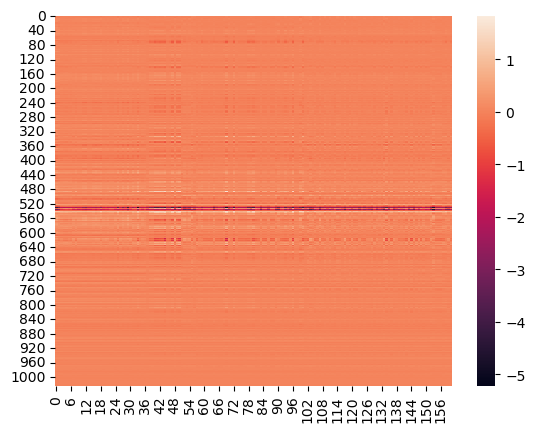

In [45]:
import seaborn as sns
sns.heatmap(out_old_ctst.sum(axis=0))

<Axes: >

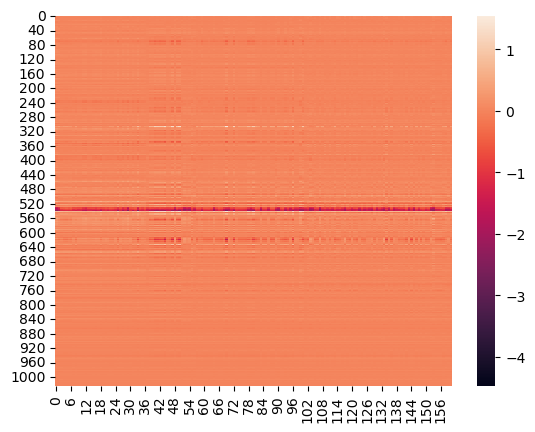

In [46]:
sns.heatmap(out_original_ctst.sum(axis=0))

In [44]:
np.max(out_original_ctst-out_old_ctst)
#bro, they're not even really close... shows something is up

2.202348232269287

In [51]:
#let's remake the original utils with classification!

#i realized the best method is just what I started with but batch it for n terms... so let's just do that, verifies accuracy too, won't be as elegant or efficient, but probably more useful lol
#first let's test to see how fast getting variances for any cCRE is
#the next method is to actually speed it up using batching...
#can test regression at least by checking it with my old function and comparing the results later
#now that we use tensors, we can go ahead and find some ways to use larger batches

#let's fix the code
import torch 
import sys
import yaml 
sys.path.append('/data/leslie/sarthak/hyena/hyena-dna/')
from src.tasks.decoders import SequenceDecoder
from src.models.sequence.dna_embedding import DNAEmbeddingModel
from src.dataloaders.datasets.hg38_char_tokenizer import CharacterTokenizer
# import shap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import logomaker
from tqdm import tqdm
import time
class ISMUtils():
    def __init__(self, model_type, ckpt_path, cfg = None, split = 'train', filter=True, classification = False):
        type_list = ['ccre', 'DNase_ctst', 'DNase_allcelltypes', 'DNase']
        if model_type not in type_list:
            raise ValueError('Model type not recognized')
        self.mtype = model_type
        if cfg is not None:
            cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/'+cfg
        self.classification = classification
        
        #check to see the type, and then load the right tokenizer, class and cfg
        if self.mtype == 'DNase':
            from src.dataloaders.datasets.DNase_dataset import DNaseDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N', 'S', 'U', 'V', 'W', 'X', 'Y', 'Z'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase.yaml'
                
        elif self.mtype == 'DNase_allcelltypes':
            from src.dataloaders.datasets.DNase_allcelltypes import DNaseAllCellTypeDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_allcelltypes.yaml'
                 

        elif self.mtype == 'DNase_ctst':
            from src.dataloaders.datasets.DNase_ctst_dataset import DNaseCtstDataset as DatasetClass
            self.tokenizer = CharacterTokenizer( #make sure to fix the tokenizer too
                characters=['A', 'C', 'G', 'T', 'N'],
                model_max_length=1024 + 2,  # add 2 since default adds eos/eos tokens, crop later
                add_special_tokens=False,
                padding_side='left'
            )
            if cfg is None:
                if self.classification:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst_classification.yaml'
                else:
                    cfg = '/data/leslie/sarthak/hyena/hyena-dna/configs/evals/DNase_ctst.yaml'

        else:
            raise ValueError('Model type not recognized')

        #now we load the model and dataset

        # self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.dataset = DatasetClass(max_length = 1024, split = split, tokenizer=self.tokenizer, rc_aug = False, tokenizer_name='char', add_eos='True', filter = filter, classification=self.classification)
        cfg = yaml.load(open(cfg, 'r'), Loader=yaml.FullLoader)
        
        train_cfg = cfg['train']  # grab section `train` section of config
        model_cfg = cfg['model_config']  # grab the `model` section of config
        d_output = train_cfg['d_output']
        backbone = DNAEmbeddingModel(**model_cfg)
        # backbone_skip = DNAEmbeddingModel(skip_embedding=True, **model_cfg)
        decoder = SequenceDecoder(model_cfg['d_model'], d_output=d_output, l_output=0, mode='pool')
        state_dict = torch.load(ckpt_path, map_location='cpu')  # has both backbone and decoder
        
        # loads model from ddp by removing prexix to single if necessary
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )

        model_state_dict = state_dict["state_dict"]

        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)

        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        decoder_state_dict['output_transform.weight'] = model_state_dict.pop('decoder.0.output_transform.weight')
        decoder_state_dict['output_transform.bias'] = model_state_dict.pop('decoder.0.output_transform.bias')

        #now adjust the backbone if needed
        if self.mtype == 'DNase':
            embedding1 = torch.nn.Embedding(20, 128)
            # embedding2 = torch.nn.Embedding(20, 128)
            backbone.backbone.embeddings.word_embeddings = embedding1 #again a hack
            # backbone_skip.backbone.embeddings.word_embeddings = embedding2 #again a hack

        # now actually load the state dict to the decoder and backbone separately
        decoder.load_state_dict(decoder_state_dict, strict=True)
        backbone.load_state_dict(model_state_dict, strict=True)

        self.backbone = backbone.eval()
        self.decoder = decoder.eval()

        self.bed = pd.read_csv('/data/leslie/sarthak/data/GRCh38-cCREs.bed', header=None, delimiter='\t').to_numpy()
        self.middle = 1023//2 #just used for the logo plots

    def calculate_ISM(self,ccre, cuda = False, return_out = False, progress_bar = False, stop=False, b_size = 8):
        #does ISM for that ccre, based on the model type
        #Does what the ISM.py and ISM_allcelltypes.py files do but for one ccre at a time
        #ccre should be the index of the ccre, not the index to get that dataset
        # start = time.time()
        device = "cuda:0" if cuda else "cpu"
        backbone = self.backbone.to(device)
        decoder = self.decoder.to(device)
        #first have to load in the batch
        #if it's the different groups have very different dataset classes
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            ccre = 161*ccre
            ccre_list = []
            out_list = []
            class_list = []
            for i in range(161):
                a,b = self.dataset[ccre+i]
                ccre_list.append(a)
                if self.classification:
                    # raise NotImplementedError('This is not implemented yet, need to consider how to do ISM with the classification model')
                    class_list.append(b[0].item())
                    b = b[1] #just ignore the classification stuff?
                out_list.append(b.item())
            ccre_list = torch.stack(ccre_list)
        else:
            ccre_list = self.dataset[ccre][0].unsqueeze(0)
            class_list = self.dataset[ccre][1][0] #the classification stuff
        # print(class_list)
        temp,_ = backbone(ccre_list.to(device)) #pass whole ccre as a batch
        out = decoder(temp)
        seqlen = ccre_list.shape[1] #because it's batch x seq
        dim_out = out.shape[1]//2
        #also a dimension for ccre_list.shape[0]
        dim_celltypes = ccre_list.shape[0]

        if self.classification:
            out_class = out[:,:dim_out]
            out = out[:,dim_out:] #just ignore the classification stuff? for now maybe and we just look at the regression outputs?
            #but if it thinks that the thing is closed, we should keep it as 0... or maybe set it to some other value? idk
            #i say keep it but we know that we can mask it, no let's mask for reg, but still need to use for class...
            #and let's keep the class out
            out_class_gt = out_class.detach().reshape(1,1,161)
            ISM_class = torch.ones((4,seqlen,161)).to(device)*out_class_gt
            out_class_gt_np = out_class.detach().cpu().numpy().reshape(1,1,161)
            
        out_gt = out.detach().reshape(1,1,161)
        ISM_results = torch.ones((4,seqlen,161)).to(device)*out_gt
        out_gt_np = out.detach().cpu().numpy().reshape(1, 1, 161) #the initial output of the model before ism
        # if self.classification:
        #     mask_idx = np.array(class_list) == 1 #if it's open
        #     #now we make this a matrix of the same size as the output which will be 3x1x161 or just 3x161
        #     mask = np.zeros((1,1,161))
        #     mask[:,:,mask_idx] = 1
        # print(mask)
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst': #we just need the first sequence, don't care about the useless stuff
            seq = ccre_list[0]
        else:
            seq = ccre_list.squeeze() #get rid f the embedding dimension
        token_list = [7,8,9,10] #tokenize this list first
        mutations = {
            7: np.array([8,9,10]),
            8: np.array([7,9,10]),
            9: np.array([7,8,10]),
            10: np.array([7,8,9])
        }
        ccre_list_gpu = ccre_list.to(device)

        if progress_bar:
            iterator = tqdm(enumerate(seq), total = len(seq))
        else:
            iterator = enumerate(seq)
        batch_seq = torch.zeros(dim_celltypes*3*b_size,ccre_list_gpu.shape[1], dtype=torch.long).to(device)

        # end = time.time()
        # print(f'setup: {end-start}')
        
        # counter = 0 #counter is equal to len(idx_list), but it's for convenience
        # idx_list = []
        with torch.no_grad():
            for idx, nucleotide in iterator: 
                # start = time.time()
                # temp_token_list = token_list.copy() #we make a copy
                # print(nucleotide)
                if nucleotide not in token_list:
                    continue #basically skips this and none of it is updated, because is a weird tooken, whether permutation, ctst or something else
                temp_token_list = mutations[nucleotide.item()]
                # temp_token_list_gpu = torch.tensor(temp_token_list).to(device)
                #make batch_seq a long tensor
                class_list = []
                results_list = []
                for idx2,j in enumerate(temp_token_list):
                    temp_seq = ccre_list_gpu.clone() #already put on the gpu
                    if self.mtype in ['DNase', 'DNase_ctst']:
                        temp_seq[:,idx] = j #should be 161x1024 or 1023. 
                    else:
                        temp_seq[idx] = j #should be 1x1023 because we unsqueezed
                    #now we need to stach them together
                    # batch_seq[counter*3*dim_celltypes+idx2*dim_celltypes:counter*3*dim_celltypes+(idx2+1)*dim_celltypes] = temp_seq
                # counter += 1
                # idx_list.append(idx)
                # torch.cuda.synchronize()
                # end = time.time()
                # print(f'loop: {end-start}')
                # if counter == b_size:
                    # start = time.time()
                    a,_ = backbone(temp_seq)
                    out = decoder(a)
                    if self.classification:
                        class_list.append(out[:,:dim_out].detach().cpu().numpy())
                        results_list.append(out[:,dim_out:].detach().cpu().numpy())
                    else:
                        results_list.append(out.detach().cpu().numpy())

                ISM_results[temp_token_list-7,idx,:] = torch.tensor(results_list).squeeze().to(device)
                if self.classification:
                    ISM_class[temp_token_list-7,idx,:] = torch.tensor(class_list).squeeze().to(device)
                    # torch.cuda.synchronize()
                    # end = time.time()
                    # print(f'forward: {end-start}')
                    # print(out.shape) #is 483 x 2 or 3 x 161*2...
                    # we shoudl split into reg and class, but likely need a way to reshape it properly too
                    # start = time.time()
                    # if self.classification:
                    #     reg_results = out[:,dim_out:].view(3,-1,161) #now 483x1 or 3x161 and transformed into a 3x1x161 matrix
                    #     class_results = out[:,:dim_out].view(3,-1,161)
                    # else:
                    #     reg_results = out.view(3,-1,161) 
                    # for batch_idx,batch in enumerate(idx_list):                        
                    #     ISM_results[temp_token_list_gpu-7,batch,:] = reg_results[:,batch_idx,:]
                    #     if self.classification:
                    #         ISM_class[temp_token_list_gpu-7,batch,:] = class_results[:,batch_idx,:] 
                    # counter = 0
                    # idx_list = []
                    # torch.cuda.synchronize()
                    # end = time.time()
                    # print(f'storing: {end-start}')
        # return 0 #just say we done for now
        #relatively slow on the CPU
        #and now we subtract the out_gt from it
        ISM_results_normalized = ISM_results.detach().cpu().numpy() - out_gt_np #is mutated - reference
        if self.classification:
            ISM_class_normalized = ISM_class.detach().cpu().numpy() - out_class_gt_np
            # ISM_results_normalized *= mask
        if self.classification and return_out:
            return ISM_results_normalized, ISM_class_normalized, out_gt_np, out_class_gt_np
        elif self.classification:
            return ISM_results_normalized, ISM_class_normalized 
        elif return_out: #but this is optional
            return ISM_results_normalized, out_gt_np
        return ISM_results_normalized

    def var(self, idx):
        #This is the idx for the ccre, so if you want it for ccre 2 it's just idx == 2. Not 161*idx
        seq_idx = idx
        cCRE_id = self.dataset.array[seq_idx][0] #get the id from the array
        row = self.dataset.cCRE_dict[cCRE_id]
        #now we can calculate the variance using this data
        # print(np.var(dnase_filtered[row,:])) #identical
        
        return np.var(self.dataset.cell_dnase_levels[row,:])

    def output(self,idx):
        #given the index, this finds the associated output (single value)
        #this literally just puts it thorugh the model, but it's like 2 lines of code and really easy to do yourself
        a,b = self.dataset[idx]
        temp,_ = self.backbone(a.unsqueeze(0))
        out = self.decoder(temp)

        if self.mtype == 'DNase':
            print(f'predicted output: {out}, actual output: {b}')
            return b, out

        elif self.mtype == 'DNase_allcelltypes':
            print(f'predicted output: {out[0,0]}, actual output: {b[0]}')
            return b[0], out[0,0]

    def output_all(self,idx, print_out = False):
        #given the index, this finds the associated output (all values averaged across the cell types for a singel ccre)
        #if it's DNase, then we need to do it for all the cell types, here the input idx should not be 161 times any number, rather just the ccre number
        if self.mtype == 'DNase' or self.mtype == 'DNase_ctst':
            idx = 161*idx
            out_list = []
            target_list = []
            for i in range(161):
                a,b = self.dataset[idx+i]
                temp,_ = self.backbone(a.unsqueeze(0))
                out = self.decoder(temp)
                out_list.append(out.item())
                if isinstance(b,tuple):
                    raise NotImplementedError('This is not implemented yet, need to consider how to do handle these outputs and what we want to display')
                target_list.append(b.item())
            out = np.mean(out_list)
            if print_out:
                print(f'predicted output mean: {out}, actual output mean: {np.mean(target_list)}')
            #but return the whole lists
            return np.array(target_list), np.array(out_list)

        if self.mtype == 'DNase_allcelltypes':
            a,b = self.dataset[idx]
            temp,_ = self.backbone(a.unsqueeze(0))
            out = self.decoder(temp)
            print(f'predicted output mean: {torch.mean(out)}, actual output mean: {torch.mean(b)}')
            return b.detach().numpy(), out.detach().numpy()
    
    def find_ccre_type(self, idx):
        #this function will use the ccre id to find the specific type
        #uses the index of the dataset, not the cCRE for the DNase model!!
        #first get the id
        if self.mtype == 'DNase':        
            seq_idx = int(idx/self.dataset.cell_types)
        else:
            seq_idx = idx
        ccre_id = self.dataset.array[seq_idx][0]
        line = np.where(self.bed[:,3] == ccre_id)
        return self.bed[line[0][0], -1]

#let's test the speed of our ISM
# ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-03-20/16-22-11-658258/checkpoints/10-val_loss=0.38773.ckpt'
# util = ISMUtils('DNase_ctst', ckpt_path, classification=True)
# out = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=True, stop = 20)
#by editing it to batch, almost doubled the speed... wait could it just be that it's an A100??

In [52]:
ckpt_path = '/data/leslie/sarthak/hyena/hyena-dna/outputs/2024-02-17/15-43-26-621154/checkpoints/last.ckpt'
util = ISMUtils('DNase_ctst', ckpt_path, classification=False)
out_new_ctst = util.calculate_ISM(0, cuda=True, progress_bar = True, return_out=False) #takes about 60 GB of memory...
#takes 4 seconds longer than the batched approach?

 11%|█         | 108/1024 [00:07<01:01, 15.01it/s]

100%|██████████| 1024/1024 [01:08<00:00, 15.02it/s]


In [53]:
#let's see if this is the same
np.allclose(out_new_ctst,out_old_ctst)
#whew! We can stick to this new method then, lets transfer it over? then push to github

True